# ECONOMIC WORDS TWEETS

## PART 1: Finding economic tweets using list of potential economic keywords being used in tweets 

**Objective**: To accurately identify and flag tweets discussing economic topics from English-translated Polish Twitter data, based on a predefined list of 56 economic keywords and multi-word expressions (MWEs), while minimizing false positives.

**Methodology**: A hybrid natural language processing (NLP) approach was implemented, integrating efficient string matching with contextual linguistic analysis using the spaCy library (en_core_web_lg model). The process involves several stages:

Initialization:

1. The predefined list of economic terms was separated into single words and MWEs.
2. An Aho-Corasick automaton was built for efficient matching of the exact MWE sequences (case-insensitive).
3. Single keywords were lemmatized using spaCy, and a dictionary (target_lemmas) was created mapping each base lemma (lowercase) to its corresponding original keyword(s).
4. Tweet Processing Pipeline: Each tweet's text (text_clean_en) was processed as follows:
    a) MWE Matching: The Aho-Corasick automaton identified all occurrences of predefined MWEs within the tweet text (case-insensitive). These matches were recorded.

    b) SpaCy Linguistic Analysis: The tweet text was processed by spaCy to obtain tokenization, lemmatization, Part-of-Speech (POS) tags (Universal POS tags like NOUN, VERB, PROPN), and Named Entity Recognition (NER) tags (like ORG, MONEY).

    c) Contextual Span Identification: Character indices covered by specific non-economic named entities (e.g., 'Europarlament' tagged as ORG) defined in a blocklist (NON_ECONOMIC_ORG_ENTITIES) were pre-calculated.

    d) Filtered Lemma Matching: Each token in the spaCy-processed tweet was evaluated:

        - Tokens overlapping with already matched MWEs were skipped.
        - Tokens overlapping with the pre-identified non-economic entity spans were ignored (NER Filter).

    e) For the remaining tokens, the lowercase lemma (token.lemma_.lower()) was checked against the target_lemmas dictionary.
        If a lemma match occurred, an additional POS filter was applied only if the lemma was present as a key in a predefined RELEVANT_POS_TAGS dictionary. This dictionary specifies allowed POS tags (e.g., {'NOUN', 'PROPN'} for 'bank') for ambiguous keywords like names of institutions. If the token's token.pos_ was not in the allowed set for that lemma, the match was ignored.
    
    f) Matches passing all filters were recorded, storing both the original token text and the corresponding base keyword(s)).
        Post-hoc Filtering: After initial flagging based on the refined extraction, a final filtering step was applied. Rows where the only matched base keywords were 'equality' or 'inequalities' (or both) were identified and removed entirely from the dataset. This aimed to exclude tweets discussing social/gender equality rather than economic equality when no other economic context was present.

**Output**: The process yields final lists of matched base keywords (matched_keywords_FILTERED) and extracted original word forms (extracted_terms_FILTERED) for each tweet, along with a final boolean flag (has_econ_term_FILTERED reflecting the state after the post-hoc removal) indicating whether the tweet contains relevant economic terms according to this refined procedure.

### For the ABSTRACT - part 1

**explanations**:

Aho-Corasick - Aho-Corasick is a string matching algorithm that efficiently finds all occurrences of a set of keywords in a text. It builds a finite state machine (FSM) from the keywords, allowing for simultaneous searching of multiple patterns in linear time.
spaCy - spaCy is a popular NLP library in Python that provides pre-trained models for various languages, including English. It offers functionalities like tokenization, lemmatization, POS tagging, and NER, making it suitable for linguistic analysis of text data.  

**part of abstract - methodology of finding economic related tweets**

In order to find economic discourse in downloaded tweets, we created keyword-based classification technique that goes beyond basic string matching. This method utilizes a predetermined list of multi-word expressions (MWEs) and economic terms. It combines spaCy-based lemmatization to capture morphological variants, such as verb forms and plurals with the Aho-Corasick algorithm for effective matching of multi-word phrases. Importantly, spaCy's linguistic features are used to apply contextual filters that remove uncertainty from meaning of keyword matches. Filters aim to apply Part-of-Speech tag restrictions for ambiguous keywords, such as separating noun uses of "bank" from verb uses, and ignore matches that exist within specific non-economic Named Entities, like "Europarlament." To eliminate likely non-economic social contexts, a final post-hoc adjustment removes tweets where the only keywords found were "equality" or "inequalities.", which after manual inspection were discorvered as relating only to social topics. Compared to simpler keyword or lemma-only approaches, this hybrid method yields a more accurate classification of tweets relevant to the target economic vocabulary by reducing contextually inappropriate matches while maintaining recall through lemmatization. 

## Part 2: Visualization and Analysis of Identified Economic Discourse

Following the identification of economic tweets, a comprehensive suite of visualizations and statistical analyses is performed to understand the characteristics and distribution of this discourse. This includes:

Temporal Analysis: The volume of economic tweets is plotted over time (e.g., weekly counts), with key events such as the 2023 Polish election annotated with vertical lines and pre/post periods highlighted using shaded regions to observe potential shifts in discourse volume.
Keyword Popularity: The most and least frequent economic keywords from the final filtered list are identified and visualized using bar charts, providing insights into the dominant themes.
Method Comparison: The performance and output of the final refined keyword extraction method are compared against simpler exact-match techniques (Naive, Regex, FlashText, Aho-Corasick) and aggregated approaches (Union, Gateway). This involves comparing total flagged tweet counts, analyzing overlaps and differences in flagged sets (e.g., via Venn diagrams of top tokens and detailed examination of disagreement samples), and assessing keyword frequencies unique to each method.
Party-Level Discourse: The economic discourse is further analyzed by political party affiliation. This includes visualizing the top economic tokens used by each party (via grouped and stacked bar charts) and plotting the share (percentage) of each party's total tweets that were flagged as economic by different methods (Union, Gateway, and Final Refined).
Top Contributors: Analysis is conducted to identify the top individuals (users/authors) contributing to economic discourse within each party and overall, based on both the raw number and the percentage of their tweets flagged as economic. These are visualized using bar charts sorted within parties and globally.

### For the ABSTRACT - part 2

## Part 3: Sentiment Analysis of Economic Tweets (Overlook)



Once the relevant economic tweets are identified and filtered, the subsequent stage of the project involves sentiment analysis to determine the polarity of this discourse.

Objective: To classify each economic tweet as 'Positive', 'Neutral', or 'Negative'.
Method: This will be achieved by applying a pre-trained transformer-based language model, specifically cardiffnlp/twitter-roberta-base-sentiment-latest, known for its strong performance on social media text. The model will be applied to the demojized text of the tweets flagged by the final refined keyword extraction method.
Expected Output & Analysis: The process will yield a sentiment label and a confidence score for each economic tweet. These results will then be analyzed and visualized to understand:
The overall sentiment distribution (e.g., percentage of positive, neutral, negative economic tweets).
Sentiment trends over time, potentially correlated with specific events.
Sentiment breakdown by political party.
The distribution of sentiment confidence scores.
Potentially, an exploration of the most common keywords associated with each sentiment category.
This sentiment analysis phase aims to add another layer of understanding to the nature of the economic discussions identified.

### For the ABSTRACT - part 3

# CODE

In [1]:
import os

os.getcwd()

'h:\\000_Projects\\01_GitHub\\05_PythonProjects\\Twitter'

In [2]:
import pandas as pd

# Load the Parquet file into a DataFrame
# df_clean_translated = pd.read_parquet('data/03_cleaned/df_combined_after_vote_data.parquet') # From 2023-10-16 till the 2024-10-15
# df_clean_translated = pd.read_parquet('data/03_cleaned/df_combined_whole_data.parquet') # From 2022-10-16 till the 2024-10-15

In [3]:
import pandas as pd

# Load the first Parquet file to get the desired column order -> issue with raw files 
try:
    df_reference_after_vote = pd.read_parquet('data/03_cleaned/df_combined_after_vote_data.parquet')
    desired_column_order = df_reference_after_vote.columns.tolist()
except FileNotFoundError:
    print(f"Error: File 'data/03_cleaned/df_combined_after_vote_data.parquet' not found. "f"Please ensure this file exists to determine the column order.")
    exit()

# Load the second Parquet file
df_clean_translated = pd.read_parquet('data/03_cleaned/df_combined_whole_data.parquet')

# Reindex the second DataFrame to match the column order of the first
df_clean_translated = df_clean_translated.reindex(columns=desired_column_order)

# Now df_clean_translated should have the same column order as df_reference
print("Column order of the reindexed DataFrame:")
print(df_clean_translated.columns.tolist())

Column order of the reindexed DataFrame:
['created_at', 'text', 'id', 'author_id', 'edit_controls', 'possibly_sensitive', 'reply_settings', 'lang', 'edit_history_tweet_ids', 'conversation_id', 'category', 'attachments', 'username', 'party', 'in_reply_to_user_id', 'context_annotations', 'referenced_tweets', 'geo', 'text_clean', 'mentions', 'links', 'hashtags', 'retweet_count', 'reply_count', 'like_count', 'quote_count', 'impression_count', 'text_clean_en', 'text_clean_en_demojized', 'text_clean_demojized', 'emoji_count_en', 'emoji_count', 'name']


In [4]:
df_reference_after_vote

created_at  \
0     2024-03-06 14:15:34+00:00   
1     2024-03-03 11:05:34+00:00   
2     2024-03-02 14:15:58+00:00   
3     2024-03-01 14:45:39+00:00   
4     2024-02-29 12:04:21+00:00   
...                         ...   
25682 2023-10-24 10:46:22+00:00   
25683 2023-10-19 18:05:26+00:00   
25684 2023-10-19 08:52:05+00:00   
25685 2023-10-18 16:12:37+00:00   
25686 2023-10-17 19:59:04+00:00   

                                                    text                   id  \
0      Policja rzucająca kostką brukową w rolników, p...  1765380709114409216   
1      Zwróćcie uwagę na punkt 11.\nTu nie ma z czego...  1764245727646044160   
2      Równość, ale nie dla wszystkich… \nPani „minis...  1763931255521857792   
3      Pytanie za sto punktów! \nFirma jakiego państw...  1763576337078313216   
4      Ukraina jeździ na polskim paliwie. \n\nPrzypom...  1763173358068281600   
...                                                  ...                  ...   
25682  Formacje demokratyczne będą tworzyć przyszły r...  1716768088052359424   
25683  Żadne podchody, kłamstwa czy medialne wrzutki ...  1715066644018381312   
25684  Polska potrzebuje nowego, demokratycznego rząd...  1714927388637696256   
25685  95 lat temu zmarł generał Tadeusz Jordan Rozwa...  1714675864237924864   
25686  Mówiliśmy jasno: albo #TrzeciaDroga, albo trze...  1714370461507748096   

          author_id                                      edit_controls  \
0      1.554484e+18  {'editable_until': '2024-03-06 15:15:34+00:00'...   
1      1.554484e+18  {'editable_until': '2024-03-03 12:05:34+00:00'...   
2      1.554484e+18  {'editable_until': '2024-03-02 15:15:58+00:00'...   
3      1.554484e+18  {'editable_until': '2024-03-01 15:45:39+00:00'...   
4      1.554484e+18  {'editable_until': '2024-02-29 13:04:21+00:00'...   
...             ...                                                ...   
25682  9.552394e+08  {'editable_until': '2023-10-24 11:46:22+00:00'...   
25683  9.552394e+08  {'editable_until': '2023-10-19 19:05:26+00:00'...   
25684  9.552394e+08  {'editable_until': '2023-10-19 09:52:05+00:00'...   
25685  9.552394e+08  {'editable_until': '2023-10-18 17:12:37+00:00'...   
25686  9.552394e+08  {'editable_until': '2023-10-17 20:59:04+00:00'...   

       possibly_sensitive reply_settings lang edit_history_tweet_ids  \
0                   False       everyone   pl  [1765380709114409272]   
1                   False       everyone   pl  [1764245727646044196]   
2                   False       everyone   pl  [1763931255521857839]   
3                   False       everyone   pl  [1763576337078313201]   
4                   False       everyone   pl  [1763173358068281524]   
...                   ...            ...  ...                    ...   
25682               False       everyone   pl  [1716768088052359454]   
25683               False       everyone   pl  [1715066644018381294]   
25684               False       everyone   pl  [1714927388637696291]   
25685               False       everyone   pl  [1714675864237924823]   
25686               False       everyone   pl  [1714370461507748145]   

       conversation_id  ... reply_count like_count quote_count  \
0         1.765381e+18  ...           4        203           0   
1         1.764246e+18  ...           0          2           0   
2         1.763931e+18  ...           0          0           0   
3         1.763576e+18  ...           0          1           0   
4         1.763173e+18  ...           0          0           0   
...                ...  ...         ...        ...         ...   
25682     1.716768e+18  ...        2013       4637         100   
25683     1.715067e+18  ...        2406      12760         182   
25684     1.714927e+18  ...        1108       3443          47   
25685     1.714676e+18  ...         354       1568          21   
25686     1.714370e+18  ...        2136      11558         171   

      impression_count                                      text_clean_en  \
0  

In [5]:
df_clean_translated[df_clean_translated['name'].notna()]

created_at  \
0     2024-10-15 19:49:34+00:00   
1     2024-10-15 16:12:19+00:00   
2     2024-10-15 12:09:12+00:00   
3     2024-10-15 07:32:44+00:00   
4     2024-10-15 06:27:14+00:00   
...                         ...   
48326 2023-09-29 11:30:44+00:00   
48327 2023-09-19 13:08:40+00:00   
48328 2023-09-15 12:59:29+00:00   
48329 2023-09-13 14:07:56+00:00   
48330 2023-09-12 14:39:09+00:00   

                                                    text                   id  \
0      @donaldtusk Niezrealizowanie większości ze "10...  1846277256509116672   
1      Rok po wyborach trzeba powiedzieć jedno - nie ...  1846222583898784000   
2       ❌ Mamy rok po wyborach, a Polska pogrąża się ...  1846161400328028160   
3      Mija rok od wyborów parlamentarnych. W kampani...  1846091824101769472   
4                  #Idę11  🇵  🇱  https://t.co/KiCe5ATOpX  1846075343188144128   
...                                                  ...                  ...   
48326  Studiujesz na kierunku lekarskim, pielęgniarst...  1707719554355380480   
48327  Za nami posiedzenie @SejmikMaz. I kolejne wspa...  1704120323023454464   
48328  Płockie Centrum Onkologii gotowe! Już na począ...  1702668459576786944   
48329  To jedna z największych inwestycji drogowych @...  1701960909369868544   
48330  Powiaty mają 25 lat ❗ ️Na @Zamek_Krolewski odb...  1701606379709198336   

          author_id                                      edit_controls  \
0      1.182212e+09  {'editable_until': '2024-10-15 20:49:34+00:00'...   
1      1.182212e+09  {'editable_until': '2024-10-15 17:12:19+00:00'...   
2      1.182212e+09  {'editable_until': '2024-10-15 13:09:12+00:00'...   
3      1.182212e+09  {'editable_until': '2024-10-15 08:32:44+00:00'...   
4      1.182212e+09  {'editable_until': '2024-10-15 07:27:14+00:00'...   
...             ...                                                ...   
48326  9.611819e+08  {'editable_until': '2023-09-29 12:30:44+00:00'...   
48327  9.611819e+08  {'editable_until': '2023-09-19 14:08:40+00:00'...   
48328  9.611819e+08  {'editable_until': '2023-09-15 13:59:29+00:00'...   
48329  9.611819e+08  {'editable_until': '2023-09-13 15:07:56+00:00'...   
48330  9.611819e+08  {'editable_until': '2023-09-12 15:39:09+00:00'...   

       possibly_sensitive reply_settings lang edit_history_tweet_ids  \
0                   False       everyone   pl  [1846277256509116623]   
1                   False       everyone   pl  [1846222583898784025]   
2                   False       everyone   pl  [1846161400328028272]   
3                   False       everyone   pl  [1846091824101769490]   
4                   False       everyone  qme  [1846075343188144153]   
...                   ...            ...  ...                    ...   
48326               False       everyone   pl  [1707719554355380484]   
48327               False       everyone   pl  [1704120323023454339]   
48328               False       everyone   pl  [1702668459576787064]   
48329               False       everyone   pl  [1701960909369868437]   
48330               False       everyone   pl  [1701606379709198357]   

       conversation_id  ... reply_count like_count quote_count  \
0         1.846092e+18  ...           1         33           0   
1         1.846223e+18  ...           2         72           0   
2         1.846161e+18  ...           3         33           2   
3         1.846092e+18  ...           2         38           0   
4         1.846075e+18  ...          18        616           2   
...                ...  ...         ...        ...         ...   
48326     1.707720e+18  ...           0          6           0   
48327     1.704120e+18  ...           0         15           0   
48328     1.702668e+18  ...           0         16           0   
48329     1.701961e+18  ...           0         13           0   
48330     1.701606e+18  ...           2         16           0   

      impression_count                                      text_clean_en  \
0  

In [6]:
df_clean_translated[df_clean_translated['name'].isna()]

Empty DataFrame
Columns: [created_at, text, id, author_id, edit_controls, possibly_sensitive, reply_settings, lang, edit_history_tweet_ids, conversation_id, category, attachments, username, party, in_reply_to_user_id, context_annotations, referenced_tweets, geo, text_clean, mentions, links, hashtags, retweet_count, reply_count, like_count, quote_count, impression_count, text_clean_en, text_clean_en_demojized, text_clean_demojized, emoji_count_en, emoji_count, name]
Index: []

[0 rows x 33 columns]

In [7]:
# Get the rows where 'name' is NaN
missing_name_df = df_clean_translated[df_clean_translated['name'].isna()]

# Extract unique usernames from those rows
missing_name_usernames = missing_name_df['username'].unique().tolist()
missing_name_usernames

[]

Corrected names -> should be empty list

Below code for correcting names in this df (optional use)

In [8]:
username_to_realname = {
    'bartlomiejpejo': 'Bartłomiej Pejo',
    'GrzegorzBraun_': 'Grzegorz Braun',
    'Iwaszkiewicz_RJ': 'Robert Iwaszkiewicz',
    'KonradBerkowicz': 'Konrad Berkowicz',
    'MarSypniewski': 'Marcin Sypniewski',
    'MichalWawer': 'Michał Wawer',
    'placzekgrzegorz': 'Grzegorz Płaczek',
    'SlawomirMentzen': 'Sławomir Mentzen',
    'TudujKrzysztof': 'Krzysztof Tuduj',
    'Wlodek_Skalik': 'Włodzimierz Skalik',
    'WTumanowicz': 'Witold Tumanowicz',
    'AndrzejSzejna': 'Andrzej Szejna',
    'AnitaKDZG': 'Anita Kucharska-Dziedzic',
    'JoankaSW': 'Joanna Scheuring-Wielgus',
    'KGawkowski': 'Krzysztof Gawkowski',
    'K_Smiszek': 'Krzysztof Śmiszek',
    'MarcinKulasek': 'Marcin Kulasek',
    'MoskwaWodnicka': 'Małgorzata Moskwa-Wodnicka',
    'PaulinaPW2024': 'Paulina Piechna-Więckiewicz',
    'poselTTrela': 'Tomasz Trela',
    'RobertBiedron': 'Robert Biedroń',
    'WandaNowicka': 'Wanda Nowicka',
    'wieczorekdarek': 'Dariusz Wieczorek',
    'wlodekczarzasty': 'Włodzimierz Czarzasty',
    'Arek_Iwaniak': 'Arkadiusz Iwaniak',
    'B_Maciejewska': 'Beata Maciejewska',
    'BeataSzydlo': 'Beata Szydło',
    'elzbietawitek': 'Elżbieta Witek',
    'Kaminski_M_': 'Mariusz Kamiński',
    'Kowalczyk_H': 'Henryk Kowalczyk',
    'Macierewicz_A': 'Antoni Macierewicz',
    'mblaszczak': 'Mariusz Błaszczak',
    'MorawieckiM': 'Mateusz Morawiecki',
    'mwojcik_': 'Michał Wójcik',
    'PatrykJaki': 'Patryk Jaki',
    'bbudka': 'Borys Budka',
    'CTomczyk': 'Cezary Tomczyk',
    'donaldtusk': 'Donald Tusk',
    'DorotaNiedziela': 'Dorota Niedziela',
    'EwaKopacz': 'Ewa Kopacz',
    'JanGrabiec': 'Jan Grabiec',
    'Konwinski_PO': 'Zbigniew Konwiński',
    'Leszczyna': 'Izabela Leszczyna',
    'MKierwinski': 'Marcin Kierwiński',
    'M_K_Blonska': 'Małgorzata Kidawa-Błońska',
    'OklaDrewnowicz': 'Agnieszka Okła-Drewnowicz',
    'trzaskowski_': 'Rafał Trzaskowski',
    'TomaszSiemoniak': 'Tomasz Siemoniak',
    'AgaBaranowskaPL': 'Agnieszka Baranowska',
    'aga_buczynska': 'Agnieszka Buczyńska',
    'hennigkloska': 'Paulina Hennig-Kloska',
    'joannamucha': 'Joanna Mucha',
    'Kpelczynska': 'Katarzyna Pełczyńska-Nałęcz',
    'LukaszOsmalak': 'Łukasz Osmalak',
    'SlizPawel': 'Paweł Śliz',
    'szymon_holownia': 'Szymon Hołownia',
    'ZalewskiPawel': 'Paweł Zalewski',
    'ZywnoMaciej': 'Maciej Żywno',
    'JKozlowskiEu': 'Jacek Kozłowski',
    'michalkobosko': 'Michał Kobosko',
    'DariuszKlimczak': 'Dariusz Klimczak',
    'GrzybAndrzej': 'Andrzej Grzyb',
    'Hetman_K': 'Krzysztof Hetman',
    'JarubasAdam': 'Adam Jarubas',
    'KosiniakKamysz': 'Władysław Kosiniak-Kamysz',
    'Paslawska': 'Urszula Pasławska',
    'PZgorzelskiP': 'Piotr Zgorzelski',
    'StefanKrajewski': 'Stefan Krajewski',
    'StruzikAdam': 'Adam Struzik'
}

# # Add the 'name' column to the DataFrame
# df['name'] = df['username'].map(username_to_realname)

# 1. First, create a case-insensitive version of mapping dictionary
username_to_realname_lower = {k.lower(): v for k, v in username_to_realname.items()}

# 2. Now create a function to do the mapping with case-insensitivity
def case_insensitive_map(username):
    if pd.isna(username):
        return None
    return username_to_realname_lower.get(username.lower(), None)

# 3. Apply the function to the DataFrame
df_clean_translated['name'] = df_clean_translated['username'].apply(case_insensitive_map)

# 4. Check if it worked
missing_name_df = df_clean_translated[df_clean_translated['name'].isna()]
missing_name_usernames = missing_name_df['username'].unique().tolist()
print(f"Usernames still missing: {len(missing_name_usernames)}")
print(missing_name_usernames[:100])  # Print first 100 missing usernames

Usernames still missing: 0
[]


In [9]:
df_clean_translated['name'].value_counts()

name
Marcin Kulasek          2102
Marcin Kierwiński       1957
Krzysztof Śmiszek       1759
Patryk Jaki             1755
Rafał Trzaskowski       1663
                        ... 
Agnieszka Baranowska      53
Cezary Tomczyk            33
Jacek Kozłowski           18
Robert Iwaszkiewicz       10
Adam Struzik               7
Name: count, Length: 69, dtype: int64

In [10]:
df_clean_translated[df_clean_translated['name'] == 'Tomasz Trela']

created_at  \
15482 2024-04-15 16:16:47+00:00   
15483 2024-04-14 16:07:36+00:00   
15484 2024-04-14 15:58:17+00:00   
15485 2024-04-14 10:04:50+00:00   
15486 2024-04-13 13:06:26+00:00   
...                         ...   
16954 2024-04-17 17:33:19+00:00   
16955 2024-04-16 15:08:38+00:00   
16956 2024-04-16 04:30:46+00:00   
16957 2024-04-16 03:37:38+00:00   
16958 2024-04-16 03:25:44+00:00   

                                                    text                   id  \
15482  Spokojna i zrównoważona praca w ramach Koalicj...  1779906728336715776   
15483  @DBrzezicka Fajna ta kuchnia, zazdroszczę 😉  😉...  1779542027924803584   
15484  Czasu mało, pracy dużo. Szczegóły wkrótce. htt...  1779539685288587776   
15485  @SlawomirMentzen To jak to jest? Chcecie wyjść...  1779450736721428736   
15486  Bardzo dobra decyzja. @KotulaKat, będziemy wal...  1779134049358864640   
...                                                  ...                  ...   
16954  Wybory do Parlamentu Europejskiego już za mome...  1780650761271025664   
16955  Włókiennictwo - historia, tradycja, przyszłość...  1780251965798174976   
16956  @patrykmichalski @wirtualnapolska Królestwo pa...  1780091438602039552   
16957  @KosiniakKamysz @OlekMiszalski @FijoKonrad @Ja...  1780078069748744704   
16958  Pierwsze pieniądze z KPO już są. 27 mld zł, to...  1780075073245749504   

         author_id                                      edit_controls  \
15482  547089308.0  {'editable_until': '2024-04-15 17:16:47+00:00'...   
15483  547089308.0  {'editable_until': '2024-04-14 17:07:36+00:00'...   
15484  547089308.0  {'editable_until': '2024-04-14 16:58:17+00:00'...   
15485  547089308.0  {'editable_until': '2024-04-14 11:04:50+00:00'...   
15486  547089308.0  {'editable_until': '2024-04-13 14:06:26+00:00'...   
...            ...                                                ...   
16954  547089308.0  {'editable_until': '2024-04-17 18:33:19+00:00'...   
16955  547089308.0  {'editable_until': '2024-04-16 16:08:38+00:00'...   
16956  547089308.0  {'editable_until': '2024-04-16 05:30:46+00:00'...   
16957  547089308.0  {'editable_until': '2024-04-16 04:37:38+00:00'...   
16958  547089308.0  {'editable_until': '2024-04-16 04:25:44+00:00'...   

       possibly_sensitive reply_settings lang edit_history_tweet_ids  \
15482               False       everyone   pl  [1779906728336715804]   
15483               False       everyone   pl  [1779542027924803671]   
15484               False       everyone   pl  [1779539685288587721]   
15485               False       everyone   pl  [1779450736721428650]   
15486               False       everyone   pl  [1779134049358864601]   
...                   ...            ...  ...                    ...   
16954               False       everyone   pl  [1780650761271025751]   
16955               False       everyone   pl  [1780251965798174858]   
16956               False       everyone   pl  [1780091438602039654]   
16957               False       everyone   pl  [1780078069748744647]   
16958               False       everyone   pl  [1780075073245749411]   

       conversation_id  ... reply_count like_count quote_count  \
15482     1.779907e+18  ...          78         67           4   
15483     1.779494e+18  ...          11        101           1   
15484     1.779540e+18  ...         223        254          27   
15485     1.779450e+18  ...         109       1491           2   
15486     1.779134e+18  ...         171        144           3   
...                ...  ...         ...        ...         ...   
16954     1.780651e+18  ...          89         76           5   
16955     1.780252e+18  ...           3         32           0   
16956     1.780091e+18  ...          15        312           0   
16957     1.779884e+18  ...           1         13           0   
16958     1.780075e+18  ...         213        268           6   

      impression_count                                      text_clean_en  \
15482          

Deletion of rows with Tomasz Trela posts as he was used to check on the code correctness (downloader) and he is not part of any of the groups

In [11]:
# Store the initial row count
initial_count = len(df_clean_translated)

# Create a mask for rows where name == 'Tomasz Trela'
mask_trela = (df_clean_translated['name'] == 'Tomasz Trela')

# Count total rows for Tomasz Trela (overall)
trela_count_overall = mask_trela.sum()

# Define date ranges
range_1_start = '2022-10-16' # strart of the data collection
range_1_end   = '2023-10-15' # Polish parliamentary election 
range_2_start = '2023-10-16' # after the Polish parliamentary election
end_date = df_clean_translated['created_at'].max()  # For display

# Create date range masks
mask_range_1 = (df_clean_translated['created_at'] >= range_1_start) & (df_clean_translated['created_at'] <= range_1_end)
mask_range_2 = (df_clean_translated['created_at'] >= range_2_start)

# Count how many Tomasz Trela rows fall within each date range
trela_count_range_1 = (mask_trela & mask_range_1).sum()
trela_count_range_2 = (mask_trela & mask_range_2).sum()

# Remove those rows
df_clean_translated = df_clean_translated[~mask_trela]
final_count = len(df_clean_translated)

# Print stats
print(f"Initial row count: {initial_count}")
print(f"Overall rows for 'Tomasz Trela': {trela_count_overall}")
print(f"Removed within {range_1_start} to {range_1_end}: {trela_count_range_1}")
print(f"Removed within {range_2_start} to {end_date}: {trela_count_range_2}")
print(f"Final row count after removal of Tomasz Trela: {final_count}")

Initial row count: 48331
Overall rows for 'Tomasz Trela': 1477
Removed within 2022-10-16 to 2023-10-15: 0
Removed within 2023-10-16 to 2024-10-15 21:41:45+00:00: 1477
Final row count after removal of Tomasz Trela: 46854


In [12]:
df_clean_translated.columns

Index(['created_at', 'text', 'id', 'author_id', 'edit_controls',
       'possibly_sensitive', 'reply_settings', 'lang',
       'edit_history_tweet_ids', 'conversation_id', 'category', 'attachments',
       'username', 'party', 'in_reply_to_user_id', 'context_annotations',
       'referenced_tweets', 'geo', 'text_clean', 'mentions', 'links',
       'hashtags', 'retweet_count', 'reply_count', 'like_count', 'quote_count',
       'impression_count', 'text_clean_en', 'text_clean_en_demojized',
       'text_clean_demojized', 'emoji_count_en', 'emoji_count', 'name'],
      dtype='object')

Loading economic words list 

In [13]:
import pandas as pd

def load_economic_words(csv_path):
    # Read the CSV without assuming a header row
    df = pd.read_csv(csv_path, header=None)
    # Convert the first row to a list, dropping any missing values
    words = df.iloc[0].dropna().tolist()
    # Strip extra whitespace from each word
    words = [word.strip() for word in words]
    # Remove the header element if present (e.g., 'economic_words')
    if words and words[0].lower() == 'economic_words':
        words = words[1:]
    return words

# example usage
economic_words = load_economic_words('data/economic_words.csv')

# economic_words already defined earlier
print("Economic words list:", economic_words)

Economic words list: ['agricultural', 'allowance', 'bank', 'budget', 'consumer', 'credit', 'crisis', 'currency', 'debt', 'demand', 'deregulation', 'development', 'economics', 'economy', 'emissions', 'energy', 'entrepreneurs', 'equalities', 'euro', 'export', 'finance', 'fund', 'gap', 'natural gas', 'highway', 'import', 'inequalities', 'inflation', 'infrastructure', 'industry', 'innovations', 'investment', 'labour', 'macroeconomics', 'market', 'pensions', 'pricey', 'privatization', 'poverty', 'recession', 'savings', 'sector', 'stock market', 'supply', 'taxes', 'trade', 'transition', 'unemployment', 'valorization', 'VAT', 'treasury', 'state-owned companies', 'GDP', 'economic growth', 'economic development', 'economic crisis']


In [14]:
economic_words_set = set(economic_words)

print(len(economic_words_set))

print(len(economic_words))

56
56


**1. Exact Match Approach** - naive aproach

This approach splits the text by whitespace, lowercases the tokens, and checks for membership in *economic words* set.

In [15]:
def matched_exact_economic_words_token(text):
    if pd.isna(text):
        return []
    tokens = text.lower().split()
    # Return unique tokens that exactly match one of your economic words
    return list(set(token for token in tokens if token in economic_words_set))

df_clean_translated['matched_exact_econ_words_naive'] = df_clean_translated['text_clean_en'].apply(matched_exact_economic_words_token)
df_clean_translated['has_exact_econ_word_naive'] = df_clean_translated['matched_exact_econ_words_naive'].apply(lambda x: len(x) > 0)

#df_clean_translated['matched_exact_econ_words_demojized_naive'] = df_clean_translated['text_clean_en_demojized'].apply(matched_exact_economic_words_token)
#df_clean_translated['has_exact_econ_word_demojized_naive'] = df_clean_translated['matched_exact_econ_words_demojized_naive'].apply(lambda x: len(x) > 0)

In [16]:
df_clean_translated[df_clean_translated["has_exact_econ_word_naive"] == True]

# df_clean_translated[df_clean_translated["has_exact_econ_word_demojized_naive"] == True]

created_at  \
2     2024-10-15 12:09:12+00:00   
28    2024-10-08 19:47:37+00:00   
30    2024-10-08 08:39:44+00:00   
32    2024-10-07 14:35:39+00:00   
35    2024-10-06 19:01:36+00:00   
...                         ...   
48279 2023-02-24 10:58:06+00:00   
48280 2023-02-24 09:06:58+00:00   
48299 2023-02-05 16:50:22+00:00   
48303 2023-01-27 09:23:16+00:00   
48306 2023-01-08 12:59:29+00:00   

                                                    text                   id  \
2       ❌ Mamy rok po wyborach, a Polska pogrąża się ...  1846161400328028160   
28     O trendach i wyzwaniach rynku Data Center rozm...  1843740048350691584   
30     Okazuje się, że Polska 2050 to sklep meblarski...  1843571973001232640   
32     Taki jest właśnie stosunek państwa do polskieg...  1843299154703122432   
35     Europejska gospodarka staje się niekonkurencyj...  1843003692800516352   
...                                                  ...                  ...   
48279  O trudnej sytuacji na ryku mleka na Sejmowej K...  1629073176809414656   
48280  Panie Ministrze @JKowalski_posel będzie pan na...  1629045207051210752   
48299  Szanowny Panie Ministrze węgla i słomy gdybyśc...  1622276457975222272   
48303  9 Forum Sektora Wołowiny - spotkaliśmy się w g...  1618902451620573184   
48306  @J10880 @nowePSL @tvp_info Taka jest różnica ż...  1612071495026483200   

          author_id                                      edit_controls  \
2      1.182212e+09  {'editable_until': '2024-10-15 13:09:12+00:00'...   
28     1.182212e+09  {'editable_until': '2024-10-08 20:47:37+00:00'...   
30     1.182212e+09  {'editable_until': '2024-10-08 09:39:44+00:00'...   
32     1.182212e+09  {'editable_until': '2024-10-07 15:35:39+00:00'...   
35     1.182212e+09  {'editable_until': '2024-10-06 20:01:36+00:00'...   
...             ...                                                ...   
48279  1.201875e+09  {'editable_until': '2023-02-24 11:28:06+00:00'...   
48280  1.201875e+09  {'editable_until': '2023-02-24 09:36:58+00:00'...   
48299  1.201875e+09  {'editable_until': '2023-02-05 17:20:22+00:00'...   
48303  1.201875e+09  {'editable_until': '2023-01-27 09:53:16+00:00'...   
48306  1.201875e+09  {'editable_until': '2023-01-08 13:29:29+00:00'...   

       possibly_sensitive reply_settings lang edit_history_tweet_ids  \
2                   False       everyone   pl  [1846161400328028272]   
28                  False       everyone   pl  [1843740048350691609]   
30                  False       everyone   pl  [1843571973001232526]   
32                  False       everyone   pl  [1843299154703122471]   
35                  False       everyone   pl  [1843003692800516266]   
...                   ...            ...  ...                    ...   
48279               False       everyone   pl  [1629073176809414662]   
48280               False       everyone   pl  [1629045207051210752]   
48299               False       everyone   pl  [1622276457975222277]   
48303               False       everyone   pl  [1618902451620573184]   
48306               False       everyone   pl  [1612071495026483201]   

       conversation_id  ... quote_count impression_count  \
2         1.846161e+18  ...           2             8636   
28        1.843740e+18  ...           0             4598   
30        1.843572e+18  ...           1            13021   
32        1.843299e+18  ...           9            58419   
35        1.843004e+18  ...           2             6624   
...                ...  ...         ...              ...   
48279     1.629073e+18  ...           1             6200   
48280     1.629045e+18  ...           0              798   
48299     1.622276e+18  ...           0             1272   
48303     1.618902e+18  ...           1             4377   
48306     1.610694e+18  ...           0               16   

                                           text_clean_en  \
2       ❌ We are a year after the elections, and Pola...   
28     We talked about the trend

there are 1895 rows with exact economic words based on naive tokenization (for 2023 to 2024; exact dates can be found above)

and 3622 with inclusion of previous year form 2022 to 2023 

**2. Regex-Based Exact Match**

This method builds a single regex pattern with word boundaries so that multiword expressions (like "natural gas") and case variations are handled. 

In [17]:
import re

# Build a regex pattern from the economic words
pattern = r'\b(?:' + '|'.join(re.escape(word) for word in economic_words) + r')\b'
econ_regex = re.compile(pattern, flags=re.IGNORECASE)

def matched_exact_economic_words_regex(text):
    if pd.isna(text):
        return []
    matches = econ_regex.findall(text)
    # Remove duplicates if desired
    return list(set(matches))

df_clean_translated['matched_exact_econ_words_regex'] = df_clean_translated['text_clean_en'].apply(matched_exact_economic_words_regex)
df_clean_translated['has_exact_econ_word_regex'] = df_clean_translated['matched_exact_econ_words_regex'].apply(lambda x: len(x) > 0)

In [18]:
df_clean_translated[df_clean_translated["has_exact_econ_word_regex"] == True]

# df_clean_translated[df_clean_translated["has_exact_econ_word_demojized_naive"] == True]

created_at  \
2     2024-10-15 12:09:12+00:00   
28    2024-10-08 19:47:37+00:00   
30    2024-10-08 08:39:44+00:00   
32    2024-10-07 14:35:39+00:00   
35    2024-10-06 19:01:36+00:00   
...                         ...   
48291 2023-02-12 16:16:50+00:00   
48299 2023-02-05 16:50:22+00:00   
48300 2023-02-04 07:06:28+00:00   
48303 2023-01-27 09:23:16+00:00   
48306 2023-01-08 12:59:29+00:00   

                                                    text                   id  \
2       ❌ Mamy rok po wyborach, a Polska pogrąża się ...  1846161400328028160   
28     O trendach i wyzwaniach rynku Data Center rozm...  1843740048350691584   
30     Okazuje się, że Polska 2050 to sklep meblarski...  1843571973001232640   
32     Taki jest właśnie stosunek państwa do polskieg...  1843299154703122432   
35     Europejska gospodarka staje się niekonkurencyj...  1843003692800516352   
...                                                  ...                  ...   
48291  @marcin_konicz @pisorgpl @SolidarnaPL @Kancela...  1624804735126495232   
48299  Szanowny Panie Ministrze węgla i słomy gdybyśc...  1622276457975222272   
48300  W majestacie prawa @pisorgpl i @SolidarnaPL ok...  1621767127660220416   
48303  9 Forum Sektora Wołowiny - spotkaliśmy się w g...  1618902451620573184   
48306  @J10880 @nowePSL @tvp_info Taka jest różnica ż...  1612071495026483200   

          author_id                                      edit_controls  \
2      1.182212e+09  {'editable_until': '2024-10-15 13:09:12+00:00'...   
28     1.182212e+09  {'editable_until': '2024-10-08 20:47:37+00:00'...   
30     1.182212e+09  {'editable_until': '2024-10-08 09:39:44+00:00'...   
32     1.182212e+09  {'editable_until': '2024-10-07 15:35:39+00:00'...   
35     1.182212e+09  {'editable_until': '2024-10-06 20:01:36+00:00'...   
...             ...                                                ...   
48291  1.201875e+09  {'editable_until': '2023-02-12 16:46:50+00:00'...   
48299  1.201875e+09  {'editable_until': '2023-02-05 17:20:22+00:00'...   
48300  1.201875e+09  {'editable_until': '2023-02-04 07:36:28+00:00'...   
48303  1.201875e+09  {'editable_until': '2023-01-27 09:53:16+00:00'...   
48306  1.201875e+09  {'editable_until': '2023-01-08 13:29:29+00:00'...   

       possibly_sensitive reply_settings lang edit_history_tweet_ids  \
2                   False       everyone   pl  [1846161400328028272]   
28                  False       everyone   pl  [1843740048350691609]   
30                  False       everyone   pl  [1843571973001232526]   
32                  False       everyone   pl  [1843299154703122471]   
35                  False       everyone   pl  [1843003692800516266]   
...                   ...            ...  ...                    ...   
48291               False       everyone   pl  [1624804735126495234]   
48299               False       everyone   pl  [1622276457975222277]   
48300               False       everyone   pl  [1621767127660220417]   
48303               False       everyone   pl  [1618902451620573184]   
48306               False       everyone   pl  [1612071495026483201]   

       conversation_id  ...  \
2         1.846161e+18  ...   
28        1.843740e+18  ...   
30        1.843572e+18  ...   
32        1.843299e+18  ...   
35        1.843004e+18  ...   
...                ...  ...   
48291     1.624345e+18  ...   
48299     1.622276e+18  ...   
48300     1.621767e+18  ...   
48303     1.618902e+18  ...   
48306     1.610694e+18  ...   

                                           text_clean_en  \
2       ❌ We are a year after the elections, and Pola...   
28     We talked about the trends and challenges of t...   
30     It turns out that Polska 2050 is a furniture s...   
32     This is the attitude of the state towards Poli...   
35     The European economy is becoming uncompetitive...   
...                                                  ...   
48291  This has nothing to do with the facts. Members...   
48299  Dear Minister

**3. FlashText Approach**

It’s designed for keyword extraction and is extremely efficient when the texts are short and there is a moderate-sized keyword list. It performs literal string matching and usually requires minimal overhead, so it’s a great choice for tweets.

In [19]:
#!pip install flashtext

In [20]:
from flashtext import KeywordProcessor

keyword_processor = KeywordProcessor(case_sensitive=False)
for word in economic_words:
    keyword_processor.add_keyword(word)

def extract_keywords_flashtext(text):
    if pd.isna(text):
        return []
    return keyword_processor.extract_keywords(text)

df_clean_translated['matched_exact_econ_words_flashtext'] = df_clean_translated['text_clean_en'].apply(extract_keywords_flashtext)
df_clean_translated['has_exact_econ_word_flashtext'] = df_clean_translated['matched_exact_econ_words_flashtext'].apply(lambda x: len(x) > 0)

In [21]:
df_clean_translated[df_clean_translated["has_exact_econ_word_flashtext"] == True]

# df_clean_translated[df_clean_translated["has_exact_econ_word_demojized_naive"] == True]

created_at  \
2     2024-10-15 12:09:12+00:00   
28    2024-10-08 19:47:37+00:00   
30    2024-10-08 08:39:44+00:00   
32    2024-10-07 14:35:39+00:00   
35    2024-10-06 19:01:36+00:00   
...                         ...   
48291 2023-02-12 16:16:50+00:00   
48299 2023-02-05 16:50:22+00:00   
48300 2023-02-04 07:06:28+00:00   
48303 2023-01-27 09:23:16+00:00   
48306 2023-01-08 12:59:29+00:00   

                                                    text                   id  \
2       ❌ Mamy rok po wyborach, a Polska pogrąża się ...  1846161400328028160   
28     O trendach i wyzwaniach rynku Data Center rozm...  1843740048350691584   
30     Okazuje się, że Polska 2050 to sklep meblarski...  1843571973001232640   
32     Taki jest właśnie stosunek państwa do polskieg...  1843299154703122432   
35     Europejska gospodarka staje się niekonkurencyj...  1843003692800516352   
...                                                  ...                  ...   
48291  @marcin_konicz @pisorgpl @SolidarnaPL @Kancela...  1624804735126495232   
48299  Szanowny Panie Ministrze węgla i słomy gdybyśc...  1622276457975222272   
48300  W majestacie prawa @pisorgpl i @SolidarnaPL ok...  1621767127660220416   
48303  9 Forum Sektora Wołowiny - spotkaliśmy się w g...  1618902451620573184   
48306  @J10880 @nowePSL @tvp_info Taka jest różnica ż...  1612071495026483200   

          author_id                                      edit_controls  \
2      1.182212e+09  {'editable_until': '2024-10-15 13:09:12+00:00'...   
28     1.182212e+09  {'editable_until': '2024-10-08 20:47:37+00:00'...   
30     1.182212e+09  {'editable_until': '2024-10-08 09:39:44+00:00'...   
32     1.182212e+09  {'editable_until': '2024-10-07 15:35:39+00:00'...   
35     1.182212e+09  {'editable_until': '2024-10-06 20:01:36+00:00'...   
...             ...                                                ...   
48291  1.201875e+09  {'editable_until': '2023-02-12 16:46:50+00:00'...   
48299  1.201875e+09  {'editable_until': '2023-02-05 17:20:22+00:00'...   
48300  1.201875e+09  {'editable_until': '2023-02-04 07:36:28+00:00'...   
48303  1.201875e+09  {'editable_until': '2023-01-27 09:53:16+00:00'...   
48306  1.201875e+09  {'editable_until': '2023-01-08 13:29:29+00:00'...   

       possibly_sensitive reply_settings lang edit_history_tweet_ids  \
2                   False       everyone   pl  [1846161400328028272]   
28                  False       everyone   pl  [1843740048350691609]   
30                  False       everyone   pl  [1843571973001232526]   
32                  False       everyone   pl  [1843299154703122471]   
35                  False       everyone   pl  [1843003692800516266]   
...                   ...            ...  ...                    ...   
48291               False       everyone   pl  [1624804735126495234]   
48299               False       everyone   pl  [1622276457975222277]   
48300               False       everyone   pl  [1621767127660220417]   
48303               False       everyone   pl  [1618902451620573184]   
48306               False       everyone   pl  [1612071495026483201]   

       conversation_id  ...  \
2         1.846161e+18  ...   
28        1.843740e+18  ...   
30        1.843572e+18  ...   
32        1.843299e+18  ...   
35        1.843004e+18  ...   
...                ...  ...   
48291     1.624345e+18  ...   
48299     1.622276e+18  ...   
48300     1.621767e+18  ...   
48303     1.618902e+18  ...   
48306     1.610694e+18  ...   

                                    text_clean_demojized emoji_count_en  \
2       :cross_mark: Mamy rok po wyborach, a Polska p...              1   
28     O trendach i wyzwaniach rynku Data Center rozm...              2   
30     Okazuje się, że Polska 2050 to sklep meblarski...              0   
32     Taki jest właśnie stosunek państwa do polskieg...              0   
35     Europejska gospodarka staje się niekonkurencyj...              0   
...                                               

**4. Aho-Corasick Approach**

Aho-Corasick is another fast algorithm for multi-pattern matching. (Install with pip install pyahocorasick. - care for other similarly called libraries !!!)

In [22]:
#!pip install pyahocorasick

In [23]:
import ahocorasick

# Build the automaton with economic words (store the original keyword as value)
A = ahocorasick.Automaton()
for word in economic_words:
    A.add_word(word.lower(), word)
A.make_automaton()

def matched_exact_econ_words_ac(text):
    if pd.isna(text):
        return []
    text_lower = text.lower()
    found = set()
    for end_index, original_word in A.iter(text_lower):
        found.add(original_word)
    return list(found)

df_clean_translated['matched_exact_econ_words_ac'] = df_clean_translated['text_clean_en'].apply(matched_exact_econ_words_ac)
df_clean_translated['has_exact_econ_word_ac'] = df_clean_translated['matched_exact_econ_words_ac'].apply(lambda x: len(x) > 0)

In [24]:
df_clean_translated[df_clean_translated["has_exact_econ_word_ac"] == True]

# df_clean_translated[df_clean_translated["has_exact_econ_word_demojized_naive"] == True]

created_at  \
2     2024-10-15 12:09:12+00:00   
7     2024-10-14 07:16:01+00:00   
19    2024-10-10 16:31:48+00:00   
20    2024-10-10 15:09:01+00:00   
25    2024-10-09 11:57:10+00:00   
...                         ...   
48305 2023-01-17 09:23:05+00:00   
48306 2023-01-08 12:59:29+00:00   
48308 2022-12-11 08:54:12+00:00   
48327 2023-09-19 13:08:40+00:00   
48329 2023-09-13 14:07:56+00:00   

                                                    text                   id  \
2       ❌ Mamy rok po wyborach, a Polska pogrąża się ...  1846161400328028160   
7      Polska ma wkrótce uruchomić 49 finansowanych p...  1845725230272000256   
19     Słuchając wypowiedzi pani wiceminister Joanny ...  1844415548211245312   
20             #ZNaszychPodatków https://t.co/oBL2BAky86  1844394713572602368   
25     Inwestycje samorządowe są kluczowe dla mieszka...  1843984045073428992   
...                                                  ...                  ...   
48305  Studenci zaprosili mnie na debatę ,,Przyszłość...  1615278524125908992   
48306  @J10880 @nowePSL @tvp_info Taka jest różnica ż...  1612071495026483200   
48308  Dzisiaj w Przysusze kongres importerów ukraińs...  1601862907117043712   
48327  Za nami posiedzenie @SejmikMaz. I kolejne wspa...  1704120323023454464   
48329  To jedna z największych inwestycji drogowych @...  1701960909369868544   

          author_id                                      edit_controls  \
2      1.182212e+09  {'editable_until': '2024-10-15 13:09:12+00:00'...   
7      1.182212e+09  {'editable_until': '2024-10-14 08:11:46+00:00'...   
19     1.182212e+09  {'editable_until': '2024-10-10 17:31:48+00:00'...   
20     1.182212e+09  {'editable_until': '2024-10-10 16:09:01+00:00'...   
25     1.182212e+09  {'editable_until': '2024-10-09 12:57:10+00:00'...   
...             ...                                                ...   
48305  1.201875e+09  {'editable_until': '2023-01-17 09:53:05+00:00'...   
48306  1.201875e+09  {'editable_until': '2023-01-08 13:29:29+00:00'...   
48308  1.201875e+09  {'editable_until': '2022-12-11 09:24:12+00:00'...   
48327  9.611819e+08  {'editable_until': '2023-09-19 14:08:40+00:00'...   
48329  9.611819e+08  {'editable_until': '2023-09-13 15:07:56+00:00'...   

       possibly_sensitive reply_settings lang  \
2                   False       everyone   pl   
7                   False       everyone   pl   
19                  False       everyone   pl   
20                  False       everyone  qme   
25                  False       everyone   pl   
...                   ...            ...  ...   
48305               False       everyone   pl   
48306               False       everyone   pl   
48308               False       everyone   pl   
48327               False       everyone   pl   
48329               False       everyone   pl   

                           edit_history_tweet_ids  conversation_id  ...  \
2                           [1846161400328028272]     1.846161e+18  ...   
7      [1845724161525616656, 1845725230272000237]     1.845725e+18  ...   
19                          [1844415548211245396]     1.844416e+18  ...   
20                          [1844394713572602249]     1.844395e+18  ...   
25                          [1843984045073428960]     1.843984e+18  ...   
...                                           ...              ...  ...   
48305                       [1615278524125908992]     1.615279e+18  ...   
48306                       [1612071495026483201]     1.610694e+18  ...   
48308                       [1601862907117043715]     1.601863e+18  ...   
48327                       [1704120323023454339]     1.704120e+18  ...   
48329                       [1701960909369868437]     1.701961e+18  ...   

      emoji_count              name matched_exact_econ_words_naive  \
2               1   Bartłomiej Pejo                       [crisis]   
7               0   Bartłomiej Pejo                             []   
19              0   Bartłomiej Pejo   

In [25]:
economic_words_set

{'GDP',
 'VAT',
 'agricultural',
 'allowance',
 'bank',
 'budget',
 'consumer',
 'credit',
 'crisis',
 'currency',
 'debt',
 'demand',
 'deregulation',
 'development',
 'economic crisis',
 'economic development',
 'economic growth',
 'economics',
 'economy',
 'emissions',
 'energy',
 'entrepreneurs',
 'equalities',
 'euro',
 'export',
 'finance',
 'fund',
 'gap',
 'highway',
 'import',
 'industry',
 'inequalities',
 'inflation',
 'infrastructure',
 'innovations',
 'investment',
 'labour',
 'macroeconomics',
 'market',
 'natural gas',
 'pensions',
 'poverty',
 'pricey',
 'privatization',
 'recession',
 'savings',
 'sector',
 'state-owned companies',
 'stock market',
 'supply',
 'taxes',
 'trade',
 'transition',
 'treasury',
 'unemployment',
 'valorization'}

In [26]:
df_clean_translated

created_at  \
0     2024-10-15 19:49:34+00:00   
1     2024-10-15 16:12:19+00:00   
2     2024-10-15 12:09:12+00:00   
3     2024-10-15 07:32:44+00:00   
4     2024-10-15 06:27:14+00:00   
...                         ...   
48326 2023-09-29 11:30:44+00:00   
48327 2023-09-19 13:08:40+00:00   
48328 2023-09-15 12:59:29+00:00   
48329 2023-09-13 14:07:56+00:00   
48330 2023-09-12 14:39:09+00:00   

                                                    text                   id  \
0      @donaldtusk Niezrealizowanie większości ze "10...  1846277256509116672   
1      Rok po wyborach trzeba powiedzieć jedno - nie ...  1846222583898784000   
2       ❌ Mamy rok po wyborach, a Polska pogrąża się ...  1846161400328028160   
3      Mija rok od wyborów parlamentarnych. W kampani...  1846091824101769472   
4                  #Idę11  🇵  🇱  https://t.co/KiCe5ATOpX  1846075343188144128   
...                                                  ...                  ...   
48326  Studiujesz na kierunku lekarskim, pielęgniarst...  1707719554355380480   
48327  Za nami posiedzenie @SejmikMaz. I kolejne wspa...  1704120323023454464   
48328  Płockie Centrum Onkologii gotowe! Już na począ...  1702668459576786944   
48329  To jedna z największych inwestycji drogowych @...  1701960909369868544   
48330  Powiaty mają 25 lat ❗ ️Na @Zamek_Krolewski odb...  1701606379709198336   

          author_id                                      edit_controls  \
0      1.182212e+09  {'editable_until': '2024-10-15 20:49:34+00:00'...   
1      1.182212e+09  {'editable_until': '2024-10-15 17:12:19+00:00'...   
2      1.182212e+09  {'editable_until': '2024-10-15 13:09:12+00:00'...   
3      1.182212e+09  {'editable_until': '2024-10-15 08:32:44+00:00'...   
4      1.182212e+09  {'editable_until': '2024-10-15 07:27:14+00:00'...   
...             ...                                                ...   
48326  9.611819e+08  {'editable_until': '2023-09-29 12:30:44+00:00'...   
48327  9.611819e+08  {'editable_until': '2023-09-19 14:08:40+00:00'...   
48328  9.611819e+08  {'editable_until': '2023-09-15 13:59:29+00:00'...   
48329  9.611819e+08  {'editable_until': '2023-09-13 15:07:56+00:00'...   
48330  9.611819e+08  {'editable_until': '2023-09-12 15:39:09+00:00'...   

       possibly_sensitive reply_settings lang edit_history_tweet_ids  \
0                   False       everyone   pl  [1846277256509116623]   
1                   False       everyone   pl  [1846222583898784025]   
2                   False       everyone   pl  [1846161400328028272]   
3                   False       everyone   pl  [1846091824101769490]   
4                   False       everyone  qme  [1846075343188144153]   
...                   ...            ...  ...                    ...   
48326               False       everyone   pl  [1707719554355380484]   
48327               False       everyone   pl  [1704120323023454339]   
48328               False       everyone   pl  [1702668459576787064]   
48329               False       everyone   pl  [1701960909369868437]   
48330               False       everyone   pl  [1701606379709198357]   

       conversation_id  ... emoji_count             name  \
0         1.846092e+18  ...           0  Bartłomiej Pejo   
1         1.846223e+18  ...           0  Bartłomiej Pejo   
2         1.846161e+18  ...           1  Bartłomiej Pejo   
3         1.846092e+18  ...           0  Bartłomiej Pejo   
4         1.846075e+18  ...           2  Bartłomiej Pejo   
...                ...  ...         ...              ...   
48326     1.707720e+18  ...           0     Adam Struzik   
48327     1.704120e+18  ...           0     Adam Struzik   
48328     1.702668e+18  ...           0     Adam Struzik   
48329     1.701961e+18  ...           0     Adam Struzik   
48330     1.701606e+18  ...           3     Adam Struzik   

      matched_exact_econ_words_naive has_exact_econ_word_naive  \
0                                 []                     False   
1                   

In [27]:
economic_words_list = economic_words

**5. Refined Keyword Extraction (Lemmatization + MWE + Contextual Filters)**

This hybrid approach aims to accurately identify economic discourse by combining efficient multi-word matching, linguistic normalization (lemmatization), and contextual filtering to improve precision over simpler methods. It leverages spaCy for deep linguistic analysis. (Requires spacy, ahocorasick, pandas).

**Methodology**:

*Preparation*:

1. Keywords are split into Multi-Word Expressions (MWEs) and single words.

2. An Aho-Corasick automaton is built for fast, case-insensitive matching of exact MWEs (Multi-Word Expression; sequences of two or more words that funciton as a single unit in some way).
Single words are lemmatized (e.g., "taxes" -> "tax"), and a dictionary maps these base lemmas (lowercase) back to the original keyword(s).

3. Extraction & Filtering per Tweet:

- Exact MWEs are identified using Aho-Corasick.
- The tweet text is processed with spaCy to get tokens with lemmas, Part-of-Speech (POS) tags, and Named Entity Recognition (NER) tags.
- Single word matches are found by comparing the lowercase lemma of each spaCy token to the target lemma dictionary.

4. Contextual Filters Applied:

- NER Filter: Matches are ignored if the token belongs to a predefined non-economic Named Entity (e.g., ignoring 'euro' if part of 'Europarlament' tagged as ORG).
- POS Filter: Matches for specific ambiguous keywords (e.g., 'bank', 'finance', 'equality') are ignored if the token's POS tag (e.g., VERB) is not in a predefined set of allowed tags (RELEVANT_POS_TAGS) for that keyword's lemma. This requires careful tuning.
- The results combine matched MWEs and single words that passed the contextual filters.

5. Post-hoc Row Removal: Tweets where the only keywords identified by the above refined process were 'equality' or 'inequalities' are removed entirely from the dataset to filter out likely non-economic contexts.

**Output**: The final output includes a boolean flag (has_econ_term_FILTERED in the modified DataFrame) indicating relevance based on this process, the list of matched base keywords (matched_keywords_FILTERED), and the originally extracted text fragments (extracted_terms_FILTERED).
**Benefit**: Significantly improves precision compared to basic keyword/lemma matching by actively filtering contextually irrelevant uses, while lemmatization helps maintain recall for different word forms. Requires tuning of NER/POS filter rules.



**ADDITIONAL:** Refined Keyword Extraction (Brief Summary / Abstract)

This method identifies economic keywords in tweets using a hybrid NLP approach to enhance contextual relevance. It combines Aho-Corasick for multi-word expressions, spaCy-based lemmatization for word variants, and crucially applies contextual filters based on Named Entity Recognition (NER) (e.g., excluding keywords within 'Europarlament') and Part-of-Speech (POS) tagging (e.g., distinguishing noun vs. verb uses for words like 'finance'). A final step removes tweets solely containing 'equality'/'inequalities'. This approach yields higher precision than simpler keyword methods by reducing contextually inappropriate matches.

In [28]:
# !python -m spacy download en_core_web_lg
# !python -m spacy download en_core_web_md
# !python -m spacy download en_core_web_sm

----- Setup Stage -----

Loaded spaCy model: en_core_web_lg
Using economic keyword list with 56 items.
Separated into 50 single words and 6 MWEs.
Lemmatizing target single words...
Target lemmas created: 50 unique lemmas.
Building Aho-Corasick automaton for MWEs...
Aho-Corasick automaton built.
Using DataFrame 'df_clean_translated' with 46854 rows.

--------------------------------------------------
----> Setup Complete <----
--------------------------------------------------



----- Defining Extraction Functions -----

--------------------------------------------------
----> Extraction functions defined. <----
--------------------------------------------------



----- Applying ORIGINAL Term Extraction (Lemma + MWE) -----


Extracting Original Terms:   0%|          | 0/46854 [00:00<?, ?it/s]

ORIGINAL method flagged: 6368 tweets (13.59%)

--------------------------------------------------
----> Original Term Extraction Complete <----
--------------------------------------------------



----- Applying REFINED Term Extraction (Lemma + MWE + Filters) -----


Extracting Refined Terms:   0%|          | 0/46854 [00:00<?, ?it/s]

REFINED method flagged:  6100 tweets (13.02%)

--------------------------------------------------
----> Refined Term Extraction Complete <----
--------------------------------------------------



----- Comparing Original vs. Refined Extraction Method -----

Original Method flagged: 6368 tweets
Refined Method flagged:  6100 tweets
Tweets removed by NER/POS filtering: 268 (4.21% of original)
--------------------------------------------------
Overlap Analysis:
- Flagged by Both: 6100
- Flagged by Original ONLY (Removed by NER/POS Filter): 268
- Flagged by Filtered ONLY (Added by Filter?): 0
--------------------------------------------------

Showing up to 200 examples of tweets REMOVED by NER/POS filtering:


id                                      text_clean_en  \
95     1838211497081585920  According to the left, "this is not the time a...   
118    1835992251001868544  What ingratitude of the Ukrainian authorities!...   
155    1831661381919117824  After the summer break, we are back in action!...   
423    1802945122016911872  We demand the truth about the situation on the...   
1509   1787943411011539200  The City Council of #WodzisławŚląski has a cou...   
...                    ...                                                ...   
29007  1602063301139173376  I encourage you to read the presentation of th...   
29155  1697516027733508352  World War II began just before dawn in Poland....   
29281  1672644285798252544  Due to the situation in Russia, our services a...   
29549  1618908547483586560  There was a gas explosion in Katowice. The ser...   
29888  1587843307912286208  The woman was raped multiple times and left wi...   

      matched_keywords_ORIG matched_keywords_FILTERED  
95                 [demand]                        []  
118                [demand]                        []  
155           [development]                        []  
423                [demand]                        []  
1509          [development]                        []  
...                     ...                       ...  
29007         [development]                        []  
29155              [demand]                        []  
29281              [crisis]                        []  
29549              [crisis]                        []  
29888              [demand]                        []  

[200 rows x 4 columns]


----- Final Filtering: Removing 'equality'/'inequalities'-only tweets -----

Stats BEFORE removal:
- Total rows: 46854
- Rows flagged by refined method: 6100
- Rows identified for removal (flagged with only {'equality', 'inequalities'}): 11

Removing 11 rows from 'df_clean_translated' IN PLACE...
Rows removed.

Stats AFTER removal (in modified 'df_clean_translated'):
- Total rows remaining: 46843
- Rows flagged by refined method remaining: 6089

--------------------------------------------------



----- Time Period Analysis (Based on FINAL Flags) -----
Using date column: 'created_at'
Using flag column: 'has_econ_term_FILTERED' (Reflects data after final filtering)
Period 1: 2022-10-15 to 2023-10-15
Period 2: 2023-10-16 to 2024-10-15
An error occurred during date processing or filtering: Invalid comparison between dtype=datetime64[ns, UTC] and Timestamp

--------------------------------------------------



----- Keyword Popularity Analysis (Based on FINAL Results) -----
Note: Keyword

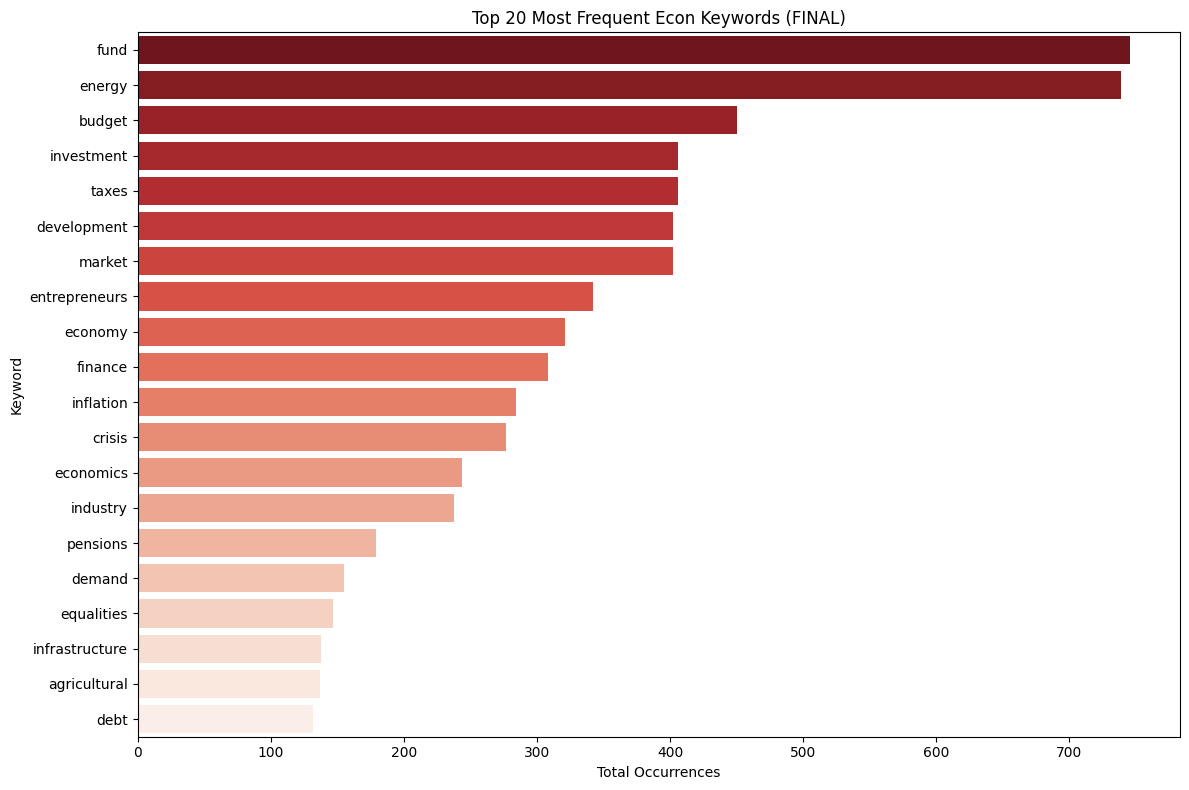

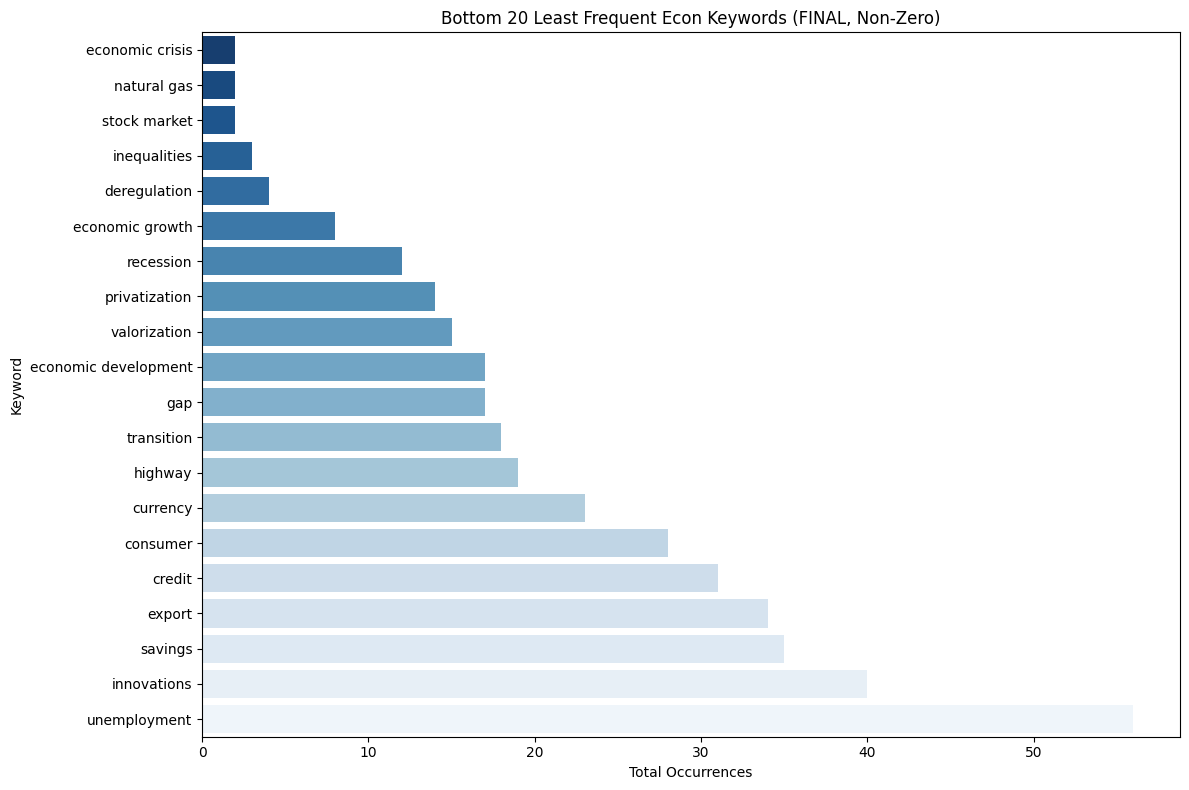

--------------------------------------------------



----- Comparison of FINAL Method with Previous Methods -----
Comparing 'has_econ_term_FILTERED' (after final filtering) with: has_exact_econ_word_naive, has_exact_econ_word_regex, has_exact_econ_word_flashtext, has_exact_econ_word_ac

Total Flagged by FINAL Method (has_econ_term_FILTERED): 6089

--- Comparing with: has_exact_econ_word_naive ---
Total Flagged by 'has_exact_econ_word_naive' (in remaining data): 3617
Tweets Flagged by BOTH 'has_exact_econ_word_naive' AND 'has_econ_term_FILTERED': 3502
Agreement: 96.82% of remaining 'has_exact_econ_word_naive' tweets also flagged by 'has_econ_term_FILTERED'.
Agreement: 57.51% of 'has_econ_term_FILTERED' tweets also flagged by 'has_exact_econ_word_naive'.

--- Comparing with: has_exact_econ_word_regex ---
Total Flagged by 'has_exact_econ_word_regex' (in remaining data): 5030
Tweets Flagged by BOTH 'has_exact_econ_word_regex' AND 'has_econ_term_FILTERED': 4886
Agreement: 97.14% of remaini

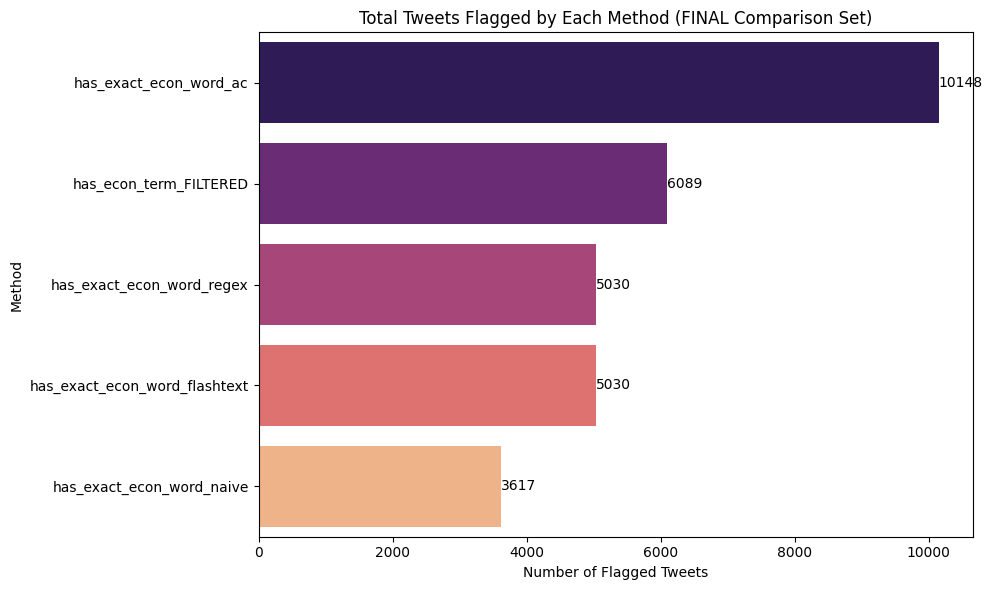


Comparison Summary Table (FINAL vs Previous):


Method  Total Flags (Method)  Total Flags (FINAL)  \
0      has_exact_econ_word_naive                  3617                 6089   
1      has_exact_econ_word_regex                  5030                 6089   
2  has_exact_econ_word_flashtext                  5030                 6089   
3         has_exact_econ_word_ac                 10148                 6089   

   Flags in Both  % of has_exact_econ_word_naive in FINAL  \
0           3502                                    96.82   
1           4886                                      NaN   
2           4886                                      NaN   
3           5745                                      NaN   

   % of FINAL in has_exact_econ_word_naive  \
0                                    57.51   
1                                      NaN   
2                                      NaN   
3                                      NaN   

   % of has_exact_econ_word_regex in FINAL  \
0                                      NaN   
1                                    97.14   
2                                      NaN   
3                                      NaN   

   % of FINAL in has_exact_econ_word_regex  \
0                                      NaN   
1                                    80.24   
2                                      NaN   
3                                      NaN   

   % of has_exact_econ_word_flashtext in FINAL  \
0                                          NaN   
1                                          NaN   
2                                        97.14   
3                                          NaN   

   % of FINAL in has_exact_econ_word_flashtext  \
0                                          NaN   
1                                          NaN   
2                                        80.24   
3                                          NaN   

   % of has_exact_econ_word_ac in FINAL  % of FINAL in has_exact_econ_word_ac  
0                                   NaN                                   NaN  
1                                   NaN                                   NaN  
2                                   NaN                                   NaN  
3                                 56.61                                 94.35


--------------------------------------------------




In [29]:
# ==============================================================================
# Script Summary
# ==============================================================================
# This script performs the following steps:
# 1.  SETUP: Loads models, keywords, data, and prepares helper dictionaries/automata.
# 2.  DEFINE EXTRACTION FUNCTIONS: Defines an original lemma/MWE keyword extraction
#     function and a refined version incorporating NER/POS contextual filtering.
# 3.  APPLY ORIGINAL EXTRACTION: Runs the original function on the dataset, storing
#     results (matched keywords, boolean flag) with an '_ORIG' suffix.
# 4.  APPLY REFINED EXTRACTION: Runs the refined function, storing its results
#     (extracted terms, matched keywords, boolean flag) with a '_FILTERED' suffix.
# 5.  COMPARE EXTRACTIONS: Compares the flagged counts and shows examples of
#     differences between the original and refined keyword extraction methods.
# 6.  FINAL FILTERING: Identifies and REMOVES rows from the main DataFrame
#     (`df_clean_translated`) where the *only* keywords found by the refined
#     method were 'equality' or 'inequalities'. All subsequent analyses use
#     this modified DataFrame.
# 7.  TIME PERIOD ANALYSIS: Compares the count and percentage of finally flagged
#     economic tweets across two defined time periods.
# 8.  KEYWORD POPULARITY ANALYSIS: Calculates and visualizes the frequency of
#     each economic keyword found by the final refined method across all flagged tweets.
# 9.  COMPARISON WITH PREVIOUS EXACT METHODS: Compares the final refined flagging
#     results against four earlier exact-match methods (Naive, Regex, FlashText, Aho-Corasick),
#     showing total counts and agreement percentages.
# 10. SPECIFIC KEYWORD CHECK: Allows for focused examination of tweets containing
#     user-defined specific keywords (e.g., 'equality', 'inequalities' to verify
#     the effect of filtering) based on the final refined results.
# 11. DIFFERENCE ANALYSIS (Refined vs. Exact): For each of the four exact-match
#     methods, this step identifies and displays sample tweets where the final refined
#     method's flagging decision differs. It also analyzes the keywords most
#     frequently found by the refined method in cases where it flagged a tweet
#     but the specific exact method did not.
# ==============================================================================

import spacy
import ahocorasick
import pandas as pd
from collections import defaultdict, Counter
import os # Needed for file checks
import random # Needed for sampling
# Import tqdm for the progress bar
from tqdm.auto import tqdm # auto selects notebook or console version
# Import libraries for analysis and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==============================================================================
# 1. SETUP
# ==============================================================================
print("=" * 50)
print("----- Setup Stage -----")
print("=" * 50)
print()

# --- Load spaCy Model ---
try:
    nlp = spacy.load("en_core_web_lg")
    print("Loaded spaCy model: en_core_web_lg")
except OSError:
    print("Trying medium model 'en_core_web_md'...")
    try: nlp = spacy.load("en_core_web_md"); print("Loaded spaCy model: en_core_web_md")
    except OSError:
        print("Trying small model 'en_core_web_sm'...")
        try: nlp = spacy.load("en_core_web_sm"); print("Loaded spaCy model: en_core_web_sm")
        except OSError:
            print("ERROR: No English spaCy model found. Install one: python -m spacy download en_core_web_lg (or md/sm)"); raise RuntimeError("spaCy model loading failed.")

# !!!!!!!!!!!!!!!!!!!! D O U B L E C H E C K !!!!!!!!!!!!!!!!!!!!!!!
# !!! ENSURE 'economic_words_list' IS DEFINED BEFORE THIS SCRIPT !!!
if 'economic_words_list' not in globals():
     raise NameError("'economic_words_list' is not defined. Please define it above this script.")

print(f"Using economic keyword list with {len(economic_words_list)} items.")

# --- Separate Single Words and MWEs ---
single_words = []
multi_word_expressions = []
for word in economic_words_list:
    if ' ' in word or '-' in word: multi_word_expressions.append(word)
    else: single_words.append(word)
print(f"Separated into {len(single_words)} single words and {len(multi_word_expressions)} MWEs.")

# --- Lemmatize Target Single Words (English) ---
target_lemmas = defaultdict(list)
if nlp:
    print("Lemmatizing target single words...")
    for word in single_words:
        doc = nlp(word.lower())
        if len(doc) > 0: target_lemmas[doc[0].lemma_].append(word) # Map lemma to original word(s)
    print(f"Target lemmas created: {len(target_lemmas)} unique lemmas.")
else:
    print("CRITICAL ERROR: spaCy model not loaded.") # Should be caught above

# --- Build Aho-Corasick Automaton for MWEs (English) ---
A_mwe = ahocorasick.Automaton()
print("Building Aho-Corasick automaton for MWEs...")
for mwe in multi_word_expressions: A_mwe.add_word(mwe.lower(), (mwe, 'mwe'))
A_mwe.make_automaton()
print(f"Aho-Corasick automaton built.")

# --- Ensure DataFrame Exists ---
# !!! ENSURE 'df_clean_translated' IS LOADED AND AVAILABLE !!! -> for the sake of not matching dataset names due to changes introduced
if 'df_clean_translated' not in globals(): raise NameError("'df_clean_translated' DataFrame not defined.")
else: print(f"Using DataFrame 'df_clean_translated' with {len(df_clean_translated)} rows.")

# --- Ensure Text Column Exists ---
text_column = 'text_clean_en' # Ensure this is your correct text column
if text_column not in df_clean_translated.columns:
    raise KeyError(f"Text column '{text_column}' not found in DataFrame. Available: {df_clean_translated.columns.tolist()}")

print()
print("-" * 50)
print("----> Setup Complete <----")
print("-" * 50)
print()
print()


# ==============================================================================
# 2. DEFINE EXTRACTION FUNCTIONS
# ==============================================================================
print()
print("=" * 50)
print("----- Defining Extraction Functions -----")
print("=" * 50)

# --- Function 2a: Original Lemma + MWE Extraction ---
def extract_economic_terms_lemma_mwe_en(text, nlp_model, mwe_automaton, target_lemma_dict):
    """ ORIGINAL: Extracts terms based on lemmatization and MWE matching. """
    if pd.isna(text) or not nlp_model: return [], set()
    found_original_terms = set()
    matched_base_keywords = set()
    text_lower = text.lower()
    mwe_match_indices = set()
    mwe_hits = []
    for end_index, (original_mwe, type_tag) in mwe_automaton.iter(text_lower):
        start_index = end_index - len(original_mwe) + 1
        mwe_hits.append({'mwe': original_mwe, 'start': start_index, 'end': end_index, 'matched_text': text_lower[start_index:end_index+1]})
        for i in range(start_index, end_index + 1): mwe_match_indices.add(i)
    for hit in mwe_hits:
         matched_base_keywords.add(hit['mwe'])
         found_original_terms.add(hit['matched_text'])
    doc = nlp_model(text)
    for token in doc:
        token_start_char, token_end_char = token.idx, token.idx + len(token.text)
        token_char_indices = set(range(token_start_char, token_end_char))
        if not token_char_indices.isdisjoint(mwe_match_indices): continue # Skip if part of MWE

        token_lemma = token.lemma_.lower()
        if token_lemma in target_lemma_dict:
            found_original_terms.add(token.text)
            for base_keyword in target_lemma_dict[token_lemma]: matched_base_keywords.add(base_keyword)
    return list(found_original_terms), matched_base_keywords # Fixed commented return

# --- Function 2b: Refined Extraction with NER/POS Filters ---

# Define known non-economic entities containing keywords to ignore
# !!! CHANGE LIST IF NECESSARY !!!
NON_ECONOMIC_ORG_ENTITIES = {
    'europarlament', 'european parliament', 'europol',
}

# Define POS tags to keep for ambiguous words 
# !!! HANGE LIST IF NECESSARY !!!
# Common Universal POS tags: NOUN, PROPN (Proper Noun), VERB, ADJ (Adjective), ADV (Adverb), SYM (Symbol)
RELEVANT_POS_TAGS = {
    # Nouns vs Verbs
    'bank':         {'NOUN', 'PROPN'},
    'market':       {'NOUN', 'PROPN'},
    'trade':        {'NOUN', 'PROPN'},
    'fund':         {'NOUN', 'PROPN', 'VERB'}, # Keep VERB based on previous finding
    'finance':      {'NOUN', 'PROPN', 'VERB'}, # Keep VERB based on previous finding
    'credit':       {'NOUN'},
    'demand':       {'NOUN'},
    'supply':       {'NOUN'},
    'export':       {'NOUN', 'VERB'}, # UPDATED: Allow VERB 'to export'/'exporting'
    'import':       {'NOUN', 'VERB'}, # UPDATED: Allow VERB 'to import'/'importing'
    'investment':   {'NOUN'},
    'development':  {'NOUN'},
    'savings':      {'NOUN'},
    'tax':          {'NOUN'},
    'pension':      {'NOUN', 'PROPN'},
    'growth':       {'NOUN'},

    # Specific Cases
    'equality':     {'NOUN'},
    'inequalities': {'NOUN'},
    'euro':         {'PROPN', 'NOUN'},
    'crisis':       {'NOUN'},

}

def extract_economic_terms_filtered(text, nlp_model, mwe_automaton, target_lemma_dict):
    """ REFINED: Extracts terms using Lemma+MWE + NER/POS context filters. """
    if pd.isna(text) or not nlp_model: return [], set()
    found_original_terms = set()
    matched_base_keywords = set()
    text_lower = text.lower()

    # 1. Find MWEs
    mwe_match_indices = set()
    mwe_hits = []
    for end_index, (original_mwe, type_tag) in mwe_automaton.iter(text_lower):
        start_index = end_index - len(original_mwe) + 1
        mwe_hits.append({'mwe': original_mwe, 'start': start_index, 'end': end_index, 'matched_text': text_lower[start_index:end_index+1]})
        for i in range(start_index, end_index + 1): mwe_match_indices.add(i)
    for hit in mwe_hits:
         matched_base_keywords.add(hit['mwe'])
         found_original_terms.add(hit['matched_text'])

    # 2. Process with spaCy
    doc = nlp_model(text)

    # --- Pre-calculate indices covered by unwanted entities ---
    unwanted_entity_char_indices = set()
    for ent in doc.ents:
        if ent.label_ == 'ORG' and ent.text.lower() in NON_ECONOMIC_ORG_ENTITIES:
            for i in range(ent.start_char, ent.end_char): unwanted_entity_char_indices.add(i)
        # Add more entity checks if needed

    # 3. Find single-word lemma matches WITH context checks
    for token in doc:
        token_start_char, token_end_char = token.idx, token.idx + len(token.text)
        token_char_indices = set(range(token_start_char, token_end_char))

        # --- CONTEXT CHECKS ---
        ignore_match = False
        # a) Check MWE Overlap
        if not token_char_indices.isdisjoint(mwe_match_indices): continue # Skip if part of MWE
        # b) Check Unwanted Entity Overlap
        if not token_char_indices.isdisjoint(unwanted_entity_char_indices): ignore_match = True
        # c) Check POS
        token_lemma = token.lemma_.lower()
        if not ignore_match and token_lemma in RELEVANT_POS_TAGS:
            if token.pos_ not in RELEVANT_POS_TAGS[token_lemma]: ignore_match = True
        # --- END CONTEXT CHECKS ---

        if not ignore_match and token_lemma in target_lemma_dict:
            found_original_terms.add(token.text)
            for base_keyword in target_lemma_dict[token_lemma]: matched_base_keywords.add(base_keyword)

    return list(found_original_terms), matched_base_keywords

# --- Function 2c: Helper for Difference Analysis (defined once) ---
def check_term_match_difference(row):
    """ Compares sets of extracted vs matched keywords for difference analysis. """
    # Expects a dictionary-like row with 'extracted_terms_en' and 'matched_keywords_en' keys
    try:
        extracted = set(t.lower() for t in row['extracted_terms_en'] if isinstance(t, str))
        matched = set(k.lower() for k in row['matched_keywords_en'] if isinstance(k, str))
        return extracted != matched
    except Exception:
        return None # Handle errors

print()
print("-" * 50)
print("----> Extraction functions defined. <----")
print("-" * 50)
print()
print()


# ==============================================================================
# 3. APPLY **ORIGINAL** EXTRACTION TO DATAFRAME
# ==============================================================================
print()
print("=" * 80)
print("----- Applying ORIGINAL Term Extraction (Lemma + MWE) -----")
print("=" * 80)

tqdm.pandas(desc="Extracting Original Terms")
results_orig = df_clean_translated[text_column].progress_apply(
    lambda text: extract_economic_terms_lemma_mwe_en(text, nlp, A_mwe, target_lemmas)
)
# Store original matched keywords and flag
df_clean_translated['matched_keywords_ORIG'] = results_orig.apply(lambda x: list(x[1]))
df_clean_translated['has_econ_term_ORIG'] = df_clean_translated['matched_keywords_ORIG'].apply(lambda x: len(x) > 0)
num_flagged_orig = df_clean_translated['has_econ_term_ORIG'].sum()
total_rows_orig = len(df_clean_translated)
print(f"ORIGINAL method flagged: {num_flagged_orig} tweets ({num_flagged_orig/total_rows_orig:.2%})")
print()
print("-" * 50)
print("----> Original Term Extraction Complete <----")
print("-" * 50)
print()
print()


# ==============================================================================
# 4. APPLY **REFINED** EXTRACTION TO DATAFRAME
# ==============================================================================
print()
print("=" * 50)
print("----- Applying REFINED Term Extraction (Lemma + MWE + Filters) -----")
print("=" * 50)

tqdm.pandas(desc="Extracting Refined Terms")
results_filtered = df_clean_translated[text_column].progress_apply(
    lambda text: extract_economic_terms_filtered(text, nlp, A_mwe, target_lemmas)
)
# Store refined extracted terms, matched keywords, and flag
df_clean_translated['extracted_terms_FILTERED'] = results_filtered.apply(lambda x: x[0])
df_clean_translated['matched_keywords_FILTERED'] = results_filtered.apply(lambda x: list(x[1]))
df_clean_translated['has_econ_term_FILTERED'] = df_clean_translated['matched_keywords_FILTERED'].apply(lambda x: len(x) > 0)
num_flagged_filtered = df_clean_translated['has_econ_term_FILTERED'].sum()
total_rows_filtered = len(df_clean_translated)
print(f"REFINED method flagged:  {num_flagged_filtered} tweets ({num_flagged_filtered/total_rows_filtered:.2%})")

print()
print("-" * 50)
print("----> Refined Term Extraction Complete <----")
print("-" * 50)
print()
print()


# ==============================================================================
# 5. COMPARE ORIGINAL vs. REFINED EXTRACTION RESULTS
# ==============================================================================
print()
print("=" * 50)
print("----- Comparing Original vs. Refined Extraction Method -----")
print("=" * 50)
print() 

orig_flag_col = 'has_econ_term_ORIG'
filt_flag_col = 'has_econ_term_FILTERED'
orig_kw_col = 'matched_keywords_ORIG'
filt_kw_col = 'matched_keywords_FILTERED'
text_col = 'text_clean_en'

missing_compare_cols = [c for c in [orig_flag_col, filt_flag_col, orig_kw_col, filt_kw_col, text_col] if c not in df_clean_translated.columns]
if missing_compare_cols:
    print(f"ERROR: Missing columns needed for comparison: {missing_compare_cols}. Skipping.")
else:
    num_flagged_orig_comp = df_clean_translated[orig_flag_col].sum() # Recalc or use previous
    num_flagged_filtered_comp = df_clean_translated[filt_flag_col].sum() # Recalc or use previous
    num_removed = num_flagged_orig_comp - num_flagged_filtered_comp
    perc_removed = (num_removed / num_flagged_orig_comp * 100) if num_flagged_orig_comp > 0 else 0
    print(f"Original Method flagged: {num_flagged_orig_comp} tweets")
    print(f"Refined Method flagged:  {num_flagged_filtered_comp} tweets")
    print(f"Tweets removed by NER/POS filtering: {num_removed} ({perc_removed:.2f}% of original)")
    print("-" * 50)
    both_flagged = df_clean_translated[df_clean_translated[orig_flag_col] & df_clean_translated[filt_flag_col]].shape[0]
    orig_only = df_clean_translated[df_clean_translated[orig_flag_col] & ~df_clean_translated[filt_flag_col]].shape[0]
    filt_only = df_clean_translated[~df_clean_translated[orig_flag_col] & df_clean_translated[filt_flag_col]].shape[0]
    print("Overlap Analysis:")
    print(f"- Flagged by Both: {both_flagged}")
    print(f"- Flagged by Original ONLY (Removed by NER/POS Filter): {orig_only}")
    print(f"- Flagged by Filtered ONLY (Added by Filter?): {filt_only}") # Should be 0
    print("-" * 50)
    if orig_only > 0:
        print(f"\nShowing up to 200 examples of tweets REMOVED by NER/POS filtering:")
        df_removed = df_clean_translated[df_clean_translated[orig_flag_col] & ~df_clean_translated[filt_flag_col]].copy()
        cols_to_show = [text_col, orig_kw_col, filt_kw_col]
        if 'id' in df_clean_translated.columns: cols_to_show.insert(0, 'id') 
        try: display(df_removed[cols_to_show].head(200))
        except NameError: print(df_removed[cols_to_show].head(200).to_string())
    else: print("\nNo tweets were removed by the NER/POS filtering process.")


# ==============================================================================
# 6. FINAL FILTERING: Remove rows containing ONLY 'equality'/'inequalities' as these tweets were manually checked and it was found out that they are not relvevant to the ecnomic topics; they are related to the social equality issues 
# ==============================================================================
print()
print("=" * 50)
print("----- Final Filtering: Removing 'equality'/'inequalities'-only tweets -----")
print("=" * 50)

keywords_to_check_alone = {'equality', 'inequalities'}
refined_flag_col_ff = 'has_econ_term_FILTERED' # Input flag
refined_kw_col_ff = 'matched_keywords_FILTERED' # Input keywords

if refined_flag_col_ff not in df_clean_translated.columns or refined_kw_col_ff not in df_clean_translated.columns:
    print(f"ERROR: Required columns ('{refined_flag_col_ff}', '{refined_kw_col_ff}') not found. Skipping removal.")
else:
    def contains_only_target(keyword_list):
        if not isinstance(keyword_list, list) or not keyword_list: return False
        return all(kw in keywords_to_check_alone for kw in keyword_list)
    rows_to_remove_mask = (
        df_clean_translated[refined_flag_col_ff] &
        df_clean_translated[refined_kw_col_ff].apply(contains_only_target)
    )
    indices_to_remove = df_clean_translated[rows_to_remove_mask].index
    num_rows_to_remove = len(indices_to_remove)
    total_rows_before = len(df_clean_translated)
    num_flagged_filtered_before_ff = df_clean_translated[refined_flag_col_ff].sum()
    print(f"\nStats BEFORE removal:")
    print(f"- Total rows: {total_rows_before}")
    print(f"- Rows flagged by refined method: {num_flagged_filtered_before_ff}")
    print(f"- Rows identified for removal (flagged with only {keywords_to_check_alone}): {num_rows_to_remove}")
    if num_rows_to_remove > 0:
        print(f"\nRemoving {num_rows_to_remove} rows from 'df_clean_translated' IN PLACE...")
        df_clean_translated.drop(index=indices_to_remove, inplace=True) # Modify inplace
        print("Rows removed.")
        # Optional: Reset index after dropping
        # df_clean_translated.reset_index(drop=True, inplace=True)
    else: print("\nNo rows met the criteria for removal.")
    total_rows_after = len(df_clean_translated)
    num_flagged_after_removal = df_clean_translated[refined_flag_col_ff].sum() # Flag count on modified DF
    print(f"\nStats AFTER removal (in modified 'df_clean_translated'):")
    print(f"- Total rows remaining: {total_rows_after}")
    print(f"- Rows flagged by refined method remaining: {num_flagged_after_removal}")

print()
print("-" * 50)
print()
print()


# ==============================================================================
# 7. TIME PERIOD ANALYSIS (Using FINAL Results)
# ==============================================================================
print()
print("=" * 50)
print("----- Time Period Analysis (Based on FINAL Flags) -----")
print("=" * 50)

date_column = 'created_at'
# Use the flag column that reflects the state *after* the inplace drop
flag_column_name_for_analysis = 'has_econ_term_FILTERED'

if date_column not in df_clean_translated.columns:
    print(f"ERROR: Date column '{date_column}' not found. Skipping time analysis.")
    print(f"       Available columns: {df_clean_translated.columns.tolist()}")
elif flag_column_name_for_analysis not in df_clean_translated.columns:
    print(f"ERROR: Flag column '{flag_column_name_for_analysis}' not found. Skipping time analysis.")
else:
    print(f"Using date column: '{date_column}'")
    print(f"Using flag column: '{flag_column_name_for_analysis}' (Reflects data after final filtering)")
    try:
        # Operate on a copy for safety if date conversion drops rows
        df_temp_time = df_clean_translated.copy()
        df_temp_time[date_column] = pd.to_datetime(df_temp_time[date_column], errors='coerce')
        initial_rows = len(df_temp_time)
        df_temp_time.dropna(subset=[date_column], inplace=True)
        rows_dropped = initial_rows - len(df_temp_time)
        if rows_dropped > 0: print(f"Dropped {rows_dropped} rows due to invalid date format for this analysis.")

        start_date_p1=pd.Timestamp("2022-10-15"); end_date_p1=pd.Timestamp("2023-10-15")
        start_date_p2=pd.Timestamp("2023-10-16"); end_date_p2=df_temp_time[date_column].max()
        print(f"Period 1: {start_date_p1.date()} to {end_date_p1.date()}")
        print(f"Period 2: {start_date_p2.date()} to {end_date_p2.date()}")
        df_period1 = df_temp_time[(df_temp_time[date_column] >= start_date_p1) & (df_temp_time[date_column] <= end_date_p1)].copy()
        df_period2 = df_temp_time[(df_temp_time[date_column] >= start_date_p2) & (df_temp_time[date_column] <= end_date_p2)].copy()
        if df_period1.empty or df_period2.empty: print("WARNING: One or both time periods resulted in empty DataFrames.")
        else:
            flagged_p1 = df_period1[flag_column_name_for_analysis].sum(); total_p1 = len(df_period1)
            flagged_p2 = df_period2[flag_column_name_for_analysis].sum(); total_p2 = len(df_period2)
            print("\nComparison of FINAL Flagged Tweets:")
            print(f"Period 1: {flagged_p1} flagged out of {total_p1} total ({flagged_p1/total_p1:.2% if total_p1 > 0 else 0})")
            print(f"Period 2: {flagged_p2} flagged out of {total_p2} total ({flagged_p2/total_p2:.2% if total_p2 > 0 else 0})")
    except Exception as e: print(f"An error occurred during date processing or filtering: {e}")

print()
print("-" * 50)
print()
print()


# ==============================================================================
# 8. KEYWORD POPULARITY ANALYSIS (Using FINAL Results)
# ==============================================================================
print()
print("=" * 50)
print("----- Keyword Popularity Analysis (Based on FINAL Results) -----")
print("Note: Keyword frequency counts TOTAL occurrences.")
print("=" * 50)

# Use the flag and keyword columns reflecting the state *after* inplace drop
final_flag_col = 'has_econ_term_FILTERED'
final_kw_col = 'matched_keywords_FILTERED'

if final_flag_col not in df_clean_translated.columns or final_kw_col not in df_clean_translated.columns:
    print(f"ERROR: Columns ('{final_flag_col}', '{final_kw_col}') not found. Skipping popularity analysis.")
else:
    keywords_to_remove_pop = {'equality', 'inequalities'} # Define again for safety
    all_base_keywords_from_list_final = set(multi_word_expressions)
    for lemma, original_words in target_lemmas.items():
        if original_words and original_words[0] not in keywords_to_remove_pop:
            all_base_keywords_from_list_final.add(original_words[0])
    print(f"Analyzing frequency based on {len(all_base_keywords_from_list_final)} unique base keywords (excluding filtered).")
    keyword_counts_all_final = Counter({keyword: 0 for keyword in all_base_keywords_from_list_final})
    actual_matched_keywords_final = [
        keyword for sublist in df_clean_translated.loc[df_clean_translated[final_flag_col], final_kw_col]
        if isinstance(sublist, list) for keyword in sublist
    ]
    if not actual_matched_keywords_final:
        print("No keywords remained after final filtering. Skipping popularity analysis.")
    else:
        actual_counts_final = Counter(actual_matched_keywords_final)
        keyword_counts_all_final.update(actual_counts_final)
        df_keyword_counts_final = pd.DataFrame(keyword_counts_all_final.items(), columns=['Keyword', 'Frequency'])
        df_keyword_counts_final = df_keyword_counts_final.sort_values(by=['Frequency', 'Keyword'], ascending=[False, True])
        print("Keyword Frequencies (FINAL Method):")
        print(df_keyword_counts_final.head(10))
        print("..."); print(df_keyword_counts_final.tail(10))
        num_keywords_to_plot = 20
        df_non_zero_counts_final = df_keyword_counts_final[df_keyword_counts_final['Frequency'] > 0].copy()
        df_non_zero_counts_sorted_asc_final = df_non_zero_counts_final.sort_values(by=['Frequency', 'Keyword'], ascending=[True, True])
        if not df_non_zero_counts_final.empty:
            plt.figure(figsize=(12, 8)); top_keywords_to_plot = df_keyword_counts_final.head(num_keywords_to_plot)
            sns.barplot(data=top_keywords_to_plot, y='Keyword', x='Frequency', palette='Reds_r', hue = 'Keyword')
            plt.title(f'Top {min(num_keywords_to_plot, len(df_keyword_counts_final))} Most Frequent Econ Keywords (FINAL)')
            plt.xlabel('Total Occurrences'); plt.ylabel('Keyword'); plt.tight_layout(); plt.show()
            if len(df_non_zero_counts_final) > 1:
                plt.figure(figsize=(12, 8)); bottom_keywords_to_plot = df_non_zero_counts_sorted_asc_final.head(num_keywords_to_plot)
                sns.barplot(data=bottom_keywords_to_plot, y='Keyword', x='Frequency', palette='Blues_r', hue = 'Keyword')
                plt.title(f'Bottom {min(num_keywords_to_plot, len(df_non_zero_counts_final))} Least Frequent Econ Keywords (FINAL, Non-Zero)')
                plt.xlabel('Total Occurrences'); plt.ylabel('Keyword'); plt.tight_layout(); plt.show()
            elif len(df_non_zero_counts_final) == 1: print("\nOnly one keyword category had non-zero frequency (FINAL method).")
        else: print("No non-zero keyword counts to visualize (FINAL method).")

print("-" * 50)
print()
print()


# ==============================================================================
# 9. COMPARISON WITH PREVIOUS METHODS (Naive, Regex, etc.) (Using FINAL Results)
# ==============================================================================
print()
print("=" * 50)
print("----- Comparison of FINAL Method with Previous Methods -----")
print("=" * 50)

flag_cols_to_compare = [
    'has_exact_econ_word_naive', 'has_exact_econ_word_regex',
    'has_exact_econ_word_flashtext', 'has_exact_econ_word_ac'
]
# Use the flag column reflecting state *after* inplace drop
final_method_flag = 'has_econ_term_FILTERED'
all_compare_cols = flag_cols_to_compare + [final_method_flag]
missing_cols = [col for col in all_compare_cols if col not in df_clean_translated.columns]
if missing_cols:
    print(f"ERROR: Required flag columns missing: {missing_cols}. Skipping comparison.")
else:
    print(f"Comparing '{final_method_flag}' (after final filtering) with: {', '.join(flag_cols_to_compare)}")
    comparison_results_final = []
    final_method_total = df_clean_translated[final_method_flag].sum() # Count on modified DF
    print(f"\nTotal Flagged by FINAL Method ({final_method_flag}): {final_method_total}\n")
    comparison_summary_final = {final_method_flag: final_method_total}
    for method_flag in flag_cols_to_compare:
        # IMPORTANT: Compare against counts from the *modified* df_clean_translated
        # If the naive/regex flags were calculated *before* the drop, the comparison % might be slightly off
        if method_flag not in df_clean_translated.columns:
            print(f"Warning: Column {method_flag} not found in final dataframe, skipping comparison for it.")
            continue
        other_method_total = df_clean_translated[method_flag].sum() # Count remaining naive/etc flags
        comparison_summary_final[method_flag] = other_method_total
        both_flagged = df_clean_translated[df_clean_translated[method_flag] & df_clean_translated[final_method_flag]].shape[0]
        perc_other_in_final = (both_flagged / other_method_total * 100) if other_method_total > 0 else 0
        perc_final_in_other = (both_flagged / final_method_total * 100) if final_method_total > 0 else 0
        print(f"--- Comparing with: {method_flag} ---")
        print(f"Total Flagged by '{method_flag}' (in remaining data): {other_method_total}")
        print(f"Tweets Flagged by BOTH '{method_flag}' AND '{final_method_flag}': {both_flagged}")
        print(f"Agreement: {perc_other_in_final:.2f}% of remaining '{method_flag}' tweets also flagged by '{final_method_flag}'.")
        print(f"Agreement: {perc_final_in_other:.2f}% of '{final_method_flag}' tweets also flagged by '{method_flag}'.\n")
        comparison_results_final.append({
            'Method': method_flag, 'Total Flags (Method)': other_method_total,
            'Total Flags (FINAL)': final_method_total, 'Flags in Both': both_flagged,
            f'% of {method_flag} in FINAL': perc_other_in_final, f'% of FINAL in {method_flag}': perc_final_in_other
        })
    if comparison_summary_final:
        df_summary = pd.DataFrame(list(comparison_summary_final.items()), columns=['Method', 'Total Flagged Tweets'])
        df_summary = df_summary.sort_values(by='Total Flagged Tweets', ascending=False)
        plt.figure(figsize=(10, 6)); barplot = sns.barplot(data=df_summary, y='Method', x='Total Flagged Tweets', palette='magma', hue='Method')
        plt.title('Total Tweets Flagged by Each Method (FINAL Comparison Set)')
        plt.xlabel('Number of Flagged Tweets'); plt.ylabel('Method')
        for i in barplot.containers: barplot.bar_label(i,)
        plt.tight_layout(); plt.show()
    if comparison_results_final:
        df_comparison_table = pd.DataFrame(comparison_results_final)
        print("\nComparison Summary Table (FINAL vs Previous):")
        try: display(df_comparison_table.round(2))
        except NameError: print(df_comparison_table.round(2).to_string())

print()
print("-" * 50)
print()
print()

In [30]:
# # DEBUGGING: Check specific tweet examples and theiir tokenization details 
# print("--- Debugging Tweet 8654 ---")
# text_8654 = "RECEIPTS OF Terror are PiS's fault ❗ ️  Taxes may be lower and therefore prices may also be lower.  will make it happen!  ✅️"
# doc_8654 = nlp(text_8654)
# print(f"Processing text: '{text_8654}'")
# print("Token Details (Text, Lemma, POS, Fine-grained Tag, Entity Type):")
# for token in doc_8654:
#     print(f"- {token.text:<15} {token.lemma_:<15} {token.pos_:<7} {token.tag_:<5} {token.ent_type_}")
# print("-" * 30)

In [31]:
text_pensions = "INHERITANCE OF PENSIONS"
doc = nlp(text_pensions)
print([(t.text, t.lemma_, t.pos_, t.tag_, t.ent_type_) for t in doc if t.text.upper() == 'PENSIONS'])

[('PENSIONS', 'PENSIONS', 'PROPN', 'NNPS', '')]


In [32]:
df_clean_translated

created_at  \
0     2024-10-15 19:49:34+00:00   
1     2024-10-15 16:12:19+00:00   
2     2024-10-15 12:09:12+00:00   
3     2024-10-15 07:32:44+00:00   
4     2024-10-15 06:27:14+00:00   
...                         ...   
48326 2023-09-29 11:30:44+00:00   
48327 2023-09-19 13:08:40+00:00   
48328 2023-09-15 12:59:29+00:00   
48329 2023-09-13 14:07:56+00:00   
48330 2023-09-12 14:39:09+00:00   

                                                    text                   id  \
0      @donaldtusk Niezrealizowanie większości ze "10...  1846277256509116672   
1      Rok po wyborach trzeba powiedzieć jedno - nie ...  1846222583898784000   
2       ❌ Mamy rok po wyborach, a Polska pogrąża się ...  1846161400328028160   
3      Mija rok od wyborów parlamentarnych. W kampani...  1846091824101769472   
4                  #Idę11  🇵  🇱  https://t.co/KiCe5ATOpX  1846075343188144128   
...                                                  ...                  ...   
48326  Studiujesz na kierunku lekarskim, pielęgniarst...  1707719554355380480   
48327  Za nami posiedzenie @SejmikMaz. I kolejne wspa...  1704120323023454464   
48328  Płockie Centrum Onkologii gotowe! Już na począ...  1702668459576786944   
48329  To jedna z największych inwestycji drogowych @...  1701960909369868544   
48330  Powiaty mają 25 lat ❗ ️Na @Zamek_Krolewski odb...  1701606379709198336   

          author_id                                      edit_controls  \
0      1.182212e+09  {'editable_until': '2024-10-15 20:49:34+00:00'...   
1      1.182212e+09  {'editable_until': '2024-10-15 17:12:19+00:00'...   
2      1.182212e+09  {'editable_until': '2024-10-15 13:09:12+00:00'...   
3      1.182212e+09  {'editable_until': '2024-10-15 08:32:44+00:00'...   
4      1.182212e+09  {'editable_until': '2024-10-15 07:27:14+00:00'...   
...             ...                                                ...   
48326  9.611819e+08  {'editable_until': '2023-09-29 12:30:44+00:00'...   
48327  9.611819e+08  {'editable_until': '2023-09-19 14:08:40+00:00'...   
48328  9.611819e+08  {'editable_until': '2023-09-15 13:59:29+00:00'...   
48329  9.611819e+08  {'editable_until': '2023-09-13 15:07:56+00:00'...   
48330  9.611819e+08  {'editable_until': '2023-09-12 15:39:09+00:00'...   

       possibly_sensitive reply_settings lang edit_history_tweet_ids  \
0                   False       everyone   pl  [1846277256509116623]   
1                   False       everyone   pl  [1846222583898784025]   
2                   False       everyone   pl  [1846161400328028272]   
3                   False       everyone   pl  [1846091824101769490]   
4                   False       everyone  qme  [1846075343188144153]   
...                   ...            ...  ...                    ...   
48326               False       everyone   pl  [1707719554355380484]   
48327               False       everyone   pl  [1704120323023454339]   
48328               False       everyone   pl  [1702668459576787064]   
48329               False       everyone   pl  [1701960909369868437]   
48330               False       everyone   pl  [1701606379709198357]   

       conversation_id  ... has_exact_econ_word_regex  \
0         1.846092e+18  ...                     False   
1         1.846223e+18  ...                     False   
2         1.846161e+18  ...                      True   
3         1.846092e+18  ...                     False   
4         1.846075e+18  ...                     False   
...                ...  ...                       ...   
48326     1.707720e+18  ...                     False   
48327     1.704120e+18  ...                     False   
48328     1.702668e+18  ...                     False   
48329     1.701961e+18  ...                     False   
48330     1.701606e+18  ...                     False   

      matched_exact_econ_words_flashtext has_exact_econ_word_flashtext  \
0                                     []                         False   
1                                     []

In [33]:
# ==============================================================================
# 10. ANALYSIS: Focus on Specific Keywords (Using FINAL Results)
# ==============================================================================
print("=" * 90)
print("----- Analysis of Specific Keywords (Based on FINAL Results) -----")
print("=" * 90)

# !!! DEFINE the specific keywords for checking here !!!
target_specific_keywords = ['equalities', 'inequalities'] # Check these again to verify removal, adjust later if needed
final_flag_col_spec = 'has_econ_term_FILTERED' # Flag reflecting state after drop
final_kw_col_spec = 'matched_keywords_FILTERED' # Keywords reflecting state after drop
text_col_display_spec = 'text_clean_en'
id_col_display_spec = 'id' 

if final_flag_col_spec not in df_clean_translated.columns or final_kw_col_spec not in df_clean_translated.columns:
    print(f"ERROR: Columns ('{final_flag_col_spec}', '{final_kw_col_spec}') not found. Skipping analysis.")
else:
    try:
        # Use the modified df_clean_translated
        df_flagged_final_spec = df_clean_translated[df_clean_translated[final_flag_col_spec]].copy()
        mask_contains_target = df_flagged_final_spec[final_kw_col_spec].apply(
            lambda keywords_list: isinstance(keywords_list, list) and any(kw in target_specific_keywords for kw in keywords_list)
        )
        df_target_related_final = df_flagged_final_spec[mask_contains_target]
        num_target_tweets_final = len(df_target_related_final)
        if num_target_tweets_final > 0:
            print(f"\nFound {num_target_tweets_final} unique tweets flagged by '{final_flag_col_spec}'")
            print(f"  that STILL contain at least one of the target keyword(s): {', '.join(target_specific_keywords)}")
            print(f"  (This means they co-occurred with other valid keywords).")
            print(f"\nDisplaying ALL {num_target_tweets_final} tweets containing these keywords:")
            cols_to_display_specific = [text_col_display_spec, 'extracted_terms_FILTERED', final_kw_col_spec]
            if id_col_display_spec in df_clean_translated.columns: cols_to_display_specific.insert(0, id_col_display_spec)
            original_max_rows = pd.get_option('display.max_rows')
            pd.set_option('display.max_rows', num_target_tweets_final + 10)
            try: display(df_target_related_final[cols_to_display_specific])
            except NameError: print(df_target_related_final[cols_to_display_specific].to_string())
            finally: pd.set_option('display.max_rows', original_max_rows)
        else:
            print(f"\nConfirmed: No remaining tweets contain ONLY '{', '.join(target_specific_keywords)}' (or they were removed).")
            print(f"Any remaining instances co-occur with other keywords.")
    except Exception as e: print(f"An error occurred during specific keyword analysis: {e}")
print()
print()


# ==============================================================================
# 11. DIFFERENCE ANALYSIS: Final Method vs. Each Exact Match Method (Show Extracted Terms)
# ==============================================================================
# This section compares the final flagged tweets against EACH match method,
# reports counts, and shows samples including extracted terms.
print("=" * 90)
print("--- Difference Analysis: Final Method vs. Each Exact Match Method ---")
print("=" * 90)

# --- Configuration ---
final_refined_flag = 'has_econ_term_FILTERED' # Flag reflecting state after inplace drop
refined_kw_col = 'matched_keywords_FILTERED' # FINAL Matched Keywords reflecting state after inplace drop
refined_extracted_col = 'extracted_terms_FILTERED' # Extracted terms from Refined step (before equality removal)

exact_match_flags = [
    'has_exact_econ_word_naive', 'has_exact_econ_word_regex',
    'has_exact_econ_word_flashtext', 'has_exact_econ_word_ac'
]
exact_match_kw_cols = [
    'matched_exact_econ_words_naive', 'matched_exact_econ_words_regex',
    'matched_exact_econ_words_flashtext', 'matched_exact_econ_words_ac'
]
text_col_diff = 'text_clean_en'
id_col_diff = 'id' # !!! check if correct !!!
n_sample_rows_to_show = 2000 # Number of sample rows to show (adjust if needed)


# --- Loop through each exact match method for comparison ---
for i, exact_flag in enumerate(exact_match_flags):
    print()
    print("-" * 90)
    print("-"*10 + f" Comparing with: {exact_flag} " + "-"*10)
    print("-" * 90)
    
    exact_kw_col = exact_match_kw_cols[i] if i < len(exact_match_kw_cols) else None
    if exact_kw_col and exact_kw_col not in df_clean_translated.columns:
        print(f"INFO: Exact match keyword column '{exact_kw_col}' not found.")
        exact_kw_col = None

    # Check essential flag columns
    required_cols_loop = [final_refined_flag, exact_flag]
    missing_cols_loop = [c for c in required_cols_loop if c not in df_clean_translated.columns]
    if missing_cols_loop:
        print(f"ERROR: Missing required flag columns: {missing_cols_loop}. Skipping comparison.")
        continue

    # Check optional context columns
    if refined_kw_col not in df_clean_translated.columns:
         print(f"INFO: Refined keyword column '{refined_kw_col}' not found.")
         refined_kw_col = None # Set to None if missing
    if refined_extracted_col not in df_clean_translated.columns:
         print(f"INFO: Refined extracted terms column '{refined_extracted_col}' not found.")
         refined_extracted_col = None # Set to None if missing


    # --- Calculate Disagreement Sets (using the modified df_clean_translated) ---

    # 1. Flagged by FINAL Method, BUT NOT by this Exact Method
    refined_not_exact_mask = (df_clean_translated[final_refined_flag] == True) & (df_clean_translated[exact_flag] == False)
    # Use .loc with mask to avoid potential index issues if rows were dropped
    df_refined_not_exact = df_clean_translated.loc[refined_not_exact_mask].copy()
    count_refined_not_exact = len(df_refined_not_exact)
    print(f"\nTweets flagged by Final Method but NOT by '{exact_flag}': {count_refined_not_exact}")

    if count_refined_not_exact > 0:
        print("   (Indicates gains from lemmatization, MWEs, or filtering differences)")
        print("   Sample (Final=True, Exact=False):")
        # *** MODIFIED cols_to_show ***
        cols_to_show = [text_col_diff]
        if refined_extracted_col: cols_to_show.append(refined_extracted_col) # ADDED Extracted Terms
        if refined_kw_col: cols_to_show.append(refined_kw_col)                # Matched Final Keywords
        if exact_kw_col: cols_to_show.append(exact_kw_col)                   # Exact Matched Keywords
        if id_col_diff in df_clean_translated.columns: cols_to_show.insert(0,id_col_diff)

        # Ensure columns actually exist in the sampled DF before trying to display
        cols_to_display_final = [col for col in cols_to_show if col in df_refined_not_exact.columns]

        try:
            display(df_refined_not_exact[cols_to_display_final].head(n_sample_rows_to_show))
        except NameError:
            print(df_refined_not_exact[cols_to_display_final].head(n_sample_rows_to_show).to_string())

        # Analyze Keywords found by Refined in this subset (using final matched keywords)
        if refined_kw_col and refined_kw_col in df_refined_not_exact.columns: # Check column exists
            keywords_in_diff = [kw for sl in df_refined_not_exact[refined_kw_col] if isinstance(sl, list) for kw in sl]
            if keywords_in_diff:
                keyword_counts_diff = Counter(keywords_in_diff)
                df_keyword_counts_diff = pd.DataFrame(keyword_counts_diff.items(), columns=['Keyword', 'Frequency']).sort_values(by='Frequency', ascending=False)
                print(f"\n   Most Common FINAL Matched Keywords (when '{exact_flag}' missed):") # Clarified label
                try: display(df_keyword_counts_diff.head(10)) # Show top 10
                except NameError: print(df_keyword_counts_diff.head(10).to_string())
            # else: print(f"   No keywords listed in '{refined_kw_col}' for this subset.") # Redundant if count > 0
        # else: print(f"   Cannot analyze keywords: Column '{refined_kw_col}' not found.") # Already checked

    # 2. Flagged by this Exact Method, BUT NOT by FINAL Method
    exact_not_refined_mask = (df_clean_translated[final_refined_flag] == False) & (df_clean_translated[exact_flag] == True)
    df_exact_not_refined = df_clean_translated.loc[exact_not_refined_mask].copy()
    count_exact_not_refined = len(df_exact_not_refined)
    print(f"\nTweets flagged by '{exact_flag}' but NOT by Final Method: {count_exact_not_refined}")

    if count_exact_not_refined > 0:
        print("   (Likely due to NER/POS filters or 'equality'-only removal)")
        print("   Sample (Final=False, Exact=True):")
        # *** MODIFIED cols_to_show ***
        cols_to_show = [text_col_diff]
        if refined_extracted_col: cols_to_show.append(refined_extracted_col) # ADDED Extracted Terms (Context)
        if refined_kw_col: cols_to_show.append(refined_kw_col)                # Matched Final Keywords (likely empty)
        if exact_kw_col: cols_to_show.append(exact_kw_col)                   # Exact Matched Keywords
        if id_col_diff in df_clean_translated.columns: cols_to_show.insert(0,id_col_diff)

        # Ensure columns actually exist in the sampled DF before trying to display
        cols_to_display_final = [col for col in cols_to_show if col in df_exact_not_refined.columns]

        try:
            display(df_exact_not_refined[cols_to_display_final].head(n_sample_rows_to_show))
        except NameError:
            print(df_exact_not_refined[cols_to_display_final].head(n_sample_rows_to_show).to_string())

print()
print()
print("-" * 90)
print("----> Difference Analysis vs. Exact Methods Complete <----")
print("-" * 90)

----- Analysis of Specific Keywords (Based on FINAL Results) -----

Found 149 unique tweets flagged by 'has_econ_term_FILTERED'
  that STILL contain at least one of the target keyword(s): equalities, inequalities
  (This means they co-occurred with other valid keywords).

Displaying ALL 149 tweets containing these keywords:


id                                      text_clean_en  \
1736   1763931255521857792  Equality, but not for everyone...  The "minist...   
1902   1759270467431502080  Behind us, where I gave a lecture entitled "Fr...   
2049   1841742482591384064  This woman is a minister, although she can't g...   
2273   1829142889873740288  First, a lot about women's safety, then even m...   
2564   1817832438472577024  On the one hand, Babiarz, on the other, Kurdej...   
2573   1817152957474861056  Why did the opening of the Olympic Games attac...   
2918   1796899570212819200       Hate speech is when someone dares to crit...   
3036   1792201423792529920   In your opinion, crosses in city offices are ...   
4152   1823686542839239168  Conversation regarding retirement age 👇 🏻   I ...   
5351   1845882584204455936  Rafał Trzaskowski wants to ban the Independenc...   
5992   1733194067029246464  The Ministry of Equality created for the Left ...   
6580   1797226293978632448  On Children's Day, an equality parade took pla...   
7385   1806658921999782144  We can't help but admire the continued commitm...   
7751   1737749989445521920  Yesterday, equality finally happened and in Wi...   
8080   1673048384654000128  The left is the denial of equality. Only our j...   
8789   1650915969097777152  The European Union is fighting for gender equa...   
12029  1812118322948784128                              Equality March Kielce   
12637  1803417688737210368  First meeting with the boss and discussion of ...   
12801  1785611663737082112  Today is an important day #1May, which combine...   
13002  1813910883393007872  .  was elected head of the European Commission...   
13018  1811682878910033920  The priests did not wake up from their sleep a...   
13091  1799463578161799680  Equality  Normality  Love  Understanding  Empa...   
13108  1796895429709160960   🌈 OPOLE 💛    Hundreds of beautiful people, ma...   
13145  1792182077883859456  Thank you for supporting me and . Now it's tim...   
13153  1790991139576611072   Love always wins! The time of equality for al...   
13168  1789302403948261632  Sun, love and music 🏳 ️‍ 🌈   3️⃣ Equality Marc...   
13311  1765995295039455232  Girls! Women! I only wish you one thing. Equal...   
13324  1763876164882296832  Party of European Socialists 🌹   This is my po...   
13345  1758271270053969920  Well done Greece! Same sex marriage passed! Eq...   
13413  1740067255420104960  Time for equality! It's time to realize human ...   
13434  1736006589331472640  Here is our ministerial team! You enter politi...   
13461  1732341174197768448  Today, the Parliamentary Team for Equality of ...   
13489  1727013446716416256   📣 Today, Poland is a European open-air museum...   
13534  1721994666332110848  An excellent meeting with another group of new...   
13958  1797009947995062528   🔊 4th Olsztyn Equality March 🏳 ️‍ 🌈 🇵 🇱    🏳 ...   
14547  1725282802256511232   🔊 Today we celebrate the International Day of...   
14935  1717804757903938048  Finally #rainbowFriday in schools - without fe...   
16985  1839278061990064384  The majority of Poles support the introduction...   
17024  1803025849941164032  Even in Thailand they are introducing marriage...   
17058  1791826578567020800  Long live equality! There is a rainbow in Krak...   
17061  1791362496655233024  Love is love! On the International Day Against...   
17066  1790676762822623232  Poland is once again in last place in the rank...   
17139  1778082823301136640   🏳 ️‍ 🌈 Almost 70% of Polish women and men sup...   
17201  1765662721368879104  At the occasion of #IWD2024 European and natio...   
17230  1758413057791762688  Greece introduces same-sex marriage!  🏳️‍ 🌈   ...   
17238  1755982954034074112  Colorful, smiling, friendly equality marches a...   
17305  1745373337474179328   📣 Today, the European Parliament Committees F...   
17343  1734504990901739776  This is a historic moment for LGBT people! The...   
17453  1838950558633222400  Meeting of the Polish-Greek



--- Difference Analysis: Final Method vs. Each Exact Match Method ---

------------------------------------------------------------------------------------------
---------- Comparing with: has_exact_econ_word_naive ----------
------------------------------------------------------------------------------------------

Tweets flagged by Final Method but NOT by 'has_exact_econ_word_naive': 2587
   (Indicates gains from lemmatization, MWEs, or filtering differences)
   Sample (Final=True, Exact=False):


id                                      text_clean_en  \
7      1845725230272000256  Poland is soon to launch 49 EU-funded Foreigne...   
19     1844415548211245312  Listening to the statement of Deputy Minister ...   
25     1843984045073428992  Local government investments are crucial for r...   
87     1839005913639682560  The idea of ​​a "start-up loan" is not really ...   
113    1836431900266635264  This is how Urszula Zielińska sabotaged hydrot...   
...                    ...                                                ...   
39110  1658184540265803776  Full house. Great energy. Open conversation ab...   
39137  1653101258029293568  Negating the importance of our membership in t...   
39147  1651667550273454080  Investments, urban greenery, education, tenanc...   
39149  1651571000138506240  Intergenerational Week is underway, so I visit...   
39181  1648018921381830656  A great meeting in Biała Podlaska is behind us...   

      extracted_terms_FILTERED matched_keywords_FILTERED  \
7                     [funded]                    [fund]   
19                     [funds]                    [fund]   
25               [investments]              [investment]   
87             [market, banks]            [market, bank]   
113              [investments]              [investment]   
...                        ...                       ...   
39110                 [energy]                  [energy]   
39137                  [funds]                    [fund]   
39147            [Investments]              [investment]   
39149                 [energy]                  [energy]   
39181                 [energy]                  [energy]   

      matched_exact_econ_words_naive  
7                                 []  
19                                []  
25                                []  
87                                []  
113                               []  
...                              ...  
39110                             []  
39137                             []  
39147                             []  
39149                             []  
39181                             []  

[2000 rows x 5 columns]


   Most Common FINAL Matched Keywords (when 'has_exact_econ_word_naive' missed):


Keyword  Frequency
0            fund        460
1      investment        183
16      economics        173
24     equalities        143
9         finance        139
4           taxes        133
18         energy        133
32       pensions        115
11  entrepreneurs        114
26         demand         95


Tweets flagged by 'has_exact_econ_word_naive' but NOT by Final Method: 115
   (Likely due to NER/POS filters or 'equality'-only removal)
   Sample (Final=False, Exact=True):


id                                      text_clean_en  \
95     1838211497081585920  According to the left, "this is not the time a...   
155    1831661381919117824  After the summer break, we are back in action!...   
423    1802945122016911872  We demand the truth about the situation on the...   
1509   1787943411011539200  The City Council of #WodzisławŚląski has a cou...   
2294   1828043449167134976  Fun fact; the hero to whom we owe yesterday's ...   
...                    ...                                                ...   
47013  1661766202836803584  "Speak the truth! Follow the truth! Demand the...   
47623  1670665776041189376  The head of the Ukrainian Institute of Nationa...   
47759  1648205573542772736  💬 and the management of the Ministry of Agricu...   
48030  1599753555640201216  Today in Suwałki, we started collecting signat...   
48223  1644227090630279168  Will the 5th Minister of Agriculture and Rural...   

      extracted_terms_FILTERED matched_keywords_FILTERED  \
95                          []                        []   
155                         []                        []   
423                         []                        []   
1509                        []                        []   
2294                        []                        []   
...                        ...                       ...   
47013                       []                        []   
47623                       []                        []   
47759                       []                        []   
48030                       []                        []   
48223                       []                        []   

      matched_exact_econ_words_naive  
95                          [demand]  
155                    [development]  
423                         [demand]  
1509                   [development]  
2294                        [demand]  
...                              ...  
47013                       [demand]  
47623                       [demand]  
47759                  [development]  
48030                     [pensions]  
48223                  [development]  

[115 rows x 5 columns]


------------------------------------------------------------------------------------------
---------- Comparing with: has_exact_econ_word_regex ----------
------------------------------------------------------------------------------------------

Tweets flagged by Final Method but NOT by 'has_exact_econ_word_regex': 1203
   (Indicates gains from lemmatization, MWEs, or filtering differences)
   Sample (Final=True, Exact=False):


id                                      text_clean_en  \
7      1845725230272000256  Poland is soon to launch 49 EU-funded Foreigne...   
19     1844415548211245312  Listening to the statement of Deputy Minister ...   
25     1843984045073428992  Local government investments are crucial for r...   
113    1836431900266635264  This is how Urszula Zielińska sabotaged hydrot...   
151    1832316314272059392  Volvo is withdrawing its plans to produce only...   
...                    ...                                                ...   
48164  1681531509021331456  One hundred days of rule have passed and the m...   
48204  1651101563866185728   I know what agriculture should look like in P...   
48220  1645830601482567680  It may be interesting with these companies imp...   
48229  1642433834250543104  We laid flowers at the Papal Altar on the 18th...   
48329  1701960909369868544  This is one of the largest road investments   ...   

      extracted_terms_FILTERED matched_keywords_FILTERED  \
7                     [funded]                    [fund]   
19                     [funds]                    [fund]   
25               [investments]              [investment]   
113              [investments]              [investment]   
151                 [emission]               [emissions]   
...                        ...                       ...   
48164                [budgets]                  [budget]   
48204               [economic]               [economics]   
48220              [importing]                  [import]   
48229               [economic]               [economics]   
48329            [investments]              [investment]   

      matched_exact_econ_words_regex  
7                                 []  
19                                []  
25                                []  
113                               []  
151                               []  
...                              ...  
48164                             []  
48204                             []  
48220                             []  
48229                             []  
48329                             []  

[1203 rows x 5 columns]


   Most Common FINAL Matched Keywords (when 'has_exact_econ_word_regex' missed):


Keyword  Frequency
0          fund        330
10   equalities        138
1    investment        130
9     economics        129
7       finance         99
14       demand         85
17     pensions         85
18       import         43
3          bank         31
5   innovations         25


Tweets flagged by 'has_exact_econ_word_regex' but NOT by Final Method: 144
   (Likely due to NER/POS filters or 'equality'-only removal)
   Sample (Final=False, Exact=True):


id                                      text_clean_en  \
95     1838211497081585920  According to the left, "this is not the time a...   
155    1831661381919117824  After the summer break, we are back in action!...   
423    1802945122016911872  We demand the truth about the situation on the...   
1509   1787943411011539200  The City Council of #WodzisławŚląski has a cou...   
2294   1828043449167134976  Fun fact; the hero to whom we owe yesterday's ...   
...                    ...                                                ...   
47759  1648205573542772736  💬 and the management of the Ministry of Agricu...   
48030  1599753555640201216  Today in Suwałki, we started collecting signat...   
48223  1644227090630279168  Will the 5th Minister of Agriculture and Rural...   
48225  1644044085559263232  I hope that the new Minister will get off to a...   
48261  1636714545681932288  Farmers so deceived by them are talking to the...   

      extracted_terms_FILTERED matched_keywords_FILTERED  \
95                          []                        []   
155                         []                        []   
423                         []                        []   
1509                        []                        []   
2294                        []                        []   
...                        ...                       ...   
47759                       []                        []   
48030                       []                        []   
48223                       []                        []   
48225                       []                        []   
48261                       []                        []   

      matched_exact_econ_words_regex  
95                          [demand]  
155                    [Development]  
423                         [demand]  
1509                   [Development]  
2294                        [demand]  
...                              ...  
47759                  [Development]  
48030                     [PENSIONS]  
48223                  [Development]  
48225                  [Development]  
48261                  [Development]  

[144 rows x 5 columns]


------------------------------------------------------------------------------------------
---------- Comparing with: has_exact_econ_word_flashtext ----------
------------------------------------------------------------------------------------------

Tweets flagged by Final Method but NOT by 'has_exact_econ_word_flashtext': 1203
   (Indicates gains from lemmatization, MWEs, or filtering differences)
   Sample (Final=True, Exact=False):


id                                      text_clean_en  \
7      1845725230272000256  Poland is soon to launch 49 EU-funded Foreigne...   
19     1844415548211245312  Listening to the statement of Deputy Minister ...   
25     1843984045073428992  Local government investments are crucial for r...   
113    1836431900266635264  This is how Urszula Zielińska sabotaged hydrot...   
151    1832316314272059392  Volvo is withdrawing its plans to produce only...   
...                    ...                                                ...   
48164  1681531509021331456  One hundred days of rule have passed and the m...   
48204  1651101563866185728   I know what agriculture should look like in P...   
48220  1645830601482567680  It may be interesting with these companies imp...   
48229  1642433834250543104  We laid flowers at the Papal Altar on the 18th...   
48329  1701960909369868544  This is one of the largest road investments   ...   

      extracted_terms_FILTERED matched_keywords_FILTERED  \
7                     [funded]                    [fund]   
19                     [funds]                    [fund]   
25               [investments]              [investment]   
113              [investments]              [investment]   
151                 [emission]               [emissions]   
...                        ...                       ...   
48164                [budgets]                  [budget]   
48204               [economic]               [economics]   
48220              [importing]                  [import]   
48229               [economic]               [economics]   
48329            [investments]              [investment]   

      matched_exact_econ_words_flashtext  
7                                     []  
19                                    []  
25                                    []  
113                                   []  
151                                   []  
...                                  ...  
48164                                 []  
48204                                 []  
48220                                 []  
48229                                 []  
48329                                 []  

[1203 rows x 5 columns]


   Most Common FINAL Matched Keywords (when 'has_exact_econ_word_flashtext' missed):


Keyword  Frequency
0          fund        330
10   equalities        138
1    investment        130
9     economics        129
7       finance         99
14       demand         85
17     pensions         85
18       import         43
3          bank         31
5   innovations         25


Tweets flagged by 'has_exact_econ_word_flashtext' but NOT by Final Method: 144
   (Likely due to NER/POS filters or 'equality'-only removal)
   Sample (Final=False, Exact=True):


id                                      text_clean_en  \
95     1838211497081585920  According to the left, "this is not the time a...   
155    1831661381919117824  After the summer break, we are back in action!...   
423    1802945122016911872  We demand the truth about the situation on the...   
1509   1787943411011539200  The City Council of #WodzisławŚląski has a cou...   
2294   1828043449167134976  Fun fact; the hero to whom we owe yesterday's ...   
...                    ...                                                ...   
47759  1648205573542772736  💬 and the management of the Ministry of Agricu...   
48030  1599753555640201216  Today in Suwałki, we started collecting signat...   
48223  1644227090630279168  Will the 5th Minister of Agriculture and Rural...   
48225  1644044085559263232  I hope that the new Minister will get off to a...   
48261  1636714545681932288  Farmers so deceived by them are talking to the...   

      extracted_terms_FILTERED matched_keywords_FILTERED  \
95                          []                        []   
155                         []                        []   
423                         []                        []   
1509                        []                        []   
2294                        []                        []   
...                        ...                       ...   
47759                       []                        []   
48030                       []                        []   
48223                       []                        []   
48225                       []                        []   
48261                       []                        []   

      matched_exact_econ_words_flashtext  
95                              [demand]  
155                        [development]  
423                             [demand]  
1509                       [development]  
2294                            [demand]  
...                                  ...  
47759                      [development]  
48030                         [pensions]  
48223                      [development]  
48225                      [development]  
48261                      [development]  

[144 rows x 5 columns]


------------------------------------------------------------------------------------------
---------- Comparing with: has_exact_econ_word_ac ----------
------------------------------------------------------------------------------------------

Tweets flagged by Final Method but NOT by 'has_exact_econ_word_ac': 344
   (Indicates gains from lemmatization, MWEs, or filtering differences)
   Sample (Final=True, Exact=False):


id                                      text_clean_en  \
151    1832316314272059392  Volvo is withdrawing its plans to produce only...   
618    1765106615705866496  An entrepreneur has to pay exorbitant sums bec...   
864    1725309307560874496  Some people love monuments, while others trave...   
891    1724341443211219200  From July 1, 2024, when entering Krakow by car...   
1736   1763931255521857792  Equality, but not for everyone...  The "minist...   
...                    ...                                                ...   
47426  1705135635814625536  The meeting of members and supporters of the P...   
47586  1674317848427077632  We have a program and we consistently present ...   
47693  1660741595971440640  After the next #PiS proposals, an entrepreneur...   
48204  1651101563866185728   I know what agriculture should look like in P...   
48229  1642433834250543104  We laid flowers at the Papal Altar on the 18th...   

      extracted_terms_FILTERED matched_keywords_FILTERED  \
151                 [emission]               [emissions]   
618             [entrepreneur]           [entrepreneurs]   
864                 [economic]               [economics]   
891                 [emission]               [emissions]   
1736                [Equality]              [equalities]   
...                        ...                       ...   
47426               [economic]               [economics]   
47586               [economic]               [economics]   
47693           [entrepreneur]           [entrepreneurs]   
48204               [economic]               [economics]   
48229               [economic]               [economics]   

      matched_exact_econ_words_ac  
151                            []  
618                            []  
864                            []  
891                            []  
1736                           []  
...                           ...  
47426                          []  
47586                          []  
47693                          []  
48204                          []  
48229                          []  

[344 rows x 5 columns]


   Most Common FINAL Matched Keywords (when 'has_exact_econ_word_ac' missed):


Keyword  Frequency
2      economics        102
3     equalities        100
7       pensions         74
5        finance         17
1  entrepreneurs         16
0      emissions         15
9         supply         14
6       industry          6
8        economy          3
4        savings          1


Tweets flagged by 'has_exact_econ_word_ac' but NOT by Final Method: 4403
   (Likely due to NER/POS filters or 'equality'-only removal)
   Sample (Final=False, Exact=True):


id                                      text_clean_en  \
20     1844394713572602368                                      #FromOurTaxes   
26     1843968804092829952  Seventeen countries (14 Member States plus Nor...   
34     1843182024766722048  Krzysztof Śmiszek from the Left voted in the E...   
54     1841500236423823616  And this is what our country looks like. Stron...   
69     1840348605086920704    That is, the most important thing is the bea...   
...                    ...                                                ...   
23061  1680670454288113664  What the European Commission expects from us i...   
23074  1677764426605240320            The important thing is that we are sure   
23090  1672134857554534400  Children/adolescent mental health clinic Menta...   
23098  1712854207949053952  To victory! This Sunday will be ours! Vote for...   
23108  1707715357668999424  This whole row is one big failure. 🤦 🏻 #FuelCr...   

      extracted_terms_FILTERED matched_keywords_FILTERED  \
20                          []                        []   
26                          []                        []   
34                          []                        []   
54                          []                        []   
69                          []                        []   
...                        ...                       ...   
23061                       []                        []   
23074                       []                        []   
23090                       []                        []   
23098                       []                        []   
23108                       []                        []   

      matched_exact_econ_words_ac  
20                        [taxes]  
26                         [euro]  
34                         [euro]  
54                       [import]  
69                       [import]  
...                           ...  
23061                      [euro]  
23074                    [import]  
23090                      [euro]  
23098                      [euro]  
23108                    [crisis]  

[2000 rows x 5 columns]



------------------------------------------------------------------------------------------
----> Difference Analysis vs. Exact Methods Complete <----
------------------------------------------------------------------------------------------


## First data checkpoint
### Checkpoint 1: Data Preparation and Initial Keyword Extraction

In [34]:
import pandas as pd
import gc 

# Save the DataFrame to a Parquet file
df_clean_translated.to_parquet('data/04_memory_savers/df_clean_translated_whole_PARTIAL.parquet', index=False)

gc.collect() # Run garbage collection to free up memory

809

In [35]:
import pandas as pd
import gc 

# Load the Parquet file into a DataFrame
df_clean_translated = pd.read_parquet('data/04_memory_savers/df_clean_translated_whole_PARTIAL.parquet')

In [36]:
import numpy as np 

token_cols = ['matched_exact_econ_words_naive', 
              'matched_exact_econ_words_regex',
              'matched_exact_econ_words_flashtext', 
              'matched_exact_econ_words_ac',
              'extracted_terms_FILTERED',
              'matched_keywords_FILTERED']

for col in token_cols:
    df_clean_translated[col] = df_clean_translated[col].apply(
        lambda x: x.tolist() if isinstance(x, np.ndarray) else x
    )

In [37]:
import pandas as pd

def load_economic_words(csv_path):
    # Read the CSV without assuming a header row
    df = pd.read_csv(csv_path, header=None)
    # Convert the first row to a list, dropping any missing values
    words = df.iloc[0].dropna().tolist()
    # Strip extra whitespace from each word
    words = [word.strip() for word in words]
    # Remove the header element if present (e.g., 'economic_words')
    if words and words[0].lower() == 'economic_words':
        words = words[1:]
    return words

# example usage
economic_words = load_economic_words('data/economic_words.csv')

# economic_words already defined earlier
print("Economic words list:", economic_words)

Economic words list: ['agricultural', 'allowance', 'bank', 'budget', 'consumer', 'credit', 'crisis', 'currency', 'debt', 'demand', 'deregulation', 'development', 'economics', 'economy', 'emissions', 'energy', 'entrepreneurs', 'equalities', 'euro', 'export', 'finance', 'fund', 'gap', 'natural gas', 'highway', 'import', 'inequalities', 'inflation', 'infrastructure', 'industry', 'innovations', 'investment', 'labour', 'macroeconomics', 'market', 'pensions', 'pricey', 'privatization', 'poverty', 'recession', 'savings', 'sector', 'stock market', 'supply', 'taxes', 'trade', 'transition', 'unemployment', 'valorization', 'VAT', 'treasury', 'state-owned companies', 'GDP', 'economic growth', 'economic development', 'economic crisis']


**6. Embedding-Based (Semantic Similarity) Approach**

This approach leverages the power of embedding models to capture the overall meaning of text, rather than relying solely on exact keyword matching.

Two models are used to compute semantic similarity:

**All‑MiniLM-L6-v2:** A general-purpose model that efficiently captures semantic similarity across a wide range of topics.

**FinBERT:** A domain-specific model tuned on financial texts, which may provide more precise insights when evaluating economic content.

*Short explanation:* Embedding-based approaches convert text into high-dimensional numerical vectors (embeddings) that capture the underlying semantic meaning. This method allows to detect economic-related content even if tweets do not contain specific keywords or include false matches like "europarlament." Instead of relying solely on keyword presence, the similarity score measures how close a tweet's meaning is to an averaged economic concept derived from a curated list of economic words.

*Cons:* There is no list of matched key-words

In [38]:
#!pip install sentence-transformers

In [39]:
import os
# Suppress TensorFlow warnings (only show errors)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm  # Use tqdm.auto if not in Jupyter
from sentence_transformers import SentenceTransformer, util

In [40]:
print("Economic words list:", economic_words)

Economic words list: ['agricultural', 'allowance', 'bank', 'budget', 'consumer', 'credit', 'crisis', 'currency', 'debt', 'demand', 'deregulation', 'development', 'economics', 'economy', 'emissions', 'energy', 'entrepreneurs', 'equalities', 'euro', 'export', 'finance', 'fund', 'gap', 'natural gas', 'highway', 'import', 'inequalities', 'inflation', 'infrastructure', 'industry', 'innovations', 'investment', 'labour', 'macroeconomics', 'market', 'pensions', 'pricey', 'privatization', 'poverty', 'recession', 'savings', 'sector', 'stock market', 'supply', 'taxes', 'trade', 'transition', 'unemployment', 'valorization', 'VAT', 'treasury', 'state-owned companies', 'GDP', 'economic growth', 'economic development', 'economic crisis']


In [41]:
# --------------------------------------------------------------------------
# 2. Load the two models.
model_allminilm = SentenceTransformer('all-MiniLM-L6-v2')
model_finbert = SentenceTransformer('yiyanghkust/finbert-tone')


# --------------------------------------------------------------------------
# 3. Compute the economic reference embedding as the average of embeddings for each economic word.
# For All-MiniLM:
economic_words_emb_allminilm = model_allminilm.encode(economic_words, convert_to_tensor=True)
economic_ref_emb_allminilm = economic_words_emb_allminilm.mean(dim=0, keepdim=True)
# For FinBERT:
economic_words_emb_finbert = model_finbert.encode(economic_words, convert_to_tensor=True)
economic_ref_emb_finbert = economic_words_emb_finbert.mean(dim=0, keepdim=True)


# --------------------------------------------------------------------------
# 4. Batch size for faster processing.
BATCH_SIZE = 128

# Function to compute semantic scores using All-MiniLM in batches.
def compute_semantic_scores_allminilm(texts, batch_size=BATCH_SIZE):
    scores = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Computing All-MiniLM scores"):
        batch_texts = texts[i:i+batch_size]
        embeddings = model_allminilm.encode(batch_texts, convert_to_tensor=True, show_progress_bar=False)
        # Compute cosine similarity between each tweet and the averaged reference embedding.
        sims = util.cos_sim(embeddings, economic_ref_emb_allminilm).squeeze().cpu().numpy()
        scores.extend(sims)
    return scores

# Function to compute semantic scores using FinBERT in batches.
def compute_semantic_scores_finbert(texts, batch_size=BATCH_SIZE):
    scores = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Computing FinBERT scores"):
        batch_texts = texts[i:i+batch_size]
        embeddings = model_finbert.encode(batch_texts, convert_to_tensor=True, show_progress_bar=False)
        sims = util.cos_sim(embeddings, economic_ref_emb_finbert).squeeze().cpu().numpy()
        scores.extend(sims)
    return scores

No sentence-transformers model found with name yiyanghkust/finbert-tone. Creating a new one with mean pooling.


We will ommit it for now as it is not needed for the analysis and it is not giving us best results.

In [42]:
# # --------------------------------------------------------------------------
# # 5. Compute semantic scores.
# texts = df_clean_translated['text_clean_en'].tolist()
# df_clean_translated['econ_semantic_score_allminilm'] = compute_semantic_scores_allminilm(texts)
# df_clean_translated['econ_semantic_score_finbert'] = compute_semantic_scores_finbert(texts)

In [43]:
# df_clean_translated.dtypes

In [44]:
# Save the DataFrame to a Parquet file
df_clean_translated.to_parquet('data/05_final/df_clean_translated_whole.parquet', index=False)

## Second data checkpoint - necessary for saving ram

In [45]:
import gc 

gc.collect() # Run garbage collection to free up memory

60

In [46]:
import pandas as pd

# Load the Parquet file into a DataFrame
df_clean_translated = pd.read_parquet('data/05_final/df_clean_translated_whole.parquet')

In [47]:
df_clean_translated

created_at  \
0     2024-10-15 19:49:34+00:00   
1     2024-10-15 16:12:19+00:00   
2     2024-10-15 12:09:12+00:00   
3     2024-10-15 07:32:44+00:00   
4     2024-10-15 06:27:14+00:00   
...                         ...   
46838 2023-09-29 11:30:44+00:00   
46839 2023-09-19 13:08:40+00:00   
46840 2023-09-15 12:59:29+00:00   
46841 2023-09-13 14:07:56+00:00   
46842 2023-09-12 14:39:09+00:00   

                                                    text                   id  \
0      @donaldtusk Niezrealizowanie większości ze "10...  1846277256509116672   
1      Rok po wyborach trzeba powiedzieć jedno - nie ...  1846222583898784000   
2       ❌ Mamy rok po wyborach, a Polska pogrąża się ...  1846161400328028160   
3      Mija rok od wyborów parlamentarnych. W kampani...  1846091824101769472   
4                  #Idę11  🇵  🇱  https://t.co/KiCe5ATOpX  1846075343188144128   
...                                                  ...                  ...   
46838  Studiujesz na kierunku lekarskim, pielęgniarst...  1707719554355380480   
46839  Za nami posiedzenie @SejmikMaz. I kolejne wspa...  1704120323023454464   
46840  Płockie Centrum Onkologii gotowe! Już na począ...  1702668459576786944   
46841  To jedna z największych inwestycji drogowych @...  1701960909369868544   
46842  Powiaty mają 25 lat ❗ ️Na @Zamek_Krolewski odb...  1701606379709198336   

          author_id                                      edit_controls  \
0      1.182212e+09  {'editable_until': '2024-10-15 20:49:34+00:00'...   
1      1.182212e+09  {'editable_until': '2024-10-15 17:12:19+00:00'...   
2      1.182212e+09  {'editable_until': '2024-10-15 13:09:12+00:00'...   
3      1.182212e+09  {'editable_until': '2024-10-15 08:32:44+00:00'...   
4      1.182212e+09  {'editable_until': '2024-10-15 07:27:14+00:00'...   
...             ...                                                ...   
46838  9.611819e+08  {'editable_until': '2023-09-29 12:30:44+00:00'...   
46839  9.611819e+08  {'editable_until': '2023-09-19 14:08:40+00:00'...   
46840  9.611819e+08  {'editable_until': '2023-09-15 13:59:29+00:00'...   
46841  9.611819e+08  {'editable_until': '2023-09-13 15:07:56+00:00'...   
46842  9.611819e+08  {'editable_until': '2023-09-12 15:39:09+00:00'...   

       possibly_sensitive reply_settings lang edit_history_tweet_ids  \
0                   False       everyone   pl  [1846277256509116623]   
1                   False       everyone   pl  [1846222583898784025]   
2                   False       everyone   pl  [1846161400328028272]   
3                   False       everyone   pl  [1846091824101769490]   
4                   False       everyone  qme  [1846075343188144153]   
...                   ...            ...  ...                    ...   
46838               False       everyone   pl  [1707719554355380484]   
46839               False       everyone   pl  [1704120323023454339]   
46840               False       everyone   pl  [1702668459576787064]   
46841               False       everyone   pl  [1701960909369868437]   
46842               False       everyone   pl  [1701606379709198357]   

       conversation_id  ... has_exact_econ_word_regex  \
0         1.846092e+18  ...                     False   
1         1.846223e+18  ...                     False   
2         1.846161e+18  ...                      True   
3         1.846092e+18  ...                     False   
4         1.846075e+18  ...                     False   
...                ...  ...                       ...   
46838     1.707720e+18  ...                     False   
46839     1.704120e+18  ...                     False   
46840     1.702668e+18  ...                     False   
46841     1.701961e+18  ...                     False   
46842     1.701606e+18  ...                     False   

      matched_exact_econ_words_flashtext has_exact_econ_word_flashtext  \
0                                     []                         False   
1                                     []

Due to parquet format removing "," from the lists, we will correct in the next step

In [48]:
import numpy as np 

token_cols = ['matched_exact_econ_words_naive', 
              'matched_exact_econ_words_regex',
              'matched_exact_econ_words_flashtext', 
              'matched_exact_econ_words_ac',
              'extracted_terms_FILTERED',
              'matched_keywords_FILTERED']

for col in token_cols:
    df_clean_translated[col] = df_clean_translated[col].apply(
        lambda x: x.tolist() if isinstance(x, np.ndarray) else x
    )


In [49]:
df_clean_translated

created_at  \
0     2024-10-15 19:49:34+00:00   
1     2024-10-15 16:12:19+00:00   
2     2024-10-15 12:09:12+00:00   
3     2024-10-15 07:32:44+00:00   
4     2024-10-15 06:27:14+00:00   
...                         ...   
46838 2023-09-29 11:30:44+00:00   
46839 2023-09-19 13:08:40+00:00   
46840 2023-09-15 12:59:29+00:00   
46841 2023-09-13 14:07:56+00:00   
46842 2023-09-12 14:39:09+00:00   

                                                    text                   id  \
0      @donaldtusk Niezrealizowanie większości ze "10...  1846277256509116672   
1      Rok po wyborach trzeba powiedzieć jedno - nie ...  1846222583898784000   
2       ❌ Mamy rok po wyborach, a Polska pogrąża się ...  1846161400328028160   
3      Mija rok od wyborów parlamentarnych. W kampani...  1846091824101769472   
4                  #Idę11  🇵  🇱  https://t.co/KiCe5ATOpX  1846075343188144128   
...                                                  ...                  ...   
46838  Studiujesz na kierunku lekarskim, pielęgniarst...  1707719554355380480   
46839  Za nami posiedzenie @SejmikMaz. I kolejne wspa...  1704120323023454464   
46840  Płockie Centrum Onkologii gotowe! Już na począ...  1702668459576786944   
46841  To jedna z największych inwestycji drogowych @...  1701960909369868544   
46842  Powiaty mają 25 lat ❗ ️Na @Zamek_Krolewski odb...  1701606379709198336   

          author_id                                      edit_controls  \
0      1.182212e+09  {'editable_until': '2024-10-15 20:49:34+00:00'...   
1      1.182212e+09  {'editable_until': '2024-10-15 17:12:19+00:00'...   
2      1.182212e+09  {'editable_until': '2024-10-15 13:09:12+00:00'...   
3      1.182212e+09  {'editable_until': '2024-10-15 08:32:44+00:00'...   
4      1.182212e+09  {'editable_until': '2024-10-15 07:27:14+00:00'...   
...             ...                                                ...   
46838  9.611819e+08  {'editable_until': '2023-09-29 12:30:44+00:00'...   
46839  9.611819e+08  {'editable_until': '2023-09-19 14:08:40+00:00'...   
46840  9.611819e+08  {'editable_until': '2023-09-15 13:59:29+00:00'...   
46841  9.611819e+08  {'editable_until': '2023-09-13 15:07:56+00:00'...   
46842  9.611819e+08  {'editable_until': '2023-09-12 15:39:09+00:00'...   

       possibly_sensitive reply_settings lang edit_history_tweet_ids  \
0                   False       everyone   pl  [1846277256509116623]   
1                   False       everyone   pl  [1846222583898784025]   
2                   False       everyone   pl  [1846161400328028272]   
3                   False       everyone   pl  [1846091824101769490]   
4                   False       everyone  qme  [1846075343188144153]   
...                   ...            ...  ...                    ...   
46838               False       everyone   pl  [1707719554355380484]   
46839               False       everyone   pl  [1704120323023454339]   
46840               False       everyone   pl  [1702668459576787064]   
46841               False       everyone   pl  [1701960909369868437]   
46842               False       everyone   pl  [1701606379709198357]   

       conversation_id  ... has_exact_econ_word_regex  \
0         1.846092e+18  ...                     False   
1         1.846223e+18  ...                     False   
2         1.846161e+18  ...                      True   
3         1.846092e+18  ...                     False   
4         1.846075e+18  ...                     False   
...                ...  ...                       ...   
46838     1.707720e+18  ...                     False   
46839     1.704120e+18  ...                     False   
46840     1.702668e+18  ...                     False   
46841     1.701961e+18  ...                     False   
46842     1.701606e+18  ...                     False   

      matched_exact_econ_words_flashtext has_exact_econ_word_flashtext  \
0                                     []                         False   
1                                     []

As was written above, we will not use the embedding-based approach for now, as it is not giving us best results.

In [50]:
# # --------------------------------------------------------------------------
# # 6. Function to evaluate a range of thresholds and print stats.
# import matplotlib.pyplot as plt

# def evaluate_thresholds_data(df, score_col, thresholds):
#     total = len(df)
#     flagged_counts = []
#     flagged_perc = []
#     for thresh in thresholds:
#         count = (df[score_col] > thresh).sum()
#         flagged_counts.append(count)
#         flagged_perc.append((count / total) * 100)
#     return flagged_counts, flagged_perc

# # Define a range of thresholds to test.
# thresholds = np.arange(0.05, 1, 0.05)

# # Get the evaluation data for both models.
# counts_allminilm, perc_allminilm = evaluate_thresholds_data(df_clean_translated, 'econ_semantic_score_allminilm', thresholds)
# counts_finbert, perc_finbert = evaluate_thresholds_data(df_clean_translated, 'econ_semantic_score_finbert', thresholds)

# # Plot the percentage of flagged tweets vs threshold for both models.
# plt.figure(figsize=(10, 6))
# plt.plot(thresholds, perc_allminilm, label="All-MiniLM", marker="o")
# plt.plot(thresholds, perc_finbert, label="FinBERT", marker="o")
# plt.xlabel("Threshold")
# plt.ylabel("Percentage of Tweets Flagged (%)")
# plt.title("Effect of Threshold on Flagged Tweets")
# plt.legend()
# plt.grid(True)
# plt.show()

# # # Plot the raw counts.
# # plt.figure(figsize=(10, 6))
# # plt.plot(thresholds, counts_allminilm, label="All-MiniLM", marker="o")
# # plt.plot(thresholds, counts_finbert, label="FinBERT", marker="o")
# # plt.xlabel("Threshold")
# # plt.ylabel("Number of Tweets Flagged")
# # plt.title("Threshold vs. Number of Tweets Flagged")
# # plt.legend()
# # plt.grid(True)
# # plt.show()


In [51]:
# import numpy as np
# from sklearn.metrics import confusion_matrix

# # naive flag will be used as ground truth.
# naive_flags = df_clean_translated['has_exact_econ_word_naive']
# naive_count = naive_flags.sum()
# total_tweets = len(df_clean_translated)
# print(f"Naive Approach: {naive_count} tweets flagged out of {total_tweets} ({(naive_count/total_tweets)*100:.1f}%)")

# # ADJUST
# # Define candidate thresholds.
# thresholds = np.arange(0.05, 1, 0.005)

# # Define an objective:
# # We want to maximize True Positives (TP) and minimize the absolute difference between 
# # the embedding-based flagged count and the naive count.
# # Score = TP - alpha * abs(embedding_count - naive_count)

# # ADJUST
# alpha = 1.0  # Can adjust this penalty weight.

# # ----------------------------------------------------------------------------
# # Optimize for All-MiniLM
# # ----------------------------------------------------------------------------
# best_thresh_allminilm = None
# best_score_allminilm = -np.inf
# best_tp_allminilm = None
# best_diff_allminilm = None

# for t in thresholds:
#     embed_flags = (df_clean_translated['econ_semantic_score_allminilm'] > t)
#     # Compute confusion matrix: rows = naive, columns = embedding flag.
#     cm = confusion_matrix(naive_flags, embed_flags)
#     # If no positives in naive, avoid error (shouldn't happen if naive_count > 0).
#     if cm.shape == (1,1):
#         TP = 0
#     else:
#         TP = cm[1, 1]  # True Positives: both naive and embedding are True.
    
#     embedding_count = embed_flags.sum()
#     diff = abs(embedding_count - naive_count)
#     score = TP - alpha * diff
#     if score > best_score_allminilm:
#          best_score_allminilm = score
#          best_thresh_allminilm = t
#          best_tp_allminilm = TP
#          best_diff_allminilm = diff

# print("\n--- All-MiniLM Optimization ---")
# print(f"Best threshold for All-MiniLM: {best_thresh_allminilm:.2f}")
# print(f"TP (both naive and All-MiniLM True): {best_tp_allminilm} out of {naive_count}")
# embedding_count_allminilm = (df_clean_translated['econ_semantic_score_allminilm'] > best_thresh_allminilm).sum()
# print(f"All-MiniLM flagged count: {embedding_count_allminilm}")
# print(f"Absolute difference from naive count: {best_diff_allminilm}")

# # ----------------------------------------------------------------------------
# # Optimize for FinBERT
# # ----------------------------------------------------------------------------
# best_thresh_finbert = None
# best_score_finbert = -np.inf
# best_tp_finbert = None
# best_diff_finbert = None

# for t in thresholds:
#     embed_flags = (df_clean_translated['econ_semantic_score_finbert'] > t)
#     cm = confusion_matrix(naive_flags, embed_flags)
#     if cm.shape == (1,1):
#         TP = 0
#     else:
#         TP = cm[1, 1]
    
#     embedding_count = embed_flags.sum()
#     diff = abs(embedding_count - naive_count)
#     score = TP - alpha * diff
#     if score > best_score_finbert:
#          best_score_finbert = score
#          best_thresh_finbert = t
#          best_tp_finbert = TP
#          best_diff_finbert = diff

# print("\n--- FinBERT Optimization ---")
# print(f"Best threshold for FinBERT: {best_thresh_finbert:.2f}")
# print(f"TP (both naive and FinBERT True): {best_tp_finbert} out of {naive_count}")
# embedding_count_finbert = (df_clean_translated['econ_semantic_score_finbert'] > best_thresh_finbert).sum()
# print(f"FinBERT flagged count: {embedding_count_finbert}")
# print(f"Absolute difference from naive count: {best_diff_finbert}")

# # Set the new flags based on the optimized thresholds.
# df_clean_translated['econ_semantic_flag_allminilm_opt'] = df_clean_translated['econ_semantic_score_allminilm'] > best_thresh_allminilm
# df_clean_translated['econ_semantic_flag_finbert_opt'] = df_clean_translated['econ_semantic_score_finbert'] > best_thresh_finbert

number of TP is kinda low so we probably won't rely much on embedding and will think about some other solution

In [52]:
df_clean_translated[df_clean_translated["has_exact_econ_word_naive"] == True]

created_at  \
2     2024-10-15 12:09:12+00:00   
28    2024-10-08 19:47:37+00:00   
30    2024-10-08 08:39:44+00:00   
32    2024-10-07 14:35:39+00:00   
35    2024-10-06 19:01:36+00:00   
...                         ...   
46791 2023-02-24 10:58:06+00:00   
46792 2023-02-24 09:06:58+00:00   
46811 2023-02-05 16:50:22+00:00   
46815 2023-01-27 09:23:16+00:00   
46818 2023-01-08 12:59:29+00:00   

                                                    text                   id  \
2       ❌ Mamy rok po wyborach, a Polska pogrąża się ...  1846161400328028160   
28     O trendach i wyzwaniach rynku Data Center rozm...  1843740048350691584   
30     Okazuje się, że Polska 2050 to sklep meblarski...  1843571973001232640   
32     Taki jest właśnie stosunek państwa do polskieg...  1843299154703122432   
35     Europejska gospodarka staje się niekonkurencyj...  1843003692800516352   
...                                                  ...                  ...   
46791  O trudnej sytuacji na ryku mleka na Sejmowej K...  1629073176809414656   
46792  Panie Ministrze @JKowalski_posel będzie pan na...  1629045207051210752   
46811  Szanowny Panie Ministrze węgla i słomy gdybyśc...  1622276457975222272   
46815  9 Forum Sektora Wołowiny - spotkaliśmy się w g...  1618902451620573184   
46818  @J10880 @nowePSL @tvp_info Taka jest różnica ż...  1612071495026483200   

          author_id                                      edit_controls  \
2      1.182212e+09  {'editable_until': '2024-10-15 13:09:12+00:00'...   
28     1.182212e+09  {'editable_until': '2024-10-08 20:47:37+00:00'...   
30     1.182212e+09  {'editable_until': '2024-10-08 09:39:44+00:00'...   
32     1.182212e+09  {'editable_until': '2024-10-07 15:35:39+00:00'...   
35     1.182212e+09  {'editable_until': '2024-10-06 20:01:36+00:00'...   
...             ...                                                ...   
46791  1.201875e+09  {'editable_until': '2023-02-24 11:28:06+00:00'...   
46792  1.201875e+09  {'editable_until': '2023-02-24 09:36:58+00:00'...   
46811  1.201875e+09  {'editable_until': '2023-02-05 17:20:22+00:00'...   
46815  1.201875e+09  {'editable_until': '2023-01-27 09:53:16+00:00'...   
46818  1.201875e+09  {'editable_until': '2023-01-08 13:29:29+00:00'...   

       possibly_sensitive reply_settings lang edit_history_tweet_ids  \
2                   False       everyone   pl  [1846161400328028272]   
28                  False       everyone   pl  [1843740048350691609]   
30                  False       everyone   pl  [1843571973001232526]   
32                  False       everyone   pl  [1843299154703122471]   
35                  False       everyone   pl  [1843003692800516266]   
...                   ...            ...  ...                    ...   
46791               False       everyone   pl  [1629073176809414662]   
46792               False       everyone   pl  [1629045207051210752]   
46811               False       everyone   pl  [1622276457975222277]   
46815               False       everyone   pl  [1618902451620573184]   
46818               False       everyone   pl  [1612071495026483201]   

       conversation_id  ... has_exact_econ_word_regex  \
2         1.846161e+18  ...                      True   
28        1.843740e+18  ...                      True   
30        1.843572e+18  ...                      True   
32        1.843299e+18  ...                      True   
35        1.843004e+18  ...                      True   
...                ...  ...                       ...   
46791     1.629073e+18  ...                      True   
46792     1.629045e+18  ...                      True   
46811     1.622276e+18  ...                      True   
46815     1.618902e+18  ...                      True   
46818     1.610694e+18  ...                      True   

      matched_exact_econ_words_flashtext has_exact_econ_word_flashtext  \
2                               [crisis]                          True   
28                              [market]

This part of the analysis focuses on processing and comparing results from various keyword-based methods used to identify economic discourse. 

Initially, keywords identified by four exact-match techniques (Naive, Regex, FlashText, Aho-Corasick) and newly created Refined method are aggregated for each tweet using two strategies: a 'Union' approach, collecting any keyword found by at least one of these five methods, and a 'Gateway' approach, requiring agreement from multiple (e.g., three) exact methods. 

Alongside these aggregations, a more sophisticated 'Final Refined' method (based on lemmatization, multi-word expression matching, contextual NER/POS filtering, and a specific post-hoc removal of 'equality'-only tweets) generates its own set of keywords and flags. 

Boolean flags are created for the Union, Gateway, and Final Refined approaches. 

To track agreement, a combined pattern tuple is also generated for each tweet, indicating the True/False status across the four exact methods and the Final Refined method. 

The script displays sample tables of tweets flagged by the initial Union and Gateway aggregations. 

Key visualizations are then produced: annotated bar charts show the most frequent keywords identified separately by the Union, Gateway, and Final Refined methods. To compare these, a 3-way Venn diagram illustrates the overlap and differences among the top keywords found by these three distinct approaches. 

Furthermore, the analysis visualizes the overall agreement by plotting the distribution of how many methods (the four exact plus the final refined) flagged each tweet.


--- 1. Calculating Token Aggregation (Gateway & Union) ---

Applying union_tokens...
Applying gateway_tokens (threshold=3)...
Gateway and Union tokens/flags calculated.
--------------------------------------------------

--- 2. Creating Combined Flag Pattern ---
Combined flag pattern created.
--------------------------------------------------

--- 3. Filtering Examples based on Gateway/Union ---

Sample rows based on Union Tokens (non-empty union_tokens):


text_clean_en  \
2    ❌ We are a year after the elections, and Pola...   
7   Poland is soon to launch 49 EU-funded Foreigne...   
19  Listening to the statement of Deputy Minister ...   
20                                      #FromOurTaxes   
25  Local government investments are crucial for r...   

                 flag_pattern_combined      union_tokens  
2       (True, True, True, True, True)  [crisis, demand]  
7    (False, False, False, True, True)            [fund]  
19   (False, False, False, True, True)            [fund]  
20  (False, False, False, True, False)           [taxes]  
25   (False, False, False, True, True)      [investment]


Sample rows based on Gateway Tokens (non-empty gateway_tokens):


text_clean_en  \
2    ❌ We are a year after the elections, and Pola...   
28  We talked about the trends and challenges of t...   
30  It turns out that Polska 2050 is a furniture s...   
32  This is the attitude of the state towards Poli...   
35  The European economy is becoming uncompetitive...   

             flag_pattern_combined gateway_tokens  
2   (True, True, True, True, True)       [crisis]  
28  (True, True, True, True, True)       [market]  
30  (True, True, True, True, True)     [treasury]  
32  (True, True, True, True, True)        [taxes]  
35  (True, True, True, True, True)      [economy]

--------------------------------------------------

--- 4. Calculating Number of True Flags per Tweet (Incl. Final Refined) ---
Calculating sum of flags: has_exact_econ_word_naive, has_exact_econ_word_regex, has_exact_econ_word_flashtext, has_exact_econ_word_ac, has_econ_term_FILTERED
Calculated 'num_true_flags_incl_refined' column (sum of 4 Exact Match + 1 Final Refined flags).
--------------------------------------------------

--- 5. Visualizing Distribution of True Flags (0-5 Methods) ---
Plotting distribution for 0-5 flags...


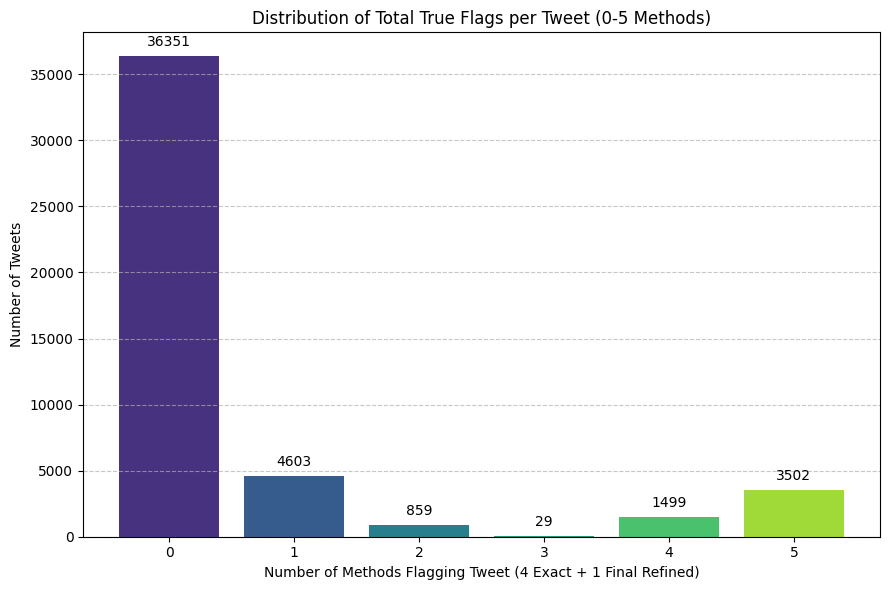

Plotting distribution for 1-5 flags...


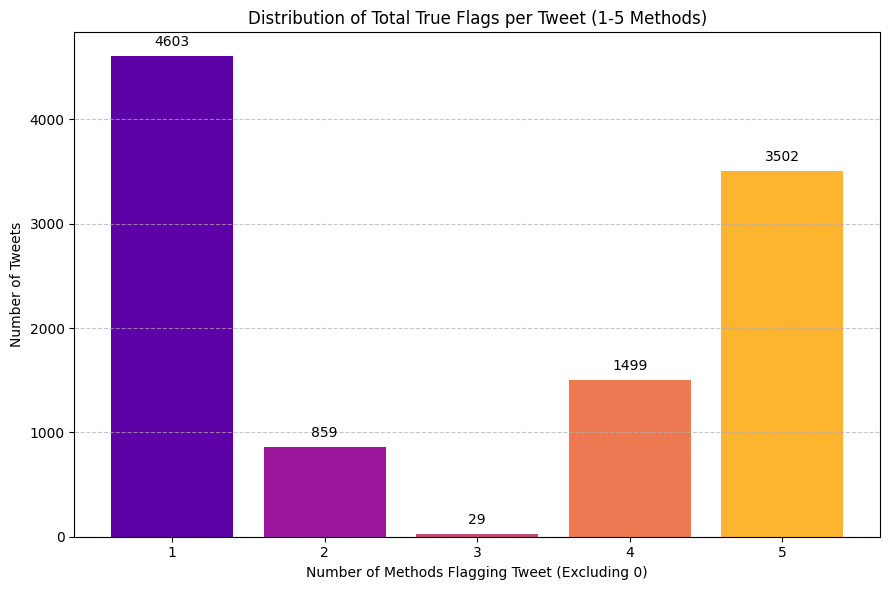

--------------------------------------------------

--- 6. Top Tokens Analysis & Visualization (Including FINAL Method) ---

Top 10 tokens for 'Top 10 Tokens (Gateway)':
  energy: 739
  development: 444
  budget: 433
  taxes: 409
  market: 372
  entrepreneurs: 319
  economy: 310
  inflation: 284
  crisis: 281
  fund: 251


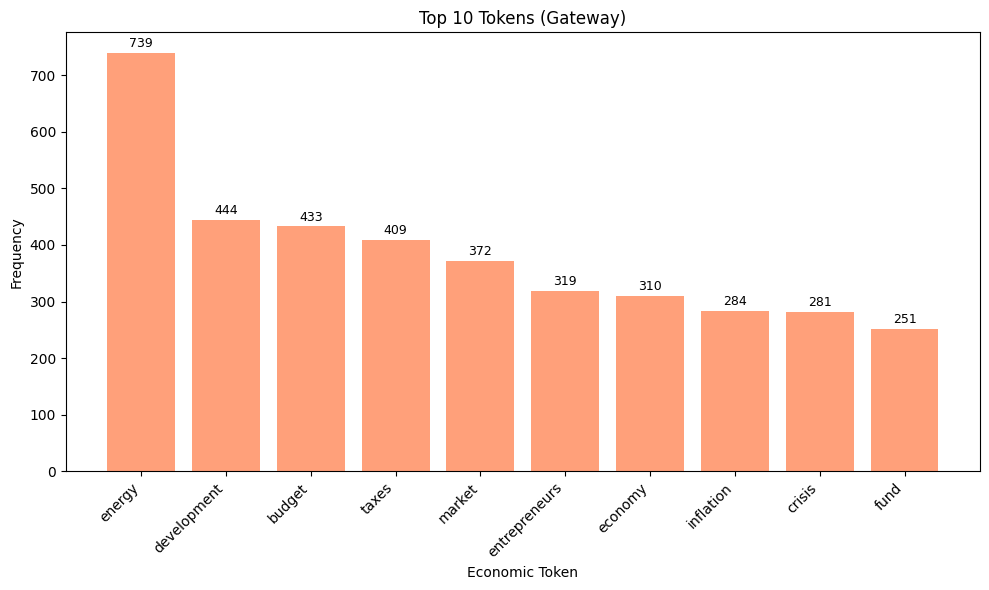


Top 10 tokens for 'Top 10 Tokens (Union)':
  euro: 2915
  import: 1858
  fund: 903
  VAT: 764
  energy: 742
  development: 479
  budget: 458
  investment: 431
  market: 426
  taxes: 417


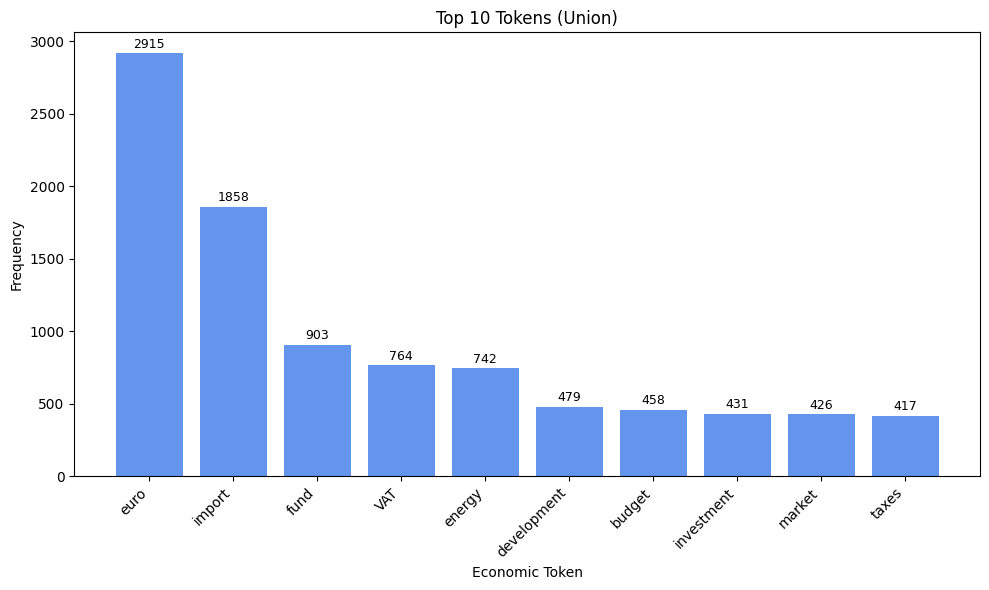


Top 10 tokens for 'Top 10 Tokens (FINAL Refined)':
  fund: 746
  energy: 739
  budget: 450
  investment: 406
  taxes: 406
  market: 402
  development: 402
  entrepreneurs: 342
  economy: 321
  finance: 308


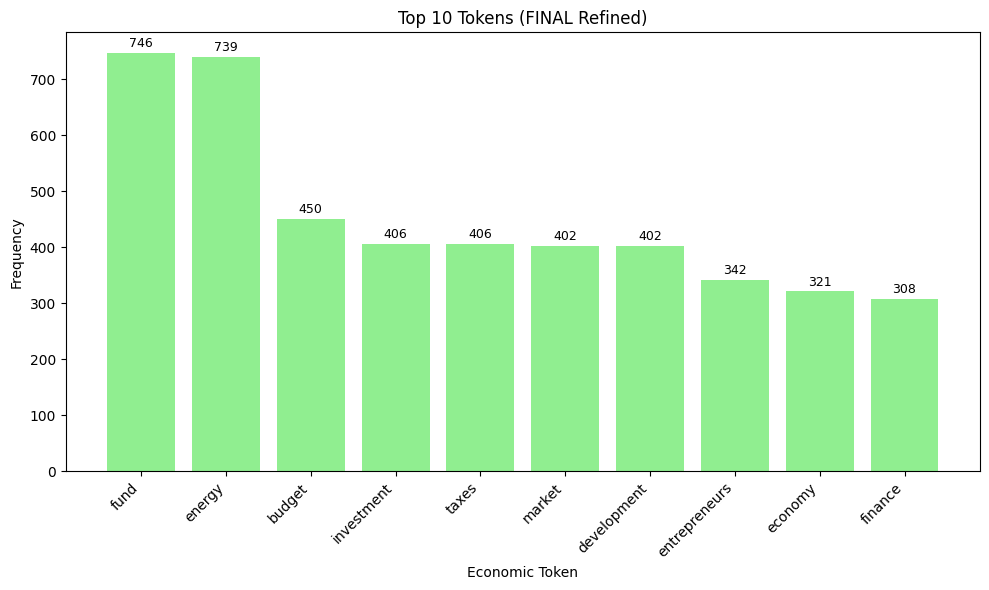


--------------------------------------------------
--- Venn Diagram Comparison of Top Tokens ---


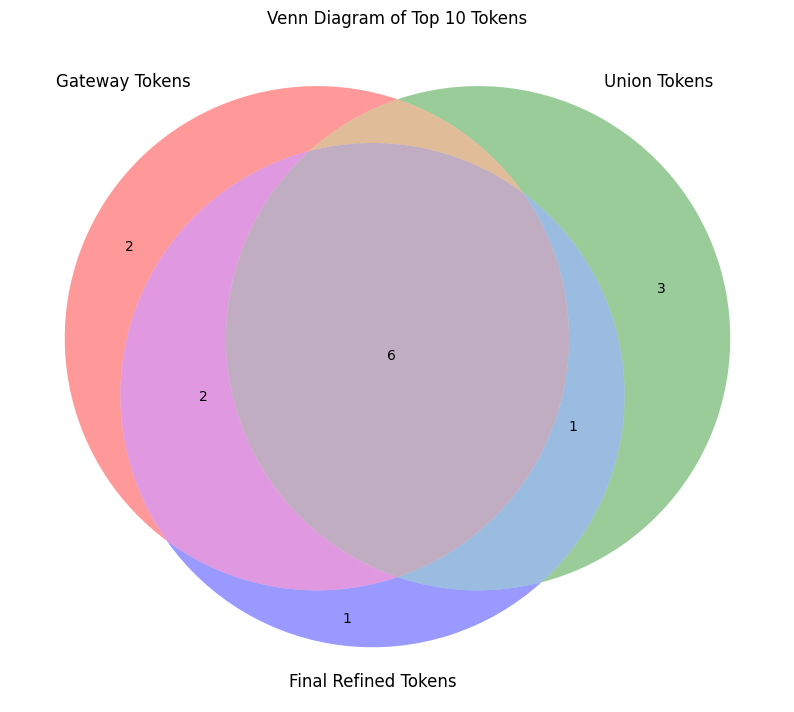


Intersection Analysis (Top 10 Tokens):
Total Unique Top 10 Tokens across all 3 methods: 15

--- Segment Counts & Tokens ---
Only Gateway:                  2 | {'crisis', 'inflation'}
Only Union:                    3 | {'euro', 'import', 'VAT'}
Only Final Refined:            1 | {'finance'}
Gateway & Union (not Final):   0 | set()
Gateway & Final (not Union):   2 | {'economy', 'entrepreneurs'}
Union & Final (not Gateway):   1 | {'investment'}
All Three (G & U & F):         6 | {'fund', 'development', 'taxes', 'energy', 'market', 'budget'}
--------------------------------------------------


In [53]:
# ==============================================================================
# ANALYSIS SCRIPT 
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

try:
    from matplotlib_venn import venn2, venn3
    venn_available = True
except ImportError:
    print("INFO: matplotlib-venn not installed (pip install matplotlib-venn). Venn diagrams will be skipped.")
    venn_available = False


# ==============================================================================
# 1. Token Aggregation Approaches (Gateway & Union - Based on Original Exact Methods)
# ==============================================================================
print("\n--- 1. Calculating Token Aggregation (Gateway & Union) ---")
print() 

def union_tokens(row):
    """ Returns the union of tokens from four original keyword-based columns. """
    cols = ['matched_exact_econ_words_naive', 'matched_exact_econ_words_regex',
            'matched_exact_econ_words_flashtext', 'matched_exact_econ_words_ac', 'matched_keywords_FILTERED']
    tokens = set() # Use set for efficiency
    for col in cols:
        # Check if column exists and value is a list
        if col in row and isinstance(row[col], list):
            tokens.update(row[col])
    return list(tokens)

def gateway_tokens(row, threshold=3): # Using threshold=3 
    """ Returns tokens that appear in at least 'threshold' of the four original columns. """
    cols = ['matched_exact_econ_words_naive', 'matched_exact_econ_words_regex',
            'matched_exact_econ_words_flashtext', 'matched_exact_econ_words_ac', 'matched_keywords_FILTERED']
    tokens_list = []
    # Check if all required columns exist for the row
    if not all(col in row for col in cols):
        return [] # Return empty if any column is missing
    for col in cols:
        if isinstance(row[col], list):
            tokens_list.extend(row[col])
    counts = Counter(tokens_list)
    return [token for token, cnt in counts.items() if cnt >= threshold]

# Check if source columns exist before applying
exact_keyword_cols = ['matched_exact_econ_words_naive', 'matched_exact_econ_words_regex',
                      'matched_exact_econ_words_flashtext', 'matched_exact_econ_words_ac', 'matched_keywords_FILTERED']
if all(col in df_clean_translated.columns for col in exact_keyword_cols):
    print("Applying union_tokens...")
    df_clean_translated['union_tokens'] = df_clean_translated.apply(union_tokens, axis=1)
    print("Applying gateway_tokens (threshold=3)...")
    df_clean_translated['gateway_tokens'] = df_clean_translated.apply(lambda row: gateway_tokens(row, threshold=3), axis=1)

    # Boolean flags for non-empty token lists
    df_clean_translated['union_flag'] = df_clean_translated['union_tokens'].apply(lambda x: isinstance(x, list) and len(x) > 0)
    df_clean_translated['gateway_flag'] = df_clean_translated['gateway_tokens'].apply(lambda x: isinstance(x, list) and len(x) > 0)
    print("Gateway and Union tokens/flags calculated.")
else:
    print("WARNING: One or more exact match keyword columns missing. Skipping Gateway/Union calculation.")
    # Ensure columns exist even if skipped, to prevent later errors
    if 'union_tokens' not in df_clean_translated.columns: df_clean_translated['union_tokens'] = [[] for _ in range(len(df_clean_translated))]
    if 'gateway_tokens' not in df_clean_translated.columns: df_clean_translated['gateway_tokens'] = [[] for _ in range(len(df_clean_translated))]
    if 'union_flag' not in df_clean_translated.columns: df_clean_translated['union_flag'] = False
    if 'gateway_flag' not in df_clean_translated.columns: df_clean_translated['gateway_flag'] = False

print("-" * 50)


# ==============================================================================
# 2. Combined Flag Pattern (Including Final Refined Method)
# ==============================================================================
print("\n--- 2. Creating Combined Flag Pattern ---")

# Define the flag columns in the desired order
# Using the final refined flag 'has_econ_term_FILTERED'
flag_cols_ordered = [
    'has_exact_econ_word_naive',
    'has_exact_econ_word_regex',
    'has_exact_econ_word_flashtext',
    'has_exact_econ_word_ac',
    'has_econ_term_FILTERED' # Your final refined flag
]

# Check if all flag columns exist
missing_flags = [col for col in flag_cols_ordered if col not in df_clean_translated.columns]
if missing_flags:
    print(f"WARNING: The following flag columns are missing and will be excluded from the pattern: {missing_flags}")
    # Filter the list to only include existing columns
    flag_cols_ordered = [col for col in flag_cols_ordered if col in df_clean_translated.columns]

if flag_cols_ordered: # Proceed only if there are some flags left
    df_clean_translated['flag_pattern_combined'] = df_clean_translated.apply(
        lambda row: tuple(bool(row[col]) for col in flag_cols_ordered), # Ensure boolean values
        axis=1
    )
    print("Combined flag pattern created.")
    # Optional: Display value counts for the pattern
    # print("\nFlag Pattern Distribution:")
    # print(df_clean_translated['flag_pattern_combined'].value_counts())
else:
    print("ERROR: No valid flag columns found to create combined pattern.")

print("-" * 50)


# ==============================================================================
# 3. Filtering Examples (Based on Gateway/Union Flags)
# ==============================================================================
# This section remains useful for comparing Gateway/Union results if needed.
print("\n--- 3. Filtering Examples based on Gateway/Union ---")

cols_to_display_agg = ['text_clean_en']
if 'flag_pattern_combined' in df_clean_translated.columns: cols_to_display_agg.append('flag_pattern_combined')
else: print("INFO: 'flag_pattern_combined' column not available for display.")

if 'union_flag' in df_clean_translated.columns and df_clean_translated['union_flag'].any():
    df_with_flags_union = df_clean_translated[df_clean_translated['union_flag'] == True]
    print("\nSample rows based on Union Tokens (non-empty union_tokens):")
    cols_union = cols_to_display_agg + ['union_tokens']
    cols_union_exist = [c for c in cols_union if c in df_with_flags_union.columns]
    try:
        display(df_with_flags_union[cols_union_exist].head())
    except NameError:
        print(df_with_flags_union[cols_union_exist].head().to_string())
else:
    print("\nNo rows found based on Union Tokens or 'union_flag' column missing.")


if 'gateway_flag' in df_clean_translated.columns and df_clean_translated['gateway_flag'].any():
    df_with_flags_gateway = df_clean_translated[df_clean_translated['gateway_flag'] == True]
    print("\nSample rows based on Gateway Tokens (non-empty gateway_tokens):")
    cols_gateway = cols_to_display_agg + ['gateway_tokens']
    cols_gateway_exist = [c for c in cols_gateway if c in df_with_flags_gateway.columns]
    try:
        display(df_with_flags_gateway[cols_gateway_exist].head())
    except NameError:
        print(df_with_flags_gateway[cols_gateway_exist].head().to_string())
else:
    print("\nNo rows found based on Gateway Tokens or 'gateway_flag' column missing.")

print("-" * 50)


# ==============================================================================
# 4. Calculate Total True Flag Count (Incl. Final Refined Method)
# ==============================================================================
print("\n--- 4. Calculating Number of True Flags per Tweet (Incl. Final Refined) ---")

# Include the final refined flag along with the original exact match flags
flags_for_dist_count = [
    'has_exact_econ_word_naive',
    'has_exact_econ_word_regex',
    'has_exact_econ_word_flashtext',
    'has_exact_econ_word_ac',
    'has_econ_term_FILTERED' # Include the final refined flag
]
# Define the new column name
count_col_name = 'num_true_flags_incl_refined'

# Check if all these columns exist in the modified df_clean_translated
missing_flags_for_count = [col for col in flags_for_dist_count if col not in df_clean_translated.columns]
if missing_flags_for_count:
    print(f"WARNING: The following flag columns are missing: {missing_flags_for_count}.")
    print(f"         Skipping calculation of '{count_col_name}'. Distribution plot will fail.")
    # Create dummy column to potentially avoid later errors, or handle downstream
    df_clean_translated[count_col_name] = 0
else:
    # Sum the boolean flags across rows (True counts as 1)
    print(f"Calculating sum of flags: {', '.join(flags_for_dist_count)}")
    df_clean_translated[count_col_name] = df_clean_translated[flags_for_dist_count].sum(axis=1)
    print(f"Calculated '{count_col_name}' column (sum of 4 Exact Match + 1 Final Refined flags).")

print("-" * 50)


# ==============================================================================
# 5. Visualization: Distribution of True Flags (Incl. Final Refined Method)
# ==============================================================================
print("\n--- 5. Visualizing Distribution of True Flags (0-5 Methods) ---")

target_col_dist = count_col_name # Use the new column name

if target_col_dist not in df_clean_translated.columns or df_clean_translated[target_col_dist].sum() == 0 and len(missing_flags_for_count)>0 :
    print(f"ERROR: Column '{target_col_dist}' not found or could not be calculated. Cannot create distribution plot.")
else:
    # 5A) Including 0..5 True Flags
    print("Plotting distribution for 0-5 flags...")
    cat_order = [0, 1, 2, 3, 4, 5]
    
    df_count = df_clean_translated.get(target_col_dist, default=pd.Series(dtype=int)).value_counts(sort=False)
    df_count = df_count.reindex(cat_order, fill_value=0)

    colors = sns.color_palette("viridis", n_colors=len(cat_order)) # Changed palette, 6 colors
    plt.figure(figsize=(9, 6)) # Slightly wider figure
    bars = plt.bar([str(c) for c in cat_order], df_count.values, color=colors)
    for bar, count in zip(bars, df_count.values):
        plt.annotate(f"{count}", xy=(bar.get_x() + bar.get_width()/2, count),
                     xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')
    plt.xlabel("Number of Methods Flagging Tweet (4 Exact + 1 Final Refined)")
    plt.ylabel("Number of Tweets")
    plt.title("Distribution of Total True Flags per Tweet (0-5 Methods)")
    plt.grid(axis='y', linestyle='--', alpha=0.7); plt.tight_layout(); plt.show()

    # 5B) Excluding 0 (only 1..5)
    print("Plotting distribution for 1-5 flags...")
    cat_order_nz = [1, 2, 3, 4, 5]
    df_count_nz = df_count.reindex(cat_order_nz, fill_value=0)
    if df_count_nz.sum() > 0: # Only plot if there are non-zero counts in 1-5 range
        colors_nz = sns.color_palette("plasma", n_colors=len(cat_order_nz)) # Changed palette, 5 colors
        plt.figure(figsize=(9, 6)) # Slightly wider figure
        bars_nz = plt.bar([str(c) for c in cat_order_nz], df_count_nz.values, color=colors_nz)
        for bar, count in zip(bars_nz, df_count_nz.values):
            plt.annotate(f"{count}", xy=(bar.get_x() + bar.get_width()/2, count),
                         xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')
        plt.xlabel("Number of Methods Flagging Tweet (Excluding 0)")
        plt.ylabel("Number of Tweets")
        plt.title("Distribution of Total True Flags per Tweet (1-5 Methods)")
        plt.grid(axis='y', linestyle='--', alpha=0.7); plt.tight_layout(); plt.show()
    else:
        print("No tweets found with 1-5 flags.")

print("-" * 50)


# ==============================================================================
# 6. Visualizations: Top Tokens & Venn Diagram (Incl. FINAL Refined Method)
# ==============================================================================
print("\n--- 6. Top Tokens Analysis & Visualization (Including FINAL Method) ---")

def plot_top_tokens_annotated(df, token_col, title, top_n=10, color="skyblue"):
    """ Plots top N tokens from a specified column in a DataFrame. """
    if token_col not in df.columns:
        print(f"Warning: Column '{token_col}' not found in DataFrame for plotting. Skipping '{title}'.")
        return
    # Ensure the column contains lists and handle potential non-list entries gracefully
    all_tokens = [token for tokens_list in df[token_col] if isinstance(tokens_list, list) for token in tokens_list]
    if not all_tokens:
        print(f"No tokens found in column '{token_col}' for plotting '{title}'.")
        return
    token_counts = Counter(all_tokens)
    print(f"\nTop {top_n} tokens for '{title}':")
    for token, count in token_counts.most_common(top_n): print(f"  {token}: {count}")
    top_tokens_data = token_counts.most_common(top_n)
    if not top_tokens_data: print(f"No top tokens found to plot for '{title}'."); return
    tokens, counts = zip(*top_tokens_data)
    plt.figure(figsize=(10, 6)); bars = plt.bar(tokens, counts, color=color)
    plt.xlabel("Economic Token"); plt.ylabel("Frequency"); plt.title(title)
    plt.xticks(rotation=45, ha='right')
    for bar, cnt in zip(bars, counts):
        plt.annotate(f"{cnt}", xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                     xytext=(0, 2), textcoords="offset points", ha='center', va='bottom', fontsize=9)
    plt.tight_layout(); plt.show()

def get_top_tokens_set(df, token_col, top_n=10):
    """ Returns a set of the top N tokens from the specified column. """
    if token_col not in df.columns: return set() # Return empty set if column missing
    all_tokens = [token for tokens_list in df[token_col] if isinstance(tokens_list, list) for token in tokens_list]
    if not all_tokens: return set()
    token_counts = Counter(all_tokens)
    top_tokens_list = [token for token, count in token_counts.most_common(top_n)]
    return set(top_tokens_list)

# --- Plot Top Tokens ---
top_n_to_plot = 10
# Gateway (uses df_with_flags_gateway based on original exact matches)
if 'df_with_flags_gateway' in locals() and not df_with_flags_gateway.empty:
    plot_top_tokens_annotated(df_with_flags_gateway, 'gateway_tokens', f"Top {top_n_to_plot} Tokens (Gateway)", top_n=top_n_to_plot, color="lightsalmon")
else: print("Skipping Gateway plot: 'df_with_flags_gateway' not defined or empty.")
# Union (uses df_with_flags_union based on original exact matches)
if 'df_with_flags_union' in locals() and not df_with_flags_union.empty:
    plot_top_tokens_annotated(df_with_flags_union, 'union_tokens', f"Top {top_n_to_plot} Tokens (Union)", top_n=top_n_to_plot, color="cornflowerblue")
else: print("Skipping Union plot: 'df_with_flags_union' not defined or empty.")
# FINAL Refined Method (uses the modified df_clean_translated)
final_flag_col = 'has_econ_term_FILTERED' # Flag after inplace drop
final_kw_col = 'matched_keywords_FILTERED' # Keywords after inplace drop
if final_flag_col in df_clean_translated.columns and final_kw_col in df_clean_translated.columns:
    df_final_flagged = df_clean_translated[df_clean_translated[final_flag_col]].copy()
    if not df_final_flagged.empty:
        plot_top_tokens_annotated(df_final_flagged, final_kw_col, f"Top {top_n_to_plot} Tokens (FINAL Refined)", top_n=top_n_to_plot, color="lightgreen")
    else: print("No tweets flagged by the FINAL refined method to plot.")
else: print(f"Skipping FINAL Refined plot: Columns '{final_flag_col}' or '{final_kw_col}' not found.")



# --- Venn Diagram Comparison (Gateway vs Union vs Final Refined) ---
print("\n" + "-"*50)
print("--- Venn Diagram Comparison of Top Tokens ---")
if not venn_available:
    print("Skipping Venn diagram as matplotlib-venn library is not available.")
else:
    top_n_venn = 10 # Number of top tokens to compare
    # Get top tokens sets
    top_gateway_set = get_top_tokens_set(df_with_flags_gateway, 'gateway_tokens', top_n=top_n_venn) if 'df_with_flags_gateway' in locals() else set()
    top_union_set   = get_top_tokens_set(df_with_flags_union, 'union_tokens', top_n=top_n_venn) if 'df_with_flags_union' in locals() else set()
    if final_flag_col in df_clean_translated.columns and final_kw_col in df_clean_translated.columns:
         df_final_flagged_venn = df_clean_translated[df_clean_translated[final_flag_col]]
         top_final_set = get_top_tokens_set(df_final_flagged_venn, final_kw_col, top_n=top_n_venn)
    else: top_final_set = set()

    if not top_gateway_set and not top_union_set and not top_final_set:
         print("No top tokens found for any method to create Venn diagram.")
    else:
         plt.figure(figsize=(10, 10))
         v = venn3([top_gateway_set, top_union_set, top_final_set],
                   set_labels=('Gateway Tokens', 'Union Tokens', 'Final Refined Tokens'),
                   # Use counts for subsets
                   subset_label_formatter=lambda x: str(x) if x > 0 else ''
                   )
         # Optional colors:
         # if v: v.get_patch_by_id('100').set_color('salmon'); v.get_patch_by_id('010').set_color('cornflowerblue'); v.get_patch_by_id('001').set_color('lightgreen')
         plt.title(f"Venn Diagram of Top {top_n_venn} Tokens")
         plt.show()

         # Calculate and Print Intersections
         g_u_f = top_gateway_set.intersection(top_union_set).intersection(top_final_set)
         g_u_nf = top_gateway_set.intersection(top_union_set) - top_final_set
         g_f_nu = top_gateway_set.intersection(top_final_set) - top_union_set
         u_f_ng = top_union_set.intersection(top_final_set) - top_gateway_set
         g_nu_nf = top_gateway_set - top_union_set - top_final_set
         u_ng_nf = top_union_set - top_gateway_set - top_final_set
         f_ng_nu = top_final_set - top_gateway_set - top_union_set
         all_top_tokens = top_gateway_set.union(top_union_set).union(top_final_set)
         total_unique_top = len(all_top_tokens)
         print(f"\nIntersection Analysis (Top {top_n_venn} Tokens):")
         print(f"Total Unique Top {top_n_venn} Tokens across all 3 methods: {total_unique_top}")
         print(f"\n--- Segment Counts & Tokens ---")
         print(f"Only Gateway:                {len(g_nu_nf):>3} | {g_nu_nf}")
         print(f"Only Union:                  {len(u_ng_nf):>3} | {u_ng_nf}")
         print(f"Only Final Refined:          {len(f_ng_nu):>3} | {f_ng_nu}")
         print(f"Gateway & Union (not Final): {len(g_u_nf):>3} | {g_u_nf}")
         print(f"Gateway & Final (not Union): {len(g_f_nu):>3} | {g_f_nu}")
         print(f"Union & Final (not Gateway): {len(u_f_ng):>3} | {u_f_ng}")
         print(f"All Three (G & U & F):       {len(g_u_f):>3} | {g_u_f}")

print("-" * 50)

In [55]:
# ==============================================================================
# (6.0) INSPECT RANDOM ROWS FOR SPECIFIC TOP KEYWORDS
# ==============================================================================
# This section allows inspecting a RANDOM SAMPLE of rows containing a specific
# keyword identified by different methods.

print("\n--- Inspecting RANDOM Rows for Specific Top Keywords ---")

# !!! DEFINE the keyword you want to inspect !!!
keyword_to_inspect = 'energy' # <--- CHANGE THIS to 'euro', 'import', 'taxes', etc.

# Methods and their corresponding keyword list columns
methods_to_inspect = {
    'Gateway': 'gateway_tokens',
    'Union': 'union_tokens',
    'Final_Refined': 'matched_keywords_FILTERED' # Use the final keyword column
}

# Configuration for display
text_col_inspect = 'text_clean_en'
id_col_inspect = 'id' # !!! Use ID column name !!!
n_rows_to_sample = 50 # Number of RANDOM sample rows to display for each method

print(f"\nLooking for keyword: '{keyword_to_inspect}'")
print("-" * 50)

# Loop through each method
for method_name, kw_col in methods_to_inspect.items():
    print(f"--- Checking Method: {method_name} (Column: {kw_col}) ---")

    # Check if the keyword column exists in the main DataFrame
    if kw_col not in df_clean_translated.columns:
        print(f"ERROR: Keyword column '{kw_col}' not found in df_clean_translated. Skipping.")
        continue

    # Create a mask to find rows where the keyword list contains the target keyword
    # Ensure the column contains lists and handle potential errors/NaNs gracefully
    try:
        mask_contains_keyword = df_clean_translated[kw_col].apply(
            lambda lst: isinstance(lst, list) and keyword_to_inspect in lst
        )
    except Exception as e:
        print(f"Error creating mask for column '{kw_col}': {e}. Skipping method.")
        continue

    # Filter the DataFrame
    df_contains_keyword = df_clean_translated[mask_contains_keyword]
    count_contains_keyword = len(df_contains_keyword)

    if count_contains_keyword > 0:
        print(f"Found {count_contains_keyword} rows where '{keyword_to_inspect}' is in '{kw_col}'.")

        # Determine actual sample size (cannot sample more than available)
        actual_sample_size = min(n_rows_to_sample, count_contains_keyword)
        print(f"Displaying a random sample of {actual_sample_size} examples:")

        # --- Get a RANDOM SAMPLE ---
        # Use random_state=None for a different sample each time, or an integer for reproducibility
        df_sample_to_show = df_contains_keyword.sample(n=actual_sample_size, random_state=None)

        # Define columns to show for context
        cols_to_show_inspect = [text_col_inspect, kw_col]
        if method_name == 'Final_Refined' and 'extracted_terms_FILTERED' in df_sample_to_show.columns:
            cols_to_show_inspect.insert(1, 'extracted_terms_FILTERED')
        if id_col_inspect in df_sample_to_show.columns:
            cols_to_show_inspect.insert(0, id_col_inspect)
        
        # Ensure chosen columns exist in the sample (should, as they come from df_contains_keyword)
        cols_to_display_final = [c for c in cols_to_show_inspect if c in df_sample_to_show.columns]

        try:
            display(df_sample_to_show[cols_to_display_final])
        except NameError:
            print(df_sample_to_show[cols_to_display_final].to_string())
    else:
        print(f"No rows found where '{keyword_to_inspect}' is in '{kw_col}'.")
    print("-" * 50)

print("--- Keyword Row Inspection Complete ---")
print("-" * 50)


--- Inspecting RANDOM Rows for Specific Top Keywords ---

Looking for keyword: 'energy'
--------------------------------------------------
--- Checking Method: Gateway (Column: gateway_tokens) ---
Found 739 rows where 'energy' is in 'gateway_tokens'.
Displaying a random sample of 50 examples:


id                                      text_clean_en  \
35272  1688917129675034624  Today, together with Masovia, as part of the #...   
38428  1768329485458211072  Energy transformation is an opportunity for a ...   
32948  1769376921295425536  On October 15, huge mobilization and great civ...   
9794   1636829335859474432    Ladies - it's easy to fight when you have su...   
28078  1616716427032989696  Even the pandemic, war abroad, Putinflation an...   
36724  1702018202396496128  I cordially invite you - personally as a resid...   
38483  1731420472703660288  Regarding #LexSiemens, in April this year PGE,...   
45334  1583843161943977984  Our today's meeting with Mega energy, great to...   
2348   1825545214628618752   Your government announced nuclear energy 15 y...   
34430  1696817383644725504  At #Campus2023 you could feel the energy of yo...   
18397  1614217685834862592  After 7 years of blocking energy from wind far...   
5005   1720378867016241408   ❌ ARE THERE LIMITS OF ABSURD? History is happ...   
39534  1826328057293992192  In the coming years, Poland must develop even ...   
28833  1649118628329947136   In fact, there was no consent from the Counci...   
9322   1626588863492943872   Because the ban on the sale of alcohol goes h...   
38213  1828311707602599936  Apart from armaments, topics such as social ho...   
18590  1583012045779189760  We have rampant inflation, an energy crisis, a...   
28781  1666545176766980096  External forces are trying to weaken our count...   
37308  1706968203480490240  Did you know that it is implementing the large...   
34666  1677626201223962624  In Poland we have the most expensive energy in...   
35242  1690660929497681920  Today is Raciąż and the 10th Raciąż Fair. As a...   
36710  1702966431510340096  The key is the best team and real emotions 😊  ...   
45720  1588521241958580224  In matters of defense and nuclear energy, a cr...   
18223  1643191830341730304   📷 Energy policy is conducted very badly by Pi...   
32859  1776921908669227520  The one and only Mrs. Wanda Traczyk-Stawska "P...   
7487   1792306387457916928  Conversation 👇 🏻   The problem is that even fr...   
29925  1767095802646712320  Yesterday, together with the Minister, we supp...   
4065   1844314129667875072  Conclusions from reading the budget act:  The ...   
4954   1733583887085740032   ❌ Grrr... There weren't a dozen or so brave M...   
18377  1617832377803501568  PiS and Solidarna Polska are divided by fundam...   
46531  1600785273629118464  A few words about the energy verification comm...   
7044   1721209306324910592  We wonder how long Poles will allow themselves...   
7941   1705879185741213952  Great Convention in Spodek in Katowice! Streng...   
43327  1796564823402287616  We consider the 12th National Congress of Larg...   
38257  1811422358445437184  I signed three more contracts for the developm...   
37628  1658184540265803776  Full house. Great energy. Open conversation ab...   
45729  1584563752501813248  There is no issue more important than Poland's...   
39551  1816545960216215808  Thank you for your trust!  🙂 🤝    The greatest...   
18361  1620040370242609152   🌫 Coal dust covers Gdańsk. Instead of being a...   
16308  1786686798313242880   ☀️ Yesterday in the Park. hmm. F. Kachla in B...   
38174  1837014134648406272  We fight disinformation!  After the amendment ...   
38566  1838187441703842048  We are creating a new priority in European Fun...   
39970  1802108927242588672  Maybe thanks to the renewable energy installat...   
3571   1798391876233703424  Where will we get electricity from? After all,...   
28140  1588458410995245056  I talked to the new Prime Minister of the UK a...   
3499   1807469851012976896  We are against new EU taxes!  🇪 🇺 ❌ ️  We want...   
9167   1585229295676317696  Another campaign about electricity prices. Thi...   
38252  1813115577319260160   ☀️Photovoltaics is profitable again!  And thi...   
42269  1601572660286459904  The #ZielonaNiepodległa Con

--------------------------------------------------
--- Checking Method: Union (Column: union_tokens) ---
Found 742 rows where 'energy' is in 'union_tokens'.
Displaying a random sample of 50 examples:


id                                      text_clean_en  \
8998   1601491905631916032  Bravo 👏 🏻  Pressure makes sense! We have expos...   
14477  1730488356377604352   🗣 ️ , he practically plowed wind energy in Po...   
8645   1687157188328861696  The Parliament has banned the sale of energy d...   
14460  1731595139741610240   🗣 ️Both the energy and military security of o...   
45747  1711423139660321024  And this morning, my hometown #Biskupiec, #Jez...   
40472  1700185094256738560   Nobody buys into such a narrative, but we can...   
7619   1768580095210398208   📣 The issue of emission reduction is that we ...   
36325  1660734840138866688  Ostróda and Morąg, great meetings and fantasti...   
9869   1606569023549972480   ❌ You can feel that elections are coming. The...   
36667  1705925800652943872  See what energy there was in the pouring rain ...   
40653  1631036955172429824  We will start the green transformation - the o...   
44103  1730570007686365184  Nuclear energy and renewable energy are guaran...   
14466  1730893580955222016   🗣 ️In order for prices not to increase, we mu...   
35242  1690660929497681920  Today is Raciąż and the 10th Raciąż Fair. As a...   
19108  1710620424810242304  Last election Saturday! We don't give up! Elec...   
20498  1682031784459145216   📺 I'm glad that we still have energy from Tur...   
6694   1780488073437934080   ❌ Ban on using gas and coal stoves in new bui...   
43112  1593546012211159040   About energy cooperatives. Please see the ent...   
32948  1769376921295425536  On October 15, huge mobilization and great civ...   
38194  1833159133203222528  We are allocating a record PLN 70 billion for ...   
26703  1638600532347502592  During the #Silesia2030 conference organized a...   
20209  1707022710486802688   🗣 ️The cheapest and cleanest energy is the on...   
18267  1633418011594850304  At the energy committee, a representative defe...   
38047  1589982389354528768  Meeting with . We talked about the Green Visio...   
13770  1819647349456601344  🗣 ️ Security is not only about reinforcements....   
24514  1788475644914831360   ➡️ ❗️ There's no time to waste here!   We nee...   
18193  1648603851434385408   💬 The PiS government blames the EU for everyt...   
39584  1792845921312444416  Atom is pure energy.  The green change will be...   
42487  1677276254523781120  Third Way - first session in the Sejm. We are ...   
18260  1635279362097557504  Ziobrists appeal to the President to veto the ...   
36519  1589984195413057536  An interesting conversation with the Mayor of ...   
38403  1778309059306725888  With the help of municipalities, we will subsi...   
38361  1787851991189721344  1/2 The government, upon request, adopted a dr...   
43109  1594818313833844736  We want to turn #ZielonaNiepodległa Week into ...   
39551  1816545960216215808  Thank you for your trust!  🙂 🤝    The greatest...   
37625  1659113345235005440  Thank you for the dialogue and awareness that ...   
40826  1701599288835621120  Economy or social policy? Education or ecology...   
38688  1776212202157965568  Today we opened the largest program for local ...   
26815  1582117490796023808  We are facing an energy crisis that is causing...   
18361  1620040370242609152   🌫 Coal dust covers Gdańsk. Instead of being a...   
26840  1696619081015718144  Thank you to everyone who came to meet me in #...   
23235  1767222615628816384  In a document sent to Brussels, Tusk's governm...   
24434  1800833521876889600  Instead of fulfilling further promises, we are...   
41973  1712428306266480640  We are accelerating. There is energy for a gre...   
24507  1789354867498139904  Today I had the pleasure of meeting local gove...   
6363   1831415037703098880  Despite the record budget deficit for 2025, fu...   
18539  1590286174564024320  Way to go ! It is interesting that the Polish ...   
6992   1731686344869417472  Conversation in 👇 🏻   The Confederation reques...   
23143  1790646060563501312  The wave of mass layoffs is

--------------------------------------------------
--- Checking Method: Final_Refined (Column: matched_keywords_FILTERED) ---
Found 739 rows where 'energy' is in 'matched_keywords_FILTERED'.
Displaying a random sample of 50 examples:


id                                      text_clean_en  \
26661  1661045405054902272  Today in the European Parliament there are int...   
10356  1655508816031625216  There is no bathroom in over a million Polish ...   
18384  1616103517097283584   💬 We are waiting for wind energy to finally b...   
2127   1836744266762109184  Climate activists, energy experts, lobbyists. ...   
42120  1672533824423567360  Friendship. New energy. Cooperation. Simply th...   
35272  1688917129675034624  Today, together with Masovia, as part of the #...   
2334   1825966685553135872   You had a whole campaign, a whole year of gov...   
46628  1584139852001705984  In 2015-21, 9 mines were closed. At the same t...   
40668  1625451967098109952      The government is talking more and more ab...   
34666  1677626201223962624  In Poland we have the most expensive energy in...   
15840  1740352182543909376  It's a good day for Poland! EUR 5 billion has ...   
38271  1809145441356845568  The Pomeranian Voivodeship is one of the leade...   
28078  1616716427032989696  Even the pandemic, war abroad, Putinflation an...   
43949  1781259108215042560  Barbara Gąsiorowska has already proven many ti...   
6694   1780488073437934080   ❌ Ban on using gas and coal stoves in new bui...   
41079  1703401129063645440  The division into strategic and non-strategic ...   
20998  1644624519972241408   🎙 ️Therefore, Polish food producers need more...   
33571  1639681922346483712  The ninth day in the Silesian Voivodeship. We'...   
18333  1625438773688389632  As an MP, I wish you on Valentine's Day that y...   
45389  1707374480568234496  Lots of conversations and great energy in Kosz...   
2348   1825545214628618752   Your government announced nuclear energy 15 y...   
18992  1708088256263262208  Afternoon in Płock! Together with and we encou...   
38374  1785034053390856448  Today, the Committee of the Council of Ministe...   
38072  1585258848910446592  Katarzyna and Rafał created an extraordinary h...   
32261  1762907686838980864  I received a powerful charge of strength today...   
45241  1651212979776499712  We have adopted a compromise regarding the met...   
8163   1656324723997917184  We live in a country full of restrictions, pro...   
18385  1616041583790497792  I have just sent a letter to the provincial po...   
10274  1670064704851419136  The Golden Mati is already waiting for you at ...   
42877  1676120289590034432  On Wednesday, July 5. It's worth visiting or w...   
18508  1594389513773760512    We know, we know. Especially from the deform...   
36624  1709570839711023104  What energy at the #KobietyNaWybory campaign i...   
2558   1817949528559136768  Simple logic is enough: who are the anti-Poles...   
13009  1812088746059121152  Busy Saturday with   About the future of young...   
38394  1780518917930184704  Not every family can afford to replace the sto...   
16308  1786686798313242880   ☀️ Yesterday in the Park. hmm. F. Kachla in B...   
45106  1703360589370688000  Primary elections in Wieruszów ✌ ️ 🇵 🇱 ☺ ️ Gre...   
26844  1690337002174955520  Thank you for the warm welcome and interesting...   
7783   1731570155082207488  If the threat of mass expropriation for windmi...   
45298  1617188177298464768  How important is Poland's energy self-sufficie...   
25147  1785742512902074624  Soon there will be sharp increases in gas and ...   
14437  1733405505744220416  How did the Polish energy industry get to this...   
28010  1633214009552846848   🇸 🇦 We discussed with the Crown Prince of the...   
36519  1589984195413057536  An interesting conversation with the Mayor of ...   
38688  1776212202157965568  Today we opened the largest program for local ...   
38585  1830863468532015104  Today we are launching recruitment from KPO fo...   
18259  1635627263692533760  Today, the president contributed to the funera...   
8862   1627706935637078016  THE SCALE OF ENERGY POVERTY IS INCREASING IN P...   
6741   1771632392819601920  The #KonfederacjaBezpartyjn

--------------------------------------------------
--- Keyword Row Inspection Complete ---
--------------------------------------------------


In [56]:
df_clean_translated.columns

Index(['created_at', 'text', 'id', 'author_id', 'edit_controls',
       'possibly_sensitive', 'reply_settings', 'lang',
       'edit_history_tweet_ids', 'conversation_id', 'category', 'attachments',
       'username', 'party', 'in_reply_to_user_id', 'context_annotations',
       'referenced_tweets', 'geo', 'text_clean', 'mentions', 'links',
       'hashtags', 'retweet_count', 'reply_count', 'like_count', 'quote_count',
       'impression_count', 'text_clean_en', 'text_clean_en_demojized',
       'text_clean_demojized', 'emoji_count_en', 'emoji_count', 'name',
       'matched_exact_econ_words_naive', 'has_exact_econ_word_naive',
       'matched_exact_econ_words_regex', 'has_exact_econ_word_regex',
       'matched_exact_econ_words_flashtext', 'has_exact_econ_word_flashtext',
       'matched_exact_econ_words_ac', 'has_exact_econ_word_ac',
       'matched_keywords_ORIG', 'has_econ_term_ORIG',
       'extracted_terms_FILTERED', 'matched_keywords_FILTERED',
       'has_econ_term_FILTERED', '

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter # Make sure this is imported
import os
import random
from tqdm.auto import tqdm
import ahocorasick 
import spacy 

In [58]:
# ==============================================================================
# 7. PARTY ANALYSIS PREPARATION
# ==============================================================================
# This section prepares data needed for analysis later on
# includes naem standarization and color definitions.

print("\n--- 7. Party Analysis Preparation ---")

party_col = 'party' # !!! CAREFULLY CHECK IF THE COLUMN IS RIGHT !!!

# Check if party column exists
if party_col not in df_clean_translated.columns:
    print(f"ERROR: Party column '{party_col}' not found.")
    run_party_analysis = False
else:
    print(f"Using party column: '{party_col}' for analysis.")
    run_party_analysis = True


    # --------------------------------------------------------------------------
    # 7.A: Optional Party Name Remapping 
    # --------------------------------------------------------------------------
    # Uncomment and modify this block if you need to map different names
    # (e.g., 'PO') to a single standard name ('Platforma Obywatelska') for the sake of graphs or something else.
    # Make sure the keys in party_colors (defined next) match the FINAL names.

    # print("\n--- 7.A: Standardizing Party Names (Example) ---")
    # party_mapping = {
    #     'PO': 'Platforma Obywatelska', 
    #     'Nowa Lewica': 'Lewica',     
    #     'PL2050': 'PL2050',
    #     'PIS': 'PiS',
    #     'PSL': 'PSL',
    #     'Konfederacja': 'Konfederacja',
    # }

    # # Check current unique values
    # original_parties = sorted(df_clean_translated[party_col].astype(str).unique())
    # print(f"Original unique party values: {original_parties}")
    # # Apply mapping - maps keys present in the dict, keeps others using .fillna()
    # df_clean_translated[party_col] = df_clean_translated[party_col].map(party_mapping).fillna(df_clean_translated[party_col])
    # standardized_parties = sorted(df_clean_translated[party_col].astype(str).unique())
    # if list(original_parties) != list(standardized_parties):
    #      print(f"Standardized unique party values: {standardized_parties}")
    # else:
    #      print("Party names appear consistent or mapping wasn't applied/needed.")
    # print("-" * 30)


    # --------------------------------------------------------------------------
    # 7.B: Define Party Colors
    # --------------------------------------------------------------------------
    print("\n--- 7.B: Defining Party Colors ---")
    # !!! IMPORTANT: Keys MUST match the FINAL party names in your 'party' column (AFTER any remapping done in step 7.A) !!!
    party_colors = {
        'Konfederacja':           'red',
        'NL':                     'blue',    
        'PL2050':                 'green',
        'PO':                     'purple',  
        'PSL':                    'orange',
        'PIS':                    'yellow',  

        'Unknown_Party':          'grey'     # Fallback color
    }
    print("Party colors dictionary defined based on user specification:")
    print(party_colors)
    # Check against actual unique values in the potentially remapped column
    current_parties_in_data = df_clean_translated[party_col].unique()
    for p in current_parties_in_data:
        if p not in party_colors:
             print(f"WARNING: Party '{p}' found in data but is missing from party_colors dictionary! Will use grey.")
    print()
    print("-" * 50)

print("----> Party Analysis Preparation Complete <----")
print("-" * 50)


--- 7. Party Analysis Preparation ---
Using party column: 'party' for analysis.

--- 7.B: Defining Party Colors ---
Party colors dictionary defined based on user specification:
{'Konfederacja': 'red', 'NL': 'blue', 'PL2050': 'green', 'PO': 'purple', 'PSL': 'orange', 'PIS': 'yellow', 'Unknown_Party': 'grey'}

--------------------------------------------------
----> Party Analysis Preparation Complete <----
--------------------------------------------------



--- 8. Party-Level Analysis & Visualization (7D Structure) ---
Party analysis helper functions defined.
--------------------------------------------------

--- 8.B: Calculating Party Summary Statistics (Counts & Shares %) ---

Party Summary Table (Counts and Shares %):


party  total_tweets  Union_count  Gateway_count  \
0  Konfederacja         12001         2705           1498   
1            NL         10914         2325            873   
2           PIS          6264         1734            725   
3        PL2050          5055         1091            645   
4            PO          8906         1590            688   
5           PSL          3703         1047            585   

   Final_Refined_count  Union_share_pct  Gateway_share_pct  \
0                 1693            22.54              12.48   
1                 1224            21.30               8.00   
2                  904            27.68              11.57   
3                  753            21.58              12.76   
4                  833            17.85               7.73   
5                  682            28.27              15.80   

   Final_Refined_share_pct  
0                    14.11  
1                    11.21  
2                    14.43  
3                    14.90  
4                     9.35  
5                    18.42

------------------------------------------------------------

--- Running Analysis for: Final Refined Method ---

Plotting top 10 tokens by party for approach: Final Refined


<Figure size 640x480 with 0 Axes>

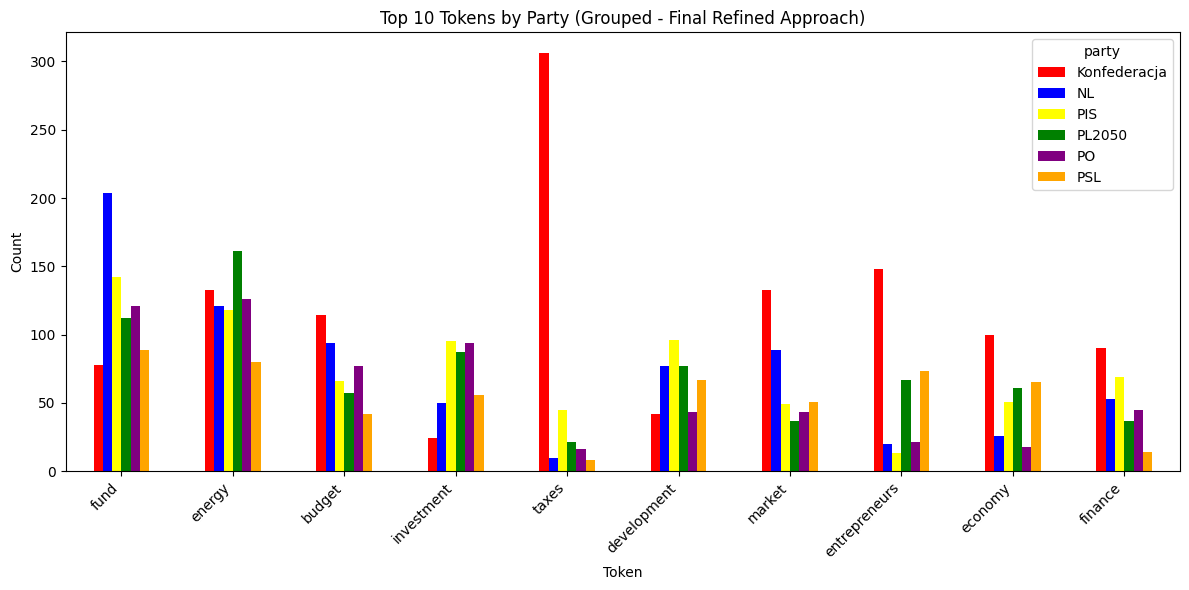

<Figure size 640x480 with 0 Axes>

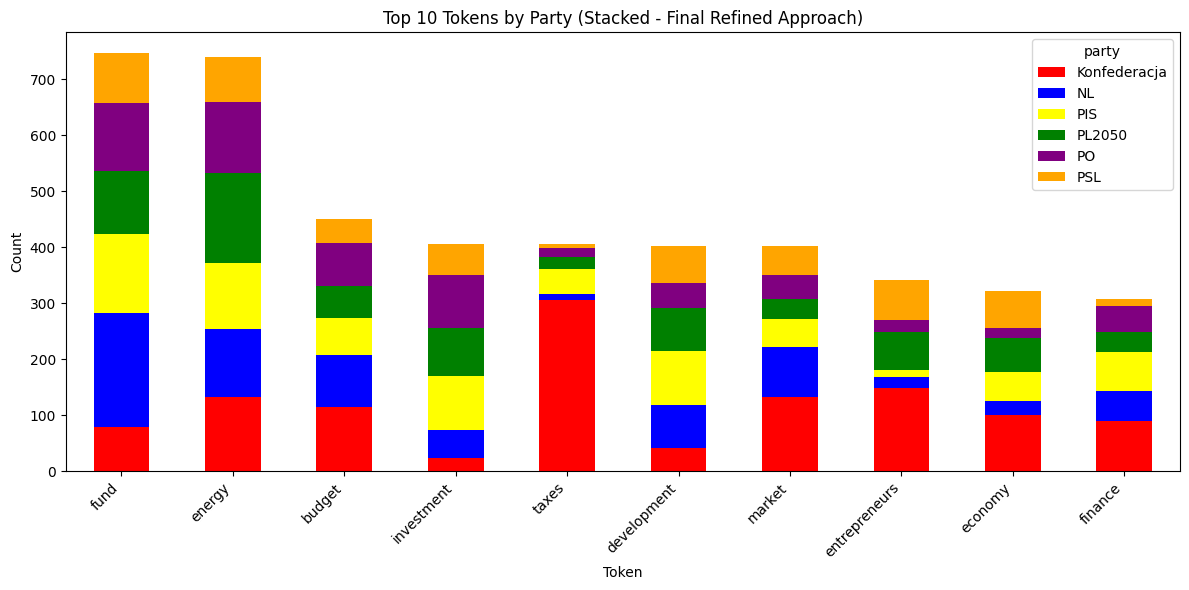


Plotting Share for: Final_Refined Method


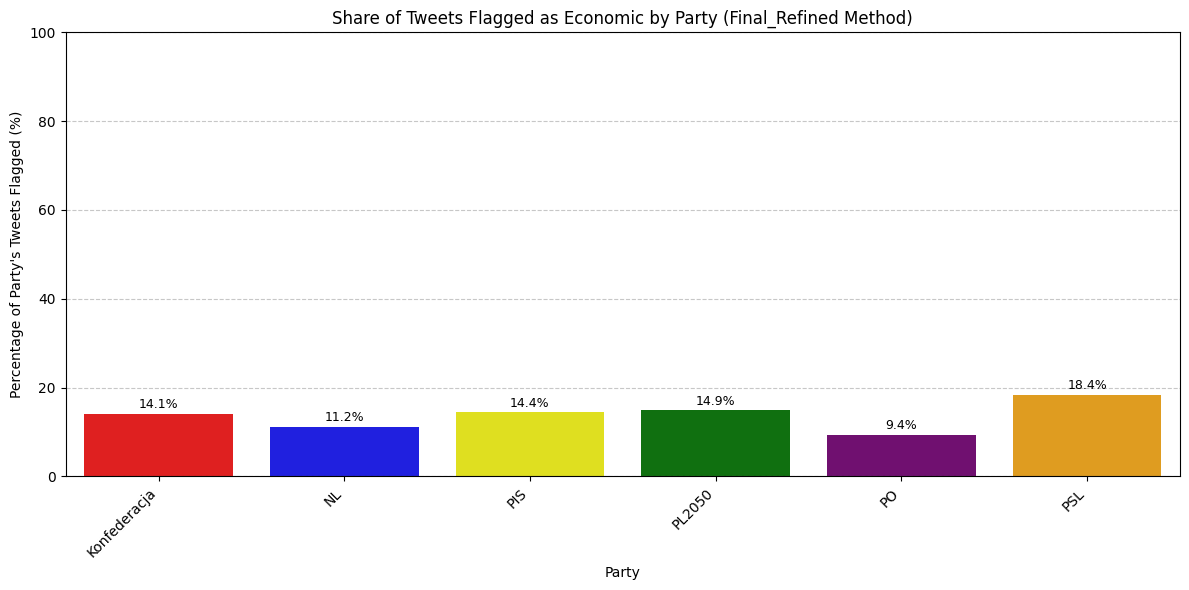

------------------------------------------------------------

----> Party-Level Analysis Complete <----


In [59]:
# ==============================================================================
# 8. PARTY-LEVEL ANALYSIS & VISUALIZATION
# ==============================================================================
# This section defines functions and performs analysis on token usage and
# flagging shares broken down by political party, using specified party colors.
# Analysis for each method is called sequentially.

# Only run if party column exists and run_party_analysis is True (set in Section 7)
if run_party_analysis:
    print("\n--- 8. Party-Level Analysis & Visualization (7D Structure) ---")

    # --- Configuration ---
    # party_col defined in Section 7
    # party_colors defined in Section 7
    top_n_party_tokens = 10

    # --------------------------------------------------------------------------
    # 8.A: Define Helper Functions
    # --------------------------------------------------------------------------
    # (Includes get_party_token_counts, plot_party_top_tokens (modified for color),
    #  and plot_party_share from previous responses)

    def get_party_token_counts(df, token_col='union_tokens', party_col='party'):
        """ Counts tokens per party from a specified column. """
        if token_col not in df.columns or party_col not in df.columns:
            print(f"Warning: Missing cols ('{token_col}' or '{party_col}') in get_party_token_counts. Returning empty DF.")
            return pd.DataFrame([], columns=[party_col, 'token', 'count'])
        party_token_map = defaultdict(Counter)
        for idx, row in df.iterrows():
            party = row.get(party_col, 'Unknown_Party')
            tokens = row.get(token_col, [])
            if isinstance(tokens, list):
                for token in tokens: party_token_map[party][token] += 1
        records = [(p, t, c) for p, counter in party_token_map.items() for t, c in counter.items()]
        return pd.DataFrame(records, columns=[party_col, 'token', 'count'])

    def plot_party_top_tokens(df_party, party_colors_dict, top_n=10, approach="Unknown", party_col='party'):
        """ Plots grouped and stacked bar charts for top N tokens, colored by party using provided dict. """
        if df_party.empty or not all(c in df_party.columns for c in [party_col, 'token', 'count']):
            print(f"Info: Input DataFrame for plot_party_top_tokens ('{approach}') is empty or missing columns. Skipping plots.")
            return pd.DataFrame() # Return empty if nothing to plot
        token_totals = df_party.groupby('token')['count'].sum()
        if token_totals.empty: print(f"Info: No token counts to plot for plot_party_top_tokens ('{approach}'). Skipping plots."); return pd.DataFrame()
        top_tokens = token_totals.sort_values(ascending=False).head(top_n).index.tolist()
        df_top = df_party[df_party['token'].isin(top_tokens)]
        if df_top.empty: print(f"Info: No data for top {top_n} tokens ('{approach}'). Skipping plots."); return pd.DataFrame()
        try: pivot = pd.pivot_table(df_top, index='token', columns=party_col, values='count', fill_value=0, aggfunc='sum')
        except Exception as e: print(f"Warning: Pivot table failed ('{approach}'): {e}. Skipping plots."); return pd.DataFrame()
        for party in party_colors_dict:
            if party != 'Unknown_Party' and party not in pivot.columns: pivot[party] = 0
        pivot['total'] = pivot.sum(axis=1); pivot = pivot.sort_values('total', ascending=False).drop(columns='total')
        if pivot.empty: print(f"Info: Pivot table empty after sorting ('{approach}'). Skipping plots."); return pivot

        print(f"\nPlotting top {top_n} tokens by party for approach: {approach}")
        plot_colors = [party_colors_dict.get(party, party_colors_dict.get('Unknown_Party','grey')) for party in pivot.columns]
        # Grouped Bar Chart
        try:
            plt.figure(); ax_grouped = pivot.plot(kind='bar', figsize=(12,6), color=plot_colors)
            ax_grouped.set_title(f"Top {top_n} Tokens by Party (Grouped - {approach} Approach)"); ax_grouped.set_xlabel("Token"); ax_grouped.set_ylabel("Count")
            ax_grouped.legend(title=party_col); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()
        except Exception as e: print(f"Error plotting grouped bar for {approach}: {e}")
        # Stacked Bar Chart
        try:
            plt.figure(); ax_stacked = pivot.plot(kind='bar', stacked=True, figsize=(12,6), color=plot_colors)
            ax_stacked.set_title(f"Top {top_n} Tokens by Party (Stacked - {approach} Approach)"); ax_stacked.set_xlabel("Token"); ax_stacked.set_ylabel("Count")
            ax_stacked.legend(title=party_col); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()
        except Exception as e: print(f"Error plotting stacked bar for {approach}: {e}")
        return pivot

    def plot_party_share(party_summary_df, method_name, share_col_name, party_colors_dict, party_col='party'):
        """ Plots a single bar chart for party shares for one method, colored by party. """
        print(f"\nPlotting Share for: {method_name} Method")
        if party_summary_df.empty or share_col_name not in party_summary_df.columns:
            print(f"Skipping share plot for {method_name}: Summary data or column '{share_col_name}' missing.")
            return
        if not isinstance(party_colors_dict, dict):
            print(f"Skipping share plot for {method_name}: party_colors_dict is not a dictionary."); return

        plt.figure(figsize=(12, 6))
        plot_palette = [party_colors_dict.get(party, party_colors_dict.get('Unknown_Party', 'grey')) for party in party_summary_df[party_col]]
        ax = sns.barplot(x=party_col, y=share_col_name, data=party_summary_df, palette=plot_palette, hue=party_col, legend=False)
        plt.title(f'Share of Tweets Flagged as Economic by Party ({method_name} Method)')
        plt.xlabel("Party"); plt.ylabel("Percentage of Party's Tweets Flagged (%)")
        plt.xticks(rotation=45, ha='right'); plt.grid(axis='y', linestyle='--', alpha=0.7)
        for container in ax.containers: ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=2, fontsize=9)
        plt.ylim(0, max(100, party_summary_df[share_col_name].max() * 1.1)); plt.tight_layout(); plt.show()

    print("Party analysis helper functions defined.")
    print("-" * 50)

    # --------------------------------------------------------------------------
    # 8.B: Calculate Party Summary Statistics (Shares) - Run Once
    # --------------------------------------------------------------------------
    # (Keep this section exactly as in the previous response to calculate party_summary)
    print("\n--- 8.B: Calculating Party Summary Statistics (Counts & Shares %) ---")
    flag_cols_share = {
        'Union': 'union_flag', 'Gateway': 'gateway_flag', 'Final_Refined': 'has_econ_term_FILTERED'}
    required_flags = list(flag_cols_share.values())
    missing_share_flags = [col for col in required_flags if col not in df_clean_translated.columns]
    party_summary = pd.DataFrame() # Initialize
    if party_col not in df_clean_translated.columns: print(f"ERROR: Party column '{party_col}' missing.")
    elif missing_share_flags: print(f"ERROR: Flag columns missing for share analysis: {missing_share_flags}.")
    elif 'party_colors' not in locals(): print("ERROR: 'party_colors' not defined.")
    else:
        try:
            party_summary = df_clean_translated.groupby(party_col).agg(
                total_tweets=pd.NamedAgg(column=party_col, aggfunc='size'),
                **{f'{name}_count': pd.NamedAgg(column=flag_col, aggfunc='sum')
                for name, flag_col in flag_cols_share.items()}).reset_index()
            for name in flag_cols_share.keys():
                count_col=f'{name}_count'; share_col=f'{name}_share_pct'
                party_summary[share_col] = party_summary.apply(lambda r: (r[count_col]/r['total_tweets']*100) if r['total_tweets'] > 0 else 0, axis=1)
            print("\nParty Summary Table (Counts and Shares %):")
            party_summary = party_summary.sort_values(by=party_col)
            try: display(party_summary.round(2))
            except NameError: print(party_summary.round(2).to_string())
        except Exception as e: print(f"An error occurred during share calculation: {e}"); party_summary = pd.DataFrame()
    print("-" * 60)


    # --------------------------------------------------------------------------
    # 8.C: Generate Plots and Analysis (Method by Method)
    # --------------------------------------------------------------------------
    # This block follows the structure you requested, making it easier to comment out methods.

    # # --- Union Approach ---
    # # To skip Union analysis, comment out from the line below down to the next section
    # print("\n--- Running Analysis for: Union Method ---")
    # union_token_col = 'union_tokens'
    # union_share_col = 'Union_share_pct'
    # if union_token_col in df_clean_translated.columns:
    #     df_party_union = get_party_token_counts(df_clean_translated, token_col=union_token_col, party_col=party_col)
    #     pivot_union = plot_party_top_tokens(df_party_union, party_colors, top_n=top_n_party_tokens, approach="Union", party_col=party_col)
    #     plot_party_share(party_summary, 'Union', union_share_col, party_colors, party_col)
    # else: print(f"Skipping Union analysis: Column '{union_token_col}' not found.")
    # print("-" * 30) # End of Union block


    # # --- Gateway Approach ---
    # # To skip Gateway analysis, comment out from the line below down to the next section
    # print("\n--- Running Analysis for: Gateway Method ---")
    # gateway_token_col = 'gateway_tokens'
    # gateway_share_col = 'Gateway_share_pct'
    # if gateway_token_col in df_clean_translated.columns:
    #     df_party_gateway = get_party_token_counts(df_clean_translated, token_col=gateway_token_col, party_col=party_col)
    #     pivot_gateway = plot_party_top_tokens(df_party_gateway, party_colors, top_n=top_n_party_tokens, approach="Gateway", party_col=party_col)
    #     plot_party_share(party_summary, 'Gateway', gateway_share_col, party_colors, party_col)
    # else: print(f"Skipping Gateway analysis: Column '{gateway_token_col}' not found.")
    # print("-" * 30) # End of Gateway block


    # --- Final Refined Approach ---
    # To skip Final Refined analysis, comment out from the line below down to the next section -> for now will leave this part only as it is the one needed
    print("\n--- Running Analysis for: Final Refined Method ---")
    final_kw_col_party = 'matched_keywords_FILTERED' # Use final keywords column
    final_share_col = 'Final_Refined_share_pct'
    if final_kw_col_party in df_clean_translated.columns:
        df_party_final = get_party_token_counts(df_clean_translated, token_col=final_kw_col_party, party_col=party_col)
        pivot_final = plot_party_top_tokens(df_party_final, party_colors, top_n=top_n_party_tokens, approach="Final Refined", party_col=party_col)
        plot_party_share(party_summary, 'Final_Refined', final_share_col, party_colors, party_col)
    else: print(f"Skipping Final Refined analysis: Column '{final_kw_col_party}' not found.")
    print("-" * 60) # End of Final Refined block


# Final completion message for the whole section
if run_party_analysis:
    print("\n" + "="*60)
    print("----> Party-Level Analysis Complete <----")
    print("="*60)

In [60]:
# --------------------------------------------------------------------------
# 8.F: Display Detailed Token Counts per Party for Selected Methods
# --------------------------------------------------------------------------
# This block calculates and displays the full, sorted list of tokens and
# their counts for each party, but only for the methods specified in the list below.

# !!! --- CONTROL WHICH METHODS TO DISPLAY DETAILS FOR --- !!!

# List includes 'Union', 'Gateway', and/or 'Final_Refined'
methods_to_display_details = ['Final_Refined'] #['Union', 'Gateway', 'Final_Refined']
# Example: methods_to_display_details = ['Final_Refined'] # Only show details for the final method
# Example: methods_to_display_details = [] # Skip this detailed display section
print(f"\n--- 8.F: Displaying Detailed Token Counts per Party for: {', '.join(methods_to_display_details)} ---")
# Define mapping from method name to token column
method_to_token_col = {
    'Union': 'union_tokens',
    'Gateway': 'gateway_tokens',
    'Final_Refined': 'matched_keywords_FILTERED'
}
if not run_party_analysis:
    print("Skipping detailed display because party analysis did not run.")
elif not methods_to_display_details:
     print("Skipping detailed display because 'methods_to_display_details' list is empty.")
else:
    # Loop through the methods requested by the user
    for method_name in methods_to_display_details:
        print("\n" + "="*20 + f" Method: {method_name} " + "="*20)
        token_col = method_to_token_col.get(method_name)
        if not token_col:
            print(f"ERROR: Unknown method name '{method_name}' in control list.")
            continue
        if token_col not in df_clean_translated.columns:
            print(f"ERROR: Token column '{token_col}' not found for method '{method_name}'. Cannot display details.")
            continue
        # Calculate the party-token counts for this method
        # (Recalculates, independent of whether plots in 8.C/D/E ran)
        df_party_current = get_party_token_counts(df_clean_translated, token_col=token_col, party_col=party_col)
        if df_party_current.empty:
            print(f"No token counts found for method '{method_name}'.")
            continue
        # Get unique parties present for this method's results
        unique_parties = sorted(df_party_current[party_col].unique())
        print(f"Displaying token counts for {len(unique_parties)} parties found with tokens for this method:")
        # Display sorted table for each party
        for party in unique_parties:
            print(f"\n--- Party: {party} ({method_name} Tokens) ---")
            party_df = df_party_current[df_party_current[party_col] == party].sort_values('count', ascending=False)
            if party_df.empty:
                print("(No tokens found for this party in this method's results)")
                continue
            # Set display options to show more rows for detailed view
            original_max_rows = pd.get_option('display.max_rows')
            pd.set_option('display.max_rows', len(party_df) + 10) # Show all rows for this party
            try:
                # Display the filtered and sorted DataFrame for the party
                display(party_df[['token', 'count']]) # Display only token and count
            except NameError:
                # Fallback for non-notebook environments
                print(party_df[['token', 'count']].to_string(index=False))
            finally:
                # Reset display options
                pd.set_option('display.max_rows', original_max_rows)
# Fnal completion message for the whole section (keep outside the loop)
if run_party_analysis:
    print("\n" + "="*60)
    print("--- Party-Level Analysis Complete ---")
    print("="*60)


--- 8.F: Displaying Detailed Token Counts per Party for: Final_Refined ---

==================== Method: Final_Refined ====================
Displaying token counts for 6 parties found with tokens for this method:

--- Party: Konfederacja (Final_Refined Tokens) ---


token  count
6                   taxes    306
15          entrepreneurs    148
9                  energy    133
4                  market    133
8               inflation    117
20                 budget    114
7                 economy    100
13                finance     90
2                    fund     78
19                   debt     76
21               industry     74
18              economics     72
12                   bank     50
24                   euro     50
17              emissions     50
23                    VAT     45
39               pensions     45
1                  demand     44
0                  crisis     42
10            development     42
22              allowance     37
26           agricultural     33
11         infrastructure     33
31                poverty     32
5                treasury     31
45                 import     27
33                  trade     25
3              investment     24
29  state-owned companies     22
34                    GDP     22
41                 supply     20
40             equalities     16
25               currency     16
16            innovations     15
36                savings     15
37                 sector     13
28               consumer      9
14   economic development      9
32                 credit      9
27                highway      8
38           unemployment      7
46                    gap      5
30             transition      4
35          privatization      4
42        economic crisis      2
43                 export      2
49           valorization      2
44        economic growth      1
47            natural gas      1
48           deregulation      1


--- Party: NL (Final_Refined Tokens) ---


token  count
51                   fund    204
62                 energy    121
55             equalities    118
59                 budget     94
58                 market     89
71               pensions     79
57            development     77
61                 crisis     72
66                finance     53
56                 demand     52
54             investment     50
52               industry     49
85              inflation     48
53              economics     43
78  state-owned companies     36
69                 sector     28
74                  trade     27
76                economy     26
80                   bank     25
77               treasury     25
68                poverty     24
50          entrepreneurs     20
63         infrastructure     18
92           unemployment     13
81                 import     13
84                    VAT     11
65              allowance     11
72                   euro     10
64                  taxes     10
83           agricultural      9
70            innovations      8
82                savings      7
88                    gap      6
73                 supply      6
60                   debt      6
87                highway      5
93                    GDP      5
75             transition      4
79              emissions      3
94                 export      3
96           valorization      3
86               consumer      2
95              recession      2
67                 credit      1
89           deregulation      1
90           stock market      1
91               currency      1
97          privatization      1


--- Party: PIS (Final_Refined Tokens) ---


token  count
101                   fund    142
103                 energy    118
112            development     96
114             investment     95
111                finance     69
105                 budget     66
99                 economy     51
107                 market     49
104                 crisis     45
109                  taxes     45
106              economics     41
100               industry     35
115                    VAT     30
98                 poverty     29
118           agricultural     26
135           unemployment     25
121               pensions     22
120                 sector     18
131         infrastructure     17
108                   euro     17
119                 demand     14
130          entrepreneurs     13
110              emissions     13
122                   debt     13
123                 import     13
102               treasury     13
138                 credit     10
137              inflation     10
136              allowance      9
113                 supply      9
134                    GDP      8
126                 export      7
116                  trade      7
125   economic development      6
117                   bank      6
124            innovations      6
139             transition      5
128               consumer      5
127  state-owned companies      5
129               currency      4
132              recession      4
142          privatization      4
140        economic growth      3
141             equalities      3
133                savings      2
143                    gap      2
144                highway      2


--- Party: PL2050 (Final_Refined Tokens) ---


token  count
198                 energy    161
195                   fund    112
205             investment     87
197            development     77
194          entrepreneurs     67
208                economy     61
196                 budget     57
206                finance     37
210                 market     37
223              economics     31
233              inflation     30
199               industry     27
192                 crisis     24
209                  taxes     21
204         infrastructure     19
211                 demand     18
213                   debt     18
201                 import     17
193                 sector     16
207                 supply     15
230                    VAT     15
229                    GDP     12
200                   bank     11
225               pensions      9
220               treasury      9
219                   euro      8
222                  trade      7
203                 export      7
231  state-owned companies      7
217               consumer      6
221                 credit      6
241           agricultural      5
224            innovations      4
215              emissions      4
234           valorization      4
212                savings      3
202             transition      3
228             equalities      3
227           inequalities      2
216   economic development      2
226                poverty      2
235                highway      2
236              recession      2
239               currency      2
232              allowance      2
214          privatization      1
218            natural gas      1
237           stock market      1
238           deregulation      1
240           unemployment      1


--- Party: PO (Final_Refined Tokens) ---


token  count
149                 energy    126
146                   fund    121
160             investment     94
151                 budget     77
148                 crisis     61
157              inflation     52
147                finance     45
163                 market     43
162            development     43
156                   bank     27
178          entrepreneurs     21
152               pensions     21
166         infrastructure     20
158              economics     19
153                economy     18
154                 import     18
187           agricultural     17
150               industry     17
174                  taxes     16
145               treasury     16
173                    VAT     15
155                 demand     13
159                   debt     12
168  state-owned companies     11
171           unemployment     10
161                  trade      9
184                poverty      9
167                 sector      8
165                   euro      6
164             equalities      6
179                savings      6
176                 credit      5
183                 supply      4
172                    GDP      4
185              recession      4
181            innovations      4
180              allowance      3
186          privatization      3
191              emissions      3
170               consumer      2
177           valorization      2
188                 export      2
189                    gap      2
169             transition      2
182        economic growth      1
175                highway      1
190           inequalities      1


--- Party: PSL (Final_Refined Tokens) ---


token  count
258                   fund     89
254                 energy     80
253          entrepreneurs     73
246            development     67
248                economy     65
243             investment     56
252                 market     51
259           agricultural     47
265                 budget     42
249              economics     38
247               industry     36
263                 crisis     33
244         infrastructure     31
267                 import     31
261              inflation     27
260                    GDP     14
270                 demand     14
255                finance     14
251                 sector     14
264                 export     13
250                 supply     12
245                   bank     11
256                  trade     11
268                  taxes      8
273  state-owned companies      8
274                   debt      7
269                   euro      6
277              emissions      5
257                    VAT      5
272               consumer      4
275           valorization      4
280               pensions      3
266            innovations      3
279        economic growth      3
278               treasury      3
281                savings      2
276                    gap      2
271                poverty      2
282              allowance      1
283             equalities      1
242                highway      1
262           deregulation      1
284          privatization      1


--- Party-Level Analysis Complete ---


### NEXT PART of analysise, group per member

In [189]:
df_clean_translated

created_at  \
0     2024-10-15 19:49:34+00:00   
1     2024-10-15 16:12:19+00:00   
2     2024-10-15 12:09:12+00:00   
3     2024-10-15 07:32:44+00:00   
4     2024-10-15 06:27:14+00:00   
...                         ...   
46838 2023-09-29 11:30:44+00:00   
46839 2023-09-19 13:08:40+00:00   
46840 2023-09-15 12:59:29+00:00   
46841 2023-09-13 14:07:56+00:00   
46842 2023-09-12 14:39:09+00:00   

                                                    text                   id  \
0      @donaldtusk Niezrealizowanie większości ze "10...  1846277256509116672   
1      Rok po wyborach trzeba powiedzieć jedno - nie ...  1846222583898784000   
2       ❌ Mamy rok po wyborach, a Polska pogrąża się ...  1846161400328028160   
3      Mija rok od wyborów parlamentarnych. W kampani...  1846091824101769472   
4                  #Idę11  🇵  🇱  https://t.co/KiCe5ATOpX  1846075343188144128   
...                                                  ...                  ...   
46838  Studiujesz na kierunku lekarskim, pielęgniarst...  1707719554355380480   
46839  Za nami posiedzenie @SejmikMaz. I kolejne wspa...  1704120323023454464   
46840  Płockie Centrum Onkologii gotowe! Już na począ...  1702668459576786944   
46841  To jedna z największych inwestycji drogowych @...  1701960909369868544   
46842  Powiaty mają 25 lat ❗ ️Na @Zamek_Krolewski odb...  1701606379709198336   

          author_id                                      edit_controls  \
0      1.182212e+09  {'editable_until': '2024-10-15 20:49:34+00:00'...   
1      1.182212e+09  {'editable_until': '2024-10-15 17:12:19+00:00'...   
2      1.182212e+09  {'editable_until': '2024-10-15 13:09:12+00:00'...   
3      1.182212e+09  {'editable_until': '2024-10-15 08:32:44+00:00'...   
4      1.182212e+09  {'editable_until': '2024-10-15 07:27:14+00:00'...   
...             ...                                                ...   
46838  9.611819e+08  {'editable_until': '2023-09-29 12:30:44+00:00'...   
46839  9.611819e+08  {'editable_until': '2023-09-19 14:08:40+00:00'...   
46840  9.611819e+08  {'editable_until': '2023-09-15 13:59:29+00:00'...   
46841  9.611819e+08  {'editable_until': '2023-09-13 15:07:56+00:00'...   
46842  9.611819e+08  {'editable_until': '2023-09-12 15:39:09+00:00'...   

       possibly_sensitive reply_settings lang edit_history_tweet_ids  \
0                   False       everyone   pl  [1846277256509116623]   
1                   False       everyone   pl  [1846222583898784025]   
2                   False       everyone   pl  [1846161400328028272]   
3                   False       everyone   pl  [1846091824101769490]   
4                   False       everyone  qme  [1846075343188144153]   
...                   ...            ...  ...                    ...   
46838               False       everyone   pl  [1707719554355380484]   
46839               False       everyone   pl  [1704120323023454339]   
46840               False       everyone   pl  [1702668459576787064]   
46841               False       everyone   pl  [1701960909369868437]   
46842               False       everyone   pl  [1701606379709198357]   

       conversation_id  ... has_econ_term_ORIG extracted_terms_FILTERED  \
0         1.846092e+18  ...              False                       []   
1         1.846223e+18  ...              False                       []   
2         1.846161e+18  ...               True        [demands, crisis]   
3         1.846092e+18  ...              False                       []   
4         1.846075e+18  ...              False                       []   
...                ...  ...                ...                      ...   
46838     1.707720e+18  ...              False                       []   
46839     1.704120e+18  ...              False                       []   
46840     1.702668e+18  ...              False                       []   
46841     1.701961e+18  ...               True            [investments]   
46842     1.701606e+18  ...              False  

In [61]:
df_clean_translated.columns

Index(['created_at', 'text', 'id', 'author_id', 'edit_controls',
       'possibly_sensitive', 'reply_settings', 'lang',
       'edit_history_tweet_ids', 'conversation_id', 'category', 'attachments',
       'username', 'party', 'in_reply_to_user_id', 'context_annotations',
       'referenced_tweets', 'geo', 'text_clean', 'mentions', 'links',
       'hashtags', 'retweet_count', 'reply_count', 'like_count', 'quote_count',
       'impression_count', 'text_clean_en', 'text_clean_en_demojized',
       'text_clean_demojized', 'emoji_count_en', 'emoji_count', 'name',
       'matched_exact_econ_words_naive', 'has_exact_econ_word_naive',
       'matched_exact_econ_words_regex', 'has_exact_econ_word_regex',
       'matched_exact_econ_words_flashtext', 'has_exact_econ_word_flashtext',
       'matched_exact_econ_words_ac', 'has_exact_econ_word_ac',
       'matched_keywords_ORIG', 'has_econ_term_ORIG',
       'extracted_terms_FILTERED', 'matched_keywords_FILTERED',
       'has_econ_term_FILTERED', '

In [199]:
# locals()


--- 9. Top People Posting Analysis ---
Helper functions defined for Top People analysis.
------------------------------------------------------------

--- 9.B.3: Top People Analysis - Final Refined Approach ---
Top 10 People Posting (Final Refined Approach, by total tweets per party):


party                         name  total_tweets  econ_tweets  \
0   Konfederacja              Bartłomiej Pejo          1546          301   
3   Konfederacja             Konrad Berkowicz          1538          172   
5   Konfederacja            Marcin Sypniewski          1520          257   
8   Konfederacja             Sławomir Mentzen          1489          266   
10  Konfederacja           Włodzimierz Skalik          1465          166   
2   Konfederacja             Grzegorz Płaczek          1315          156   
9   Konfederacja            Witold Tumanowicz          1262          165   
1   Konfederacja               Grzegorz Braun           776           26   
6   Konfederacja                 Michał Wawer           696          153   
4   Konfederacja              Krzysztof Tuduj           384           30   
19            NL               Marcin Kulasek          2102          295   
18            NL            Krzysztof Śmiszek          1759          161   
23            NL                Wanda Nowicka          1455          188   
12            NL     Anita Kucharska-Dziedzic          1346          134   
21            NL  Paulina Piechna-Więckiewicz           832           30   
22            NL               Robert Biedroń           735           77   
14            NL            Beata Maciejewska           595          164   
16            NL     Joanna Scheuring-Wielgus           478           19   
20            NL   Małgorzata Moskwa-Wodnicka           448           39   
24            NL        Włodzimierz Czarzasty           387           10   
33           PIS                  Patryk Jaki          1754          189   
31           PIS           Mateusz Morawiecki          1257          256   
32           PIS                Michał Wójcik          1000          103   
26           PIS                 Beata Szydło           869          147   
25           PIS           Antoni Macierewicz           501           37   
30           PIS             Mariusz Kamiński           325           29   
28           PIS             Henryk Kowalczyk           268           82   
29           PIS            Mariusz Błaszczak           157           29   
27           PIS               Elżbieta Witek           133           32   
43        PL2050                   Paweł Śliz          1236           58   
39        PL2050                 Maciej Żywno           739           70   
41        PL2050        Paulina Hennig-Kloska           664          195   
42        PL2050               Paweł Zalewski           568           49   
44        PL2050              Szymon Hołownia           502          108   
40        PL2050               Michał Kobosko           468           76   
38        PL2050  Katarzyna Pełczyńska-Nałęcz           292          133   
35        PL2050          Agnieszka Buczyńska           262           44   
45        PL2050               Łukasz Osmalak           196           15   
37        PL2050                 Joanna Mucha            57            2   
54            PO            Marcin Kierwiński          1957          139   
56            PO            Rafał Trzaskowski          1663          241   
46            PO    Agnieszka Okła-Drewnowicz          1081           88   
50            PO             Dorota Niedziela           914           62   
55            PO    Małgorzata Kidawa-Błońska           638           68   
49            PO                  Donald Tusk           514           36   
47            PO                  Borys Budka           488           54   
53            PO                  Jan Grabiec           479           40   
52            PO            Izabela Leszczyna           463           24   
58            PO           Zbigniew Konwiński           361           27   
64           PSL             Piotr Zgorzelski          1179          177   
67           PSL    Władysław Kosiniak-Kamysz           806          184   
59           PSL                 Adam Jarubas           464


Generating Top People plots (Sorted Within Party) for: Final Refined Approach


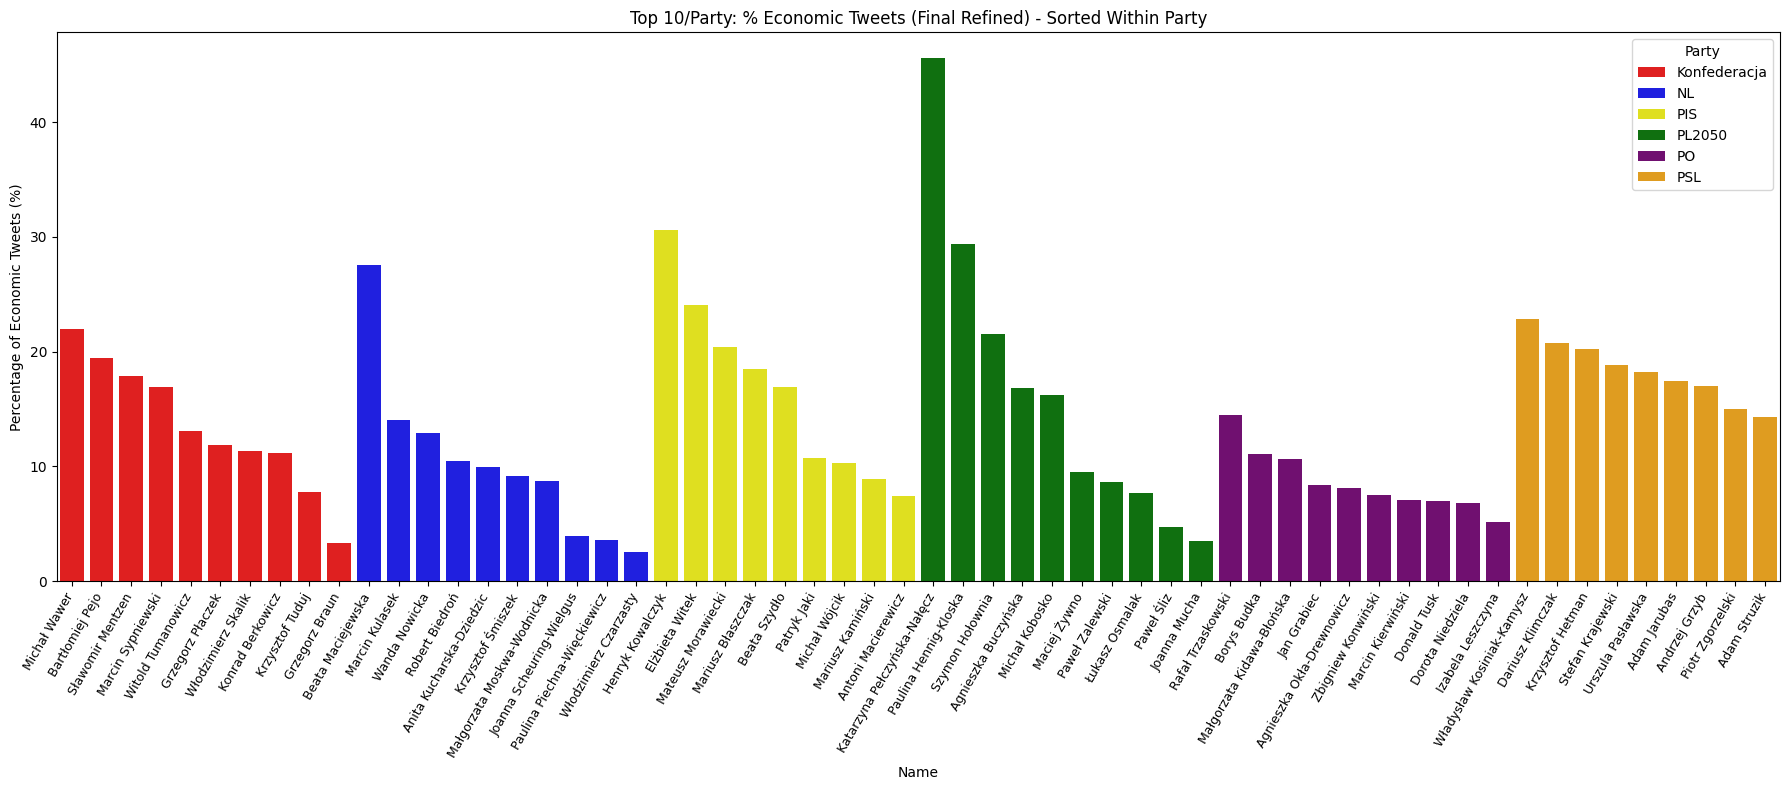

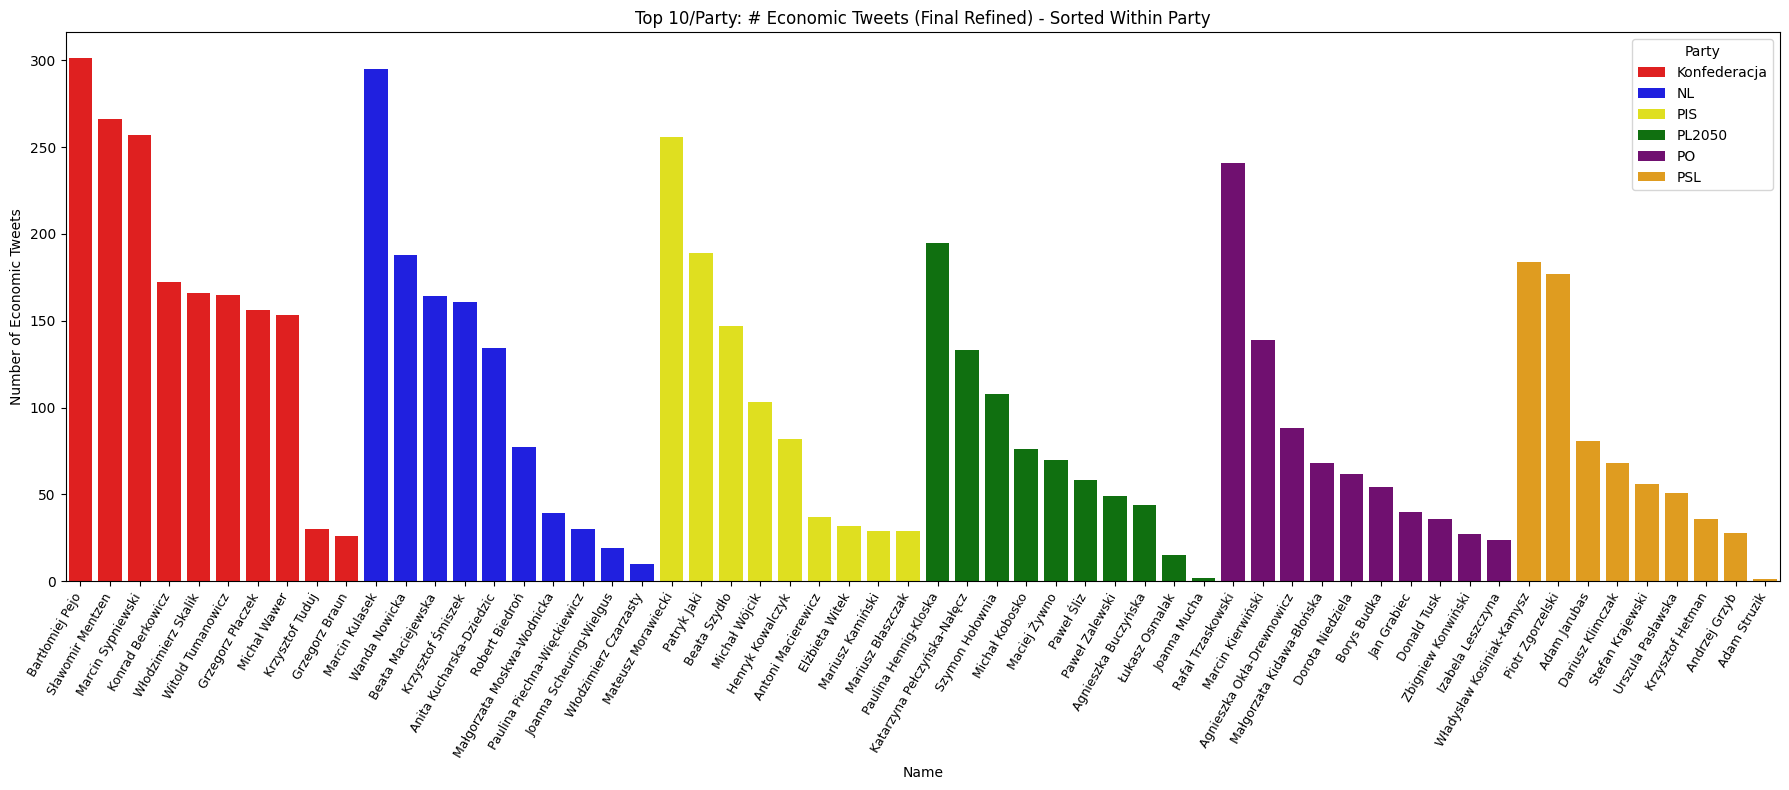

------------------------------

--- 9.C: Overall Top People Plots (Final Refined Method - Sorted Globally) ---
Generating overall plots based on the 58 users identified from Final Refined method...


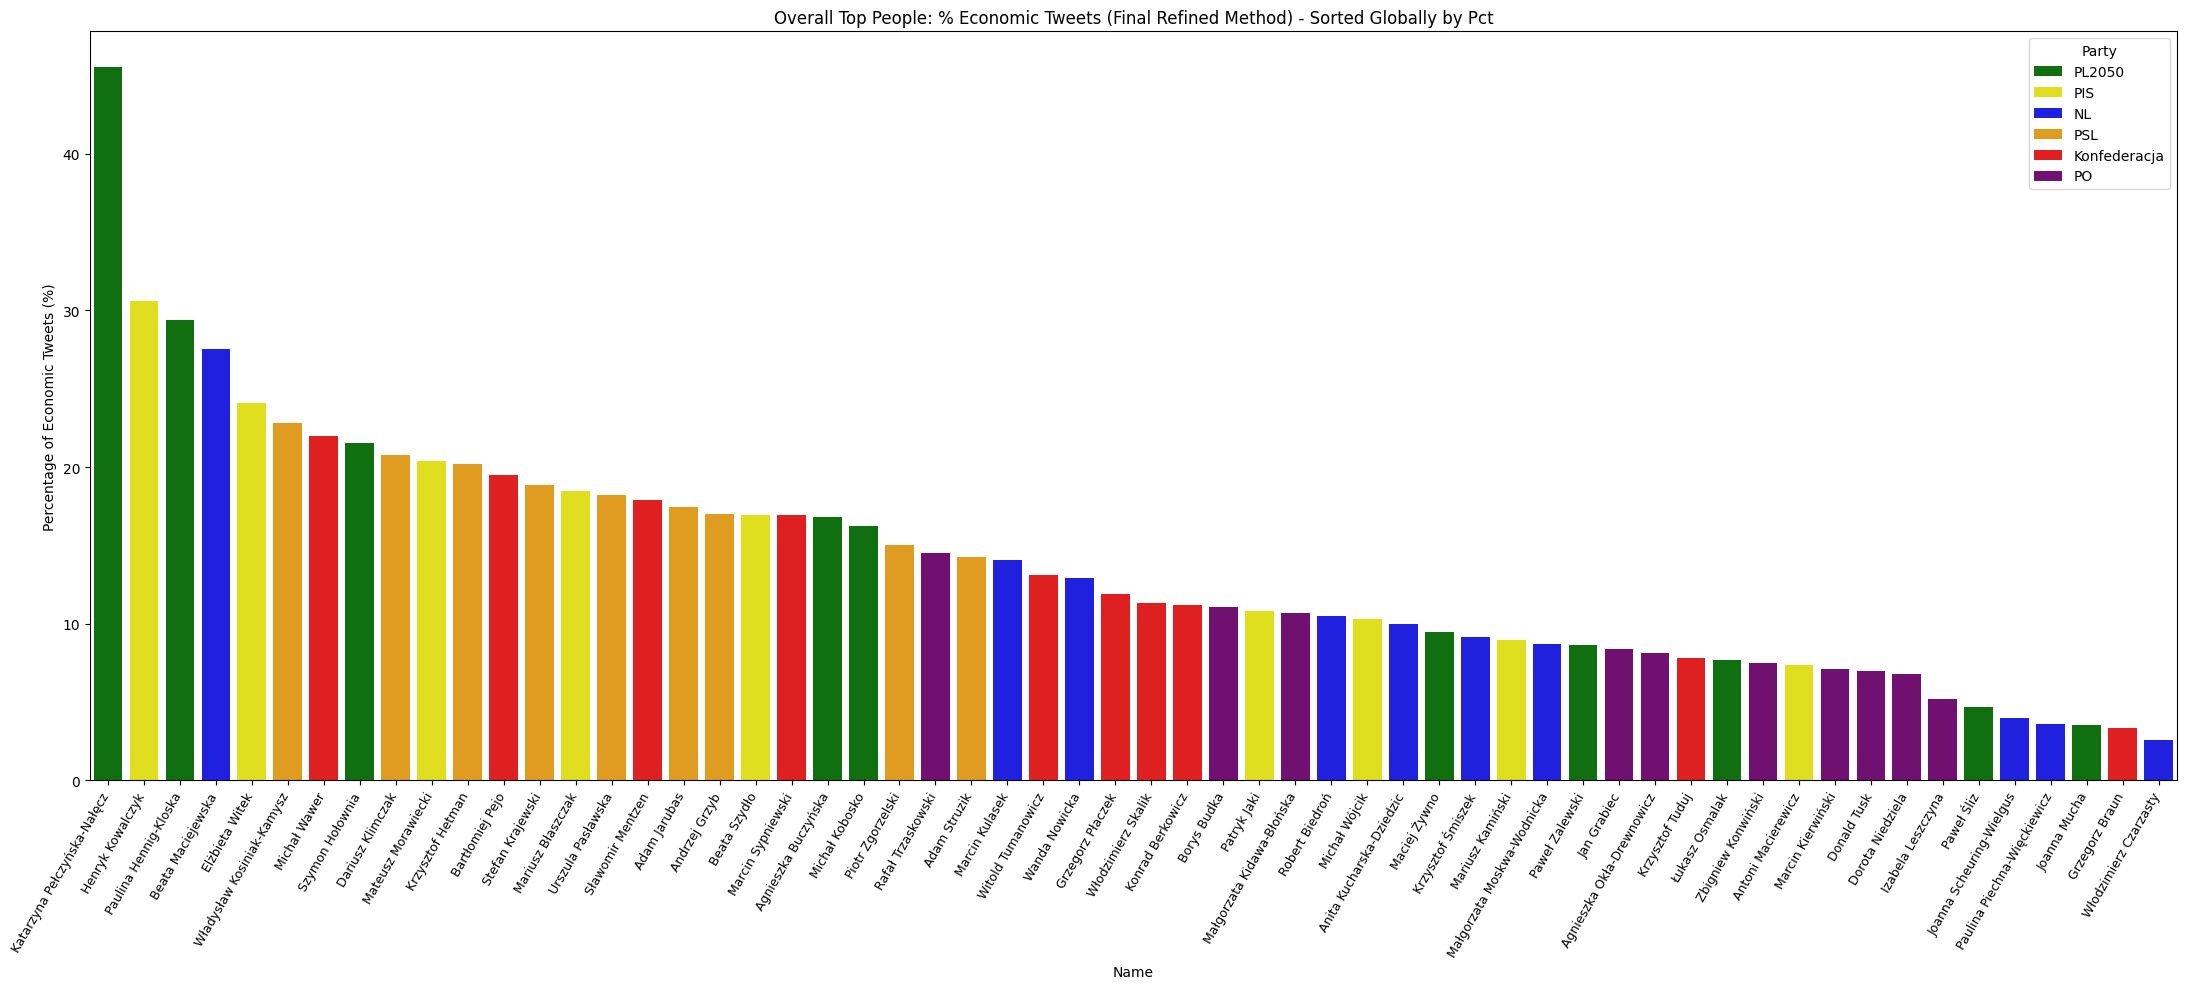

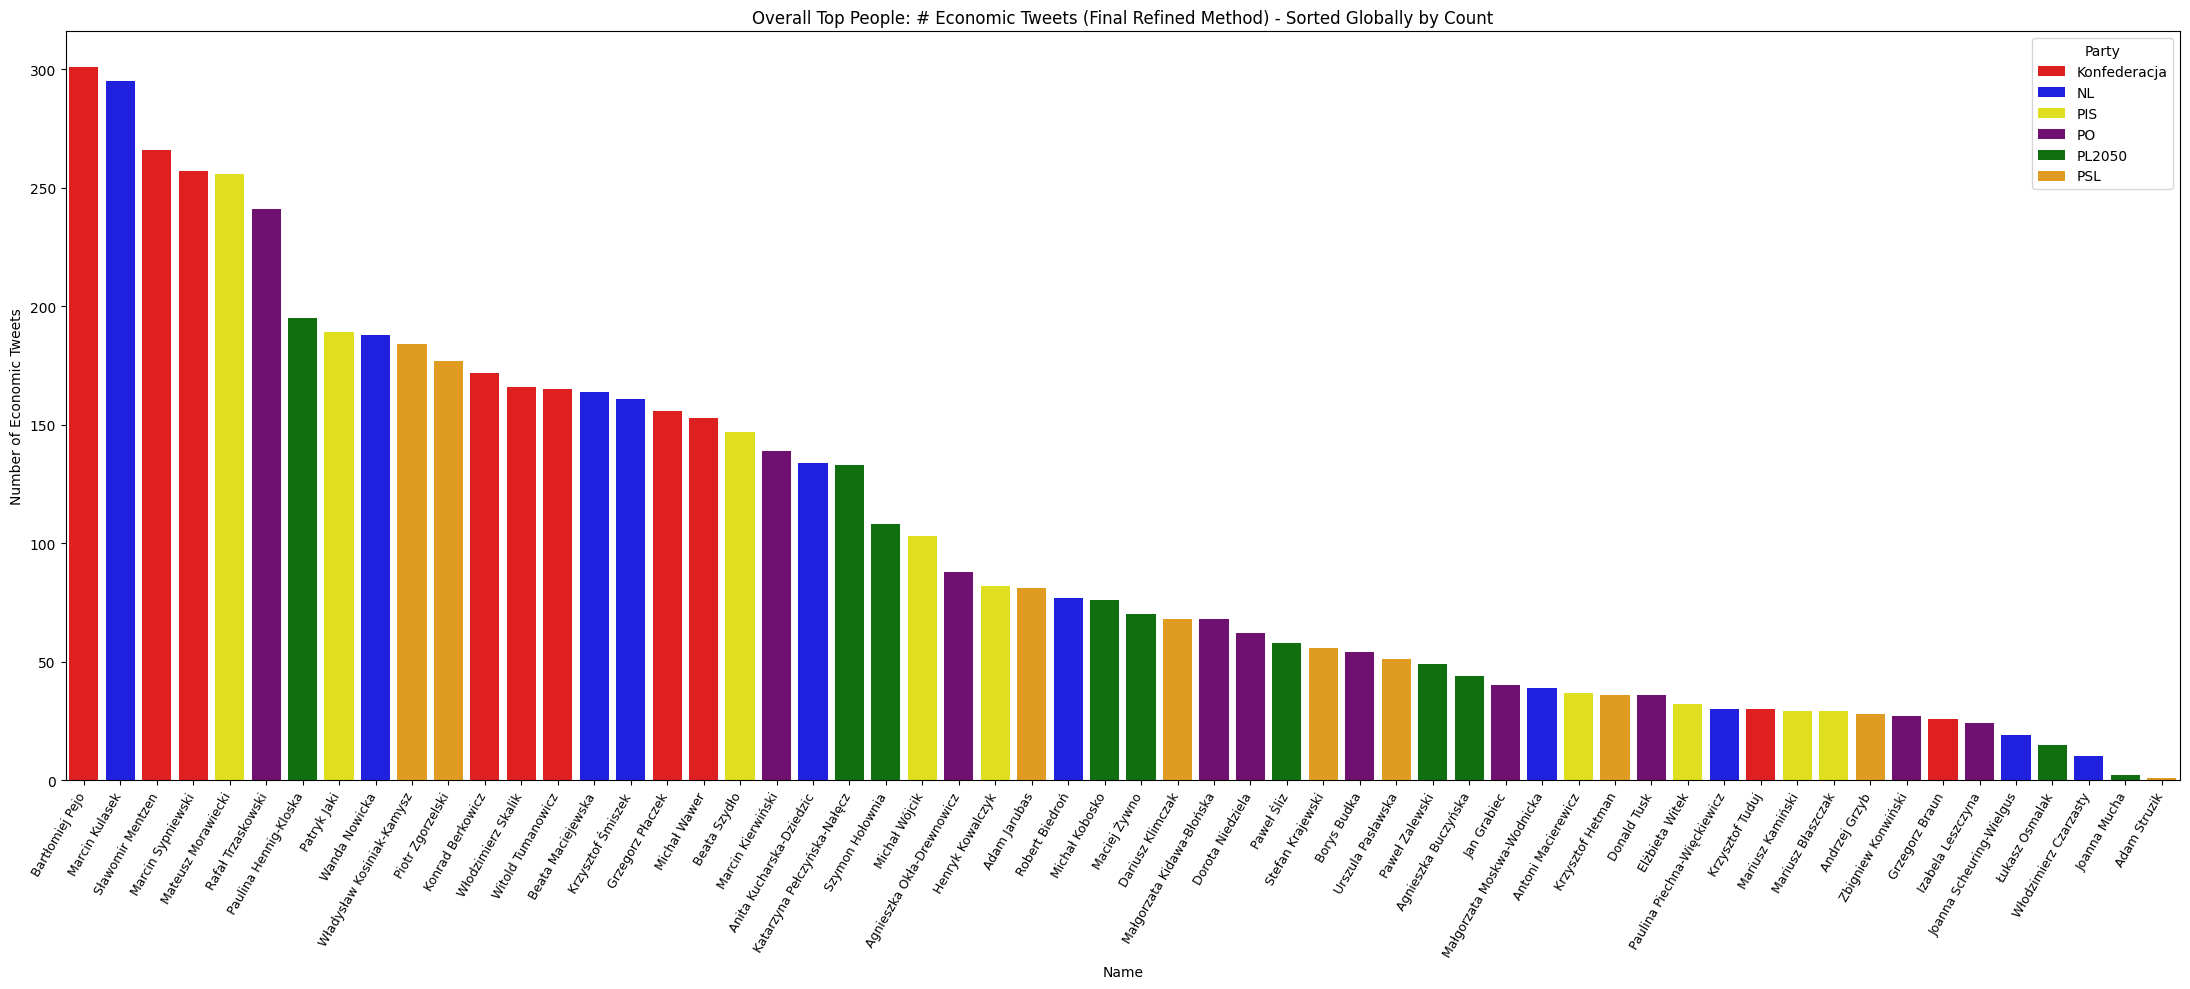


--- Top People Analysis Section Complete ---


In [62]:
# ==============================================================================
# 9. TOP PEOPLE POSTING ANALYSIS (Per Method & Overall)
# ==============================================================================
# This section analyzes which users post the most overall and the most economic tweets, broken down by party and method, using specified party colors.
# Plots show users sorted WITHIN party for each method, and then plots sorted OVERALL for the Final Refined method.

# Import necessary for transforms
import matplotlib.transforms as mtransforms

# Only run if party analysis is generally enabled (set in Section 7)
# and top people analysis is runnable (checks for user_col and party_colors)
if 'run_party_analysis' in locals() and run_party_analysis:
    print("\n--- 9. Top People Posting Analysis ---")

    # --- Configuration ---
    # party_col should be defined in Section 7 (e.g., party_col = 'party')
    # party_colors should be defined in Section 7
    user_col = 'name' # !!! CHECK IF NAME OF THE VARIABLE IS CORRECT !!!
    top_n_people = 10 # Number of top people per party to analyze

    # Check required columns for the section
    if user_col not in df_clean_translated.columns:
         print(f"ERROR: User column '{user_col}' not found. Skipping Top People Analysis.")
         run_top_people_analysis = False
    elif 'party_colors' not in locals() or not isinstance(party_colors, dict): # Ensure party_colors is a dict
         print("ERROR: 'party_colors' dictionary not found or not a dictionary. Skipping Top People Analysis.")
         run_top_people_analysis = False
    else:
         run_top_people_analysis = True # Set to True if checks pass

# Only proceed if columns exist AND initial party analysis was set to run
if 'run_party_analysis' in locals() and run_party_analysis and 'run_top_people_analysis' in locals() and run_top_people_analysis:


    # --------------------------------------------------------------------------
    # 9.A: Define Helper Functions
    # --------------------------------------------------------------------------
# (Located in Section 9.A: Define Helper Functions)

    def top_people_economic_party(df, user_col='name', party_col='party', econ_flag_col='union_flag', top_n=10):
        """ Calculates top N posters per party based on total tweets and their economic tweet stats. """

        if not all(c in df.columns for c in [user_col, party_col, econ_flag_col]):
            print(f"Warning: Missing columns in top_people_economic_party ({user_col}, {party_col}, {econ_flag_col}). Returning empty DF.")
            return pd.DataFrame([], columns=[party_col, user_col, 'total_tweets', 'econ_tweets', 'econ_pct'])

        # Calculate total tweets per user and party
        total_tweets = df.groupby([party_col, user_col]).size().rename("total_tweets")

        # Calculate economic tweets per user and party
        # Ensure econ_flag_col is boolean for correct filtering and sum
        econ_tweets = df[df[econ_flag_col].astype(bool)].groupby([party_col, user_col]).size().rename("econ_tweets")

        # Combine into a single DataFrame
        df_users = pd.concat([total_tweets, econ_tweets], axis=1).fillna(0) # Fill NaN econ_tweets with 0
        df_users['econ_tweets'] = df_users['econ_tweets'].astype(int) # Ensure integer counts

        # Calculate percentage of economic tweets for each user
        # Replace potential 0 in total_tweets with NaN to avoid division by zero, then fill resulting NaN with 0
        df_users['econ_pct'] = (df_users['econ_tweets'] / df_users['total_tweets'].replace(0, np.nan) * 100).fillna(0)
        
        df_users = df_users.reset_index() # 'party' and 'user_col' are now guaranteed columns

        # --- Get top N users per party based on *total* tweets ---
        # This pattern is generally more robust for getting top N per group while keeping group keys as columns.
        top_users = (df_users.sort_values(["total_tweets"], ascending=[False])
                    .groupby(party_col, group_keys=False)
                    .head(top_n))

        # Final sort for presentation
        return top_users.sort_values([party_col, 'total_tweets'], ascending=[True, False])


    def plot_top_people_by_party_sorted(top_users_df, party_colors_dict, method_name, top_n=10, user_col='name', party_col='party', figsize=(18, 8), x_label_rotation=60, x_label_ha='right', x_offset_points=0):
        """ Plots % and # of economic tweets for top users, sorted WITHIN party, colored by party. """
        if top_users_df.empty: print(f"Info: Empty DataFrame for plot_top_people_by_party_sorted ('{method_name}'). Skipping."); return
        if not all(c in top_users_df.columns for c in [party_col, user_col, 'econ_pct', 'econ_tweets']): print(f"Warning: Missing columns in plot_top_people_by_party_sorted ('{method_name}'). Skipping."); return
        if not isinstance(party_colors_dict, dict): print(f"Warning: Invalid party_colors_dict ('{method_name}'). Skipping."); return

        print(f"\nGenerating Top People plots (Sorted Within Party) for: {method_name} Approach")
        
        # --- Plot 1: Percentage (Sorted within Party) ---
        try:
            top_users_sorted_pct = top_users_df.sort_values(by=[party_col, 'econ_pct'], ascending=[True, False])
            fig1, ax1 = plt.subplots(figsize=figsize)
            sns.barplot(data=top_users_sorted_pct, x=user_col, y='econ_pct', hue=party_col,
                        palette=party_colors_dict, dodge=False, ax=ax1)
            ax1.set_title(f"Top {top_n}/Party: % Economic Tweets ({method_name}) - Sorted Within Party")
            ax1.set_xlabel(user_col.capitalize()); ax1.set_ylabel("Percentage of Economic Tweets (%)")
            
            ax1.set_xticks(ax1.get_xticks()) # Mitigate UserWarning
            ax1.set_xticklabels(ax1.get_xticklabels(), rotation=x_label_rotation, ha=x_label_ha, fontsize=9)
            if x_offset_points != 0:
                dx = x_offset_points / 72.; dy = 0.
                offset = mtransforms.ScaledTranslation(dx, dy, fig1.dpi_scale_trans)
                for label in ax1.xaxis.get_majorticklabels():
                    label.set_transform(label.get_transform() + offset)
            
            ax1.legend(title=party_col.capitalize(), loc='upper right'); # Legend inside
            plt.tight_layout(); plt.show()
        except Exception as e: print(f"Error plotting percentage chart for {method_name}: {e}")

        # --- Plot 2: Count (Sorted within Party) ---
        try:
            top_users_sorted_count = top_users_df.sort_values(by=[party_col, 'econ_tweets'], ascending=[True, False])
            fig2, ax2 = plt.subplots(figsize=figsize)
            sns.barplot(data=top_users_sorted_count, x=user_col, y='econ_tweets', hue=party_col,
                        palette=party_colors_dict, dodge=False, ax=ax2)
            ax2.set_title(f"Top {top_n}/Party: # Economic Tweets ({method_name}) - Sorted Within Party")
            ax2.set_xlabel(user_col.capitalize()); ax2.set_ylabel("Number of Economic Tweets")

            ax2.set_xticks(ax2.get_xticks()) # Mitigate UserWarning
            ax2.set_xticklabels(ax2.get_xticklabels(), rotation=x_label_rotation, ha=x_label_ha, fontsize=9)
            if x_offset_points != 0:
                dx = x_offset_points / 72.; dy = 0.
                offset = mtransforms.ScaledTranslation(dx, dy, fig2.dpi_scale_trans)
                for label in ax2.xaxis.get_majorticklabels():
                    label.set_transform(label.get_transform() + offset)

            ax2.legend(title=party_col.capitalize(), loc='upper right'); # Legend inside
            plt.tight_layout(); plt.show()
        except Exception as e: print(f"Error plotting count chart for {method_name}: {e}")

    print("Helper functions defined for Top People analysis.")
    print("-" * 60)


    # --------------------------------------------------------------------------
    # 9.B: Generate Top People Data & Party-Sorted Plots (Method by Method)
    # --------------------------------------------------------------------------
    # --- Define x-axis label parameters for party-sorted plots ---
    PARTY_SORTED_X_ROTATION = 60
    PARTY_SORTED_X_HA = 'right'  # 'center' or 'right'
    PARTY_SORTED_X_OFFSET = 3    # Points to shift right (positive) or left (negative)

    top_people_union = pd.DataFrame() # Initialize to avoid NameError if a block is skipped
    top_people_gateway = pd.DataFrame()
    top_people_final = pd.DataFrame()


    # # --- Union Approach ---
    # # Comment it comment out this block if not needed
    # print("\n--- 9.B.1: Top People Analysis - Union Approach ---")
    # union_flag_col = 'union_flag'
    # if union_flag_col in df_clean_translated.columns:
    #     top_people_union = top_people_economic_party(
    #         df_clean_translated, user_col=user_col, party_col=party_col,
    #         econ_flag_col=union_flag_col, top_n=top_n_people)
    #     print(f"Top {top_n_people} People Posting (Union Approach, by total tweets per party):")
    #     try: display(top_people_union)
    #     except NameError: print(top_people_union.to_string())
    #     if not top_people_union.empty : # Only plot if data exists
    #          plot_top_people_by_party_sorted(
    #              top_people_union, party_colors, "Union", top_n=top_n_people,
    #              user_col=user_col, party_col=party_col,
    #              x_label_rotation=PARTY_SORTED_X_ROTATION, x_label_ha=PARTY_SORTED_X_HA, x_offset_points=PARTY_SORTED_X_OFFSET)
    # else: print(f"Skipping Union Top People analysis: Flag column '{union_flag_col}' not found.")
    # print("-" * 60)
    # ###---### End Union ---###


    # # --- Gateway Approach ---
    # # Comment it out this block if not needed
    # print("\n--- 9.B.2: Top People Analysis - Gateway Approach ---")
    # gateway_flag_col = 'gateway_flag'
    # if gateway_flag_col in df_clean_translated.columns:
    #     top_people_gateway = top_people_economic_party(
    #         df_clean_translated, user_col=user_col, party_col=party_col,
    #         econ_flag_col=gateway_flag_col, top_n=top_n_people)
    #     print(f"Top {top_n_people} People Posting (Gateway Approach, by total tweets per party):")
    #     try: display(top_people_gateway)
    #     except NameError: print(top_people_gateway.to_string())
    #     if not top_people_gateway.empty: # Only plot if data exists
    #         plot_top_people_by_party_sorted(
    #             top_people_gateway, party_colors, "Gateway", top_n=top_n_people,
    #             user_col=user_col, party_col=party_col,
    #             x_label_rotation=PARTY_SORTED_X_ROTATION, x_label_ha=PARTY_SORTED_X_HA, x_offset_points=PARTY_SORTED_X_OFFSET)
    # else: print(f"Skipping Gateway Top People analysis: Flag column '{gateway_flag_col}' not found.")
    # print("-" * 60)
    # ###---### End Gateway ---###


    # --- Final Refined Approach ---
    # You can comment out this block if not needed
    print("\n--- 9.B.3: Top People Analysis - Final Refined Approach ---")
    final_flag_col_tp = 'has_econ_term_FILTERED' # Use final flag name
    if final_flag_col_tp in df_clean_translated.columns:
        top_people_final = top_people_economic_party(
            df_clean_translated, user_col=user_col, party_col=party_col,
            econ_flag_col=final_flag_col_tp, top_n=top_n_people)
        print(f"Top {top_n_people} People Posting (Final Refined Approach, by total tweets per party):")
        try: display(top_people_final)
        except NameError: print(top_people_final.to_string())
        if not top_people_final.empty: # Only plot if data exists
            plot_top_people_by_party_sorted(
                top_people_final, party_colors, "Final Refined", top_n=top_n_people,
                user_col=user_col, party_col=party_col,
                x_label_rotation=PARTY_SORTED_X_ROTATION, x_label_ha=PARTY_SORTED_X_HA, x_offset_points=PARTY_SORTED_X_OFFSET)
    else: print(f"Skipping Final Refined Top People analysis: Flag column '{final_flag_col_tp}' not found.")
    print("-" * 30)
    ###---### End Final Refined ---###


    # --------------------------------------------------------------------------
    # 9.C: Overall Top People Plots (Final Refined Method - Sorted Globally)
    # --------------------------------------------------------------------------
    print("\n--- 9.C: Overall Top People Plots (Final Refined Method - Sorted Globally) ---")

    # Define x-axis label parameters for these overall plots
    OVERALL_X_ROTATION = 60
    OVERALL_X_HA = 'right'
    OVERALL_X_OFFSET = 3 # Adjust as needed

    if 'top_people_final' not in locals() or top_people_final.empty:
        print("Skipping overall plots: 'top_people_final' DataFrame is empty or not created (likely its source method was skipped or had no data).")
    else:
        print(f"Generating overall plots based on the {len(top_people_final)} users identified from Final Refined method...")
        overall_figsize = (22, 10) # Wider for more names

        # --- Plot 1: Overall Percentage (Sorted Globally) ---
        try:
            overall_sorted_pct = top_people_final.sort_values(by="econ_pct", ascending=False)
            overall_order_pct = overall_sorted_pct[user_col].tolist()
            fig_ov_pct, ax_ov_pct = plt.subplots(figsize=overall_figsize)
            sns.barplot(data=overall_sorted_pct, x=user_col, y='econ_pct', hue=party_col,
                        order=overall_order_pct, palette=party_colors, dodge=False, ax=ax_ov_pct)
            ax_ov_pct.set_title(f"Overall Top People: % Economic Tweets (Final Refined Method) - Sorted Globally by Pct")
            ax_ov_pct.set_xlabel(user_col.capitalize()); ax_ov_pct.set_ylabel("Percentage of Economic Tweets (%)")
            ax_ov_pct.set_xticks(ax_ov_pct.get_xticks())
            ax_ov_pct.set_xticklabels(ax_ov_pct.get_xticklabels(), rotation=OVERALL_X_ROTATION, ha=OVERALL_X_HA, fontsize=9)
            if OVERALL_X_OFFSET != 0:
                dx = OVERALL_X_OFFSET / 72.; dy = 0.
                offset = mtransforms.ScaledTranslation(dx, dy, fig_ov_pct.dpi_scale_trans)
                for label in ax_ov_pct.xaxis.get_majorticklabels():
                    label.set_transform(label.get_transform() + offset)
            ax_ov_pct.legend(title=party_col.capitalize(), loc='upper right');
            plt.tight_layout(); plt.show()
        except Exception as e: print(f"Error plotting overall percentage chart: {e}")

        # --- Plot 2: Overall Count (Sorted Globally) ---
        try:
            overall_sorted_count = top_people_final.sort_values(by="econ_tweets", ascending=False)
            overall_order_count = overall_sorted_count[user_col].tolist()
            fig_ov_count, ax_ov_count = plt.subplots(figsize=overall_figsize)
            sns.barplot(data=overall_sorted_count, x=user_col, y='econ_tweets', hue=party_col,
                        order=overall_order_count, palette=party_colors, dodge=False, ax=ax_ov_count)
            ax_ov_count.set_title(f"Overall Top People: # Economic Tweets (Final Refined Method) - Sorted Globally by Count")
            ax_ov_count.set_xlabel(user_col.capitalize()); ax_ov_count.set_ylabel("Number of Economic Tweets")
            ax_ov_count.set_xticks(ax_ov_count.get_xticks())
            ax_ov_count.set_xticklabels(ax_ov_count.get_xticklabels(), rotation=OVERALL_X_ROTATION, ha=OVERALL_X_HA, fontsize=9)
            if OVERALL_X_OFFSET != 0:
                dx = OVERALL_X_OFFSET / 72.; dy = 0.
                offset = mtransforms.ScaledTranslation(dx, dy, fig_ov_count.dpi_scale_trans)
                for label in ax_ov_count.xaxis.get_majorticklabels():
                    label.set_transform(label.get_transform() + offset)
            ax_ov_count.legend(title=party_col.capitalize(), loc='upper right');
            plt.tight_layout(); plt.show()
        except Exception as e: print(f"Error plotting overall count chart: {e}")

# Final completion message
if 'run_party_analysis' in locals() and run_party_analysis and 'run_top_people_analysis' in locals() and run_top_people_analysis:
    print("\n" + "="*60)
    print("--- Top People Analysis Section Complete ---")
    print("="*60)


--- Inspecting Specific Tweets (with Person's Keyword Stats) ---

--- Inspection Criteria & Overall Stats ---
Focusing on user: 'Katarzyna Pełczyńska-Nałęcz'

Total tweets for user 'Katarzyna Pełczyńska-Nałęcz': 292
Tweets flagged by 'has_econ_term_FILTERED' for user 'Katarzyna Pełczyńska-Nałęcz': 133 (45.55%)

--- Keyword Distribution for Katarzyna Pełczyńska-Nałęcz's Economic Tweets (flagged by 'has_econ_term_FILTERED') ---
Top 15 keywords used by Katarzyna Pełczyńska-Nałęcz in these 133 economic tweets:


Keyword  Frequency
3             fund         51
0       investment         29
1      development         22
6           energy         16
9    entrepreneurs         12
4           budget         11
19         economy         11
5          finance         10
7   infrastructure          9
2         industry          6
12       economics          4
13     innovations          4
14          market          4
17          crisis          4
28             GDP          3

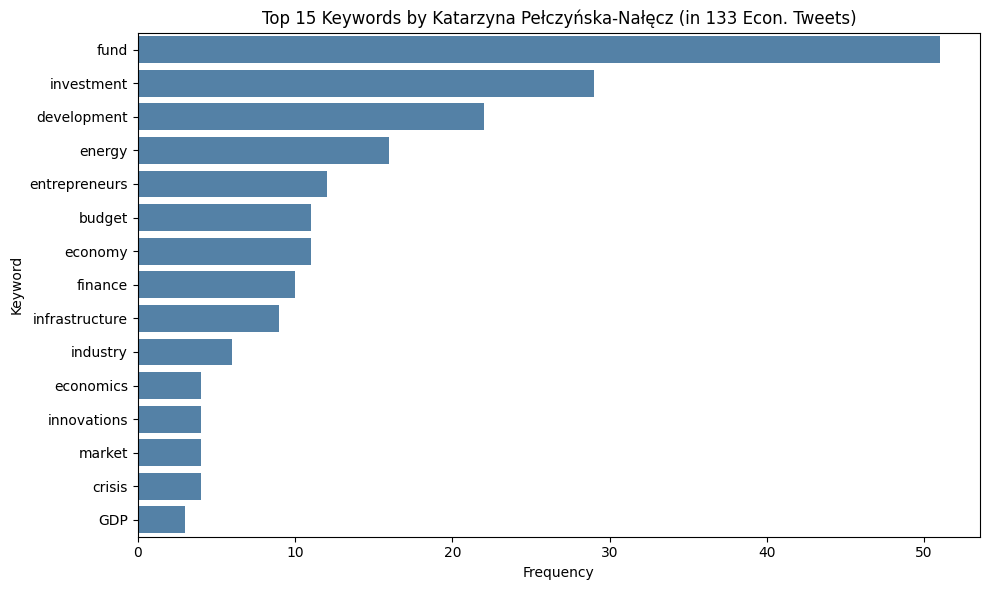

------------------------------

Filtering the 133 economic tweets for keyword: 'fund' (for sampling)...
Found 51 tweets also containing 'fund'.
------------------------------

Displaying a random sample of 10 (out of 51) tweets matching ALL criteria:


id                         name  \
38654  1797592928493453824  Katarzyna Pełczyńska-Nałęcz   
38571  1836051857657192704  Katarzyna Pełczyńska-Nałęcz   
38673  1783432940547924224  Katarzyna Pełczyńska-Nałęcz   
38733  1750820462362284544  Katarzyna Pełczyńska-Nałęcz   
38566  1838187441703842048  Katarzyna Pełczyńska-Nałęcz   
38689  1775562951543455744  Katarzyna Pełczyńska-Nałęcz   
38651  1798281641569272320  Katarzyna Pełczyńska-Nałęcz   
38600  1825920618266578944  Katarzyna Pełczyńska-Nałęcz   
38739  1747879919965622784  Katarzyna Pełczyńska-Nałęcz   
38726  1753063382780186880  Katarzyna Pełczyńska-Nałęcz   

                                                                                                                                               text_clean_en  \
38654  I confirm. Red is bad did not receive subsidies from European funds. EU subsidies need to be accounted for, money from PiS does not necessarily ha...   
38571  PLN 1.5 billion - this is how much we will redirect funds 🇪 🇺 🇵 🇱 to reconstruction after the flood.   These are funds for the renovation of singl...   
38673  Record payouts from KPO. As I announced, we already have funds in Poland, so we are accelerating our investments. Today we pay out:  👉 PLN 507 mil...   
38733  A loan fund is launched - PLN 450 million for reduced loans for small companies in eastern Poland. We support the tourism industry in the regions ...   
38566  We are creating a new priority in European Funds: Reconstruction after the flood and strengthening resilience.   I have consulted with local gover...   
38689  As promised, we are accelerating investments from EU funds and KPO! In April, we will announce 36 new competitions in addition to the 97 competiti...   
38651  Direction: Białowieża. Purpose: consultations with local government officials and entrepreneurs.   I want to hear from those interested themselves...   
38600  Today, at the Council of Ministers, I presented a report on the implementation of the #KPO.  We just reached 555,000. signed contracts with benefi...   
38739  Today, the payment of funds from the KPO: new places in nurseries - PLN 1 million (ultimately 47.5 thousand places), modernization of SMEs in agri...   
38726  In a women's group (as it happened:) about support for entrepreneurs from funds 🇪 🇺 🇵 🇱 . Thank you for the conversation and I invite you to conti...   

       has_econ_term_FILTERED  \
38654                    True   
38571                    True   
38673                    True   
38733                    True   
38566                    True   
38689                    True   
38651                    True   
38600                    True   
38739                    True   
38726                    True   

                                  matched_keywords_FILTERED  \
38654                                                [fund]   
38571                        [fund, energy, infrastructure]   
38673                                    [fund, investment]   
38733                                      [fund, industry]   
38566                        [fund, energy, infrastructure]   
38689  [fund, economy, entrepreneurs, industry, investment]   
38651                                 [fund, entrepreneurs]   
38600                                                [fund]   
38739                                                [fund]   
38726                                 [fund, entrepreneurs]   

                                     extracted_terms_FILTERED  
38654                                                 [funds]  
38571                         [energy, funds, infrastructure]  
38673                                    [investments, funds]  
38733                                        [fund, industry]  
38566                         [Energy, Funds, infrastructure]  
38689  [economy, entrepreneurs, investments, industry, funds]  
38651                                  [funds, entrepreneurs]  
38600                                      


--- Tweet Inspection Section Complete ---
--------------------------------------------------


In [63]:
# ==============================================================================
# SECTION 9 CHECK: INSPECT SPECIFIC TWEETS (with Person's Keyword Stats)
# ==============================================================================
# This section allows inspecting a RANDOM SAMPLE of tweets based on:
# - A specific person (optional) - if so, shows their keyword distribution.
# - A specific keyword within their matched keywords (optional for sampling).
# - A specific flagging method.
# It also provides summary statistics based on these criteria.

print("\n" + "="*60)
print("--- Inspecting Specific Tweets (with Person's Keyword Stats) ---")
print("="*60)

# --- Configuration ---
user_col_inspect = 'name' # This should match the column with author names
id_col_inspect = 'id'     # Unique tweet ID column
text_col_inspect = 'text_clean_en'

# !!! --- DEFINE YOUR INSPECTION CRITERIA BELOW --- !!!
# 1. OPTIONAL: Specify a person to filter by.
person_to_inspect = "Katarzyna Pełczyńska-Nałęcz"  # Example, REPLACE THIS or set to None
# person_to_inspect = None # Example: To select from all users

# 2. OPTIONAL: Specify a keyword to filter by FOR SAMPLING.
#    The script will look for this keyword in the 'kw_col_to_inspect' for the random sample.
#    Set to None or "" to not filter the random sample by a specific keyword.
keyword_to_filter_by_sample = 'fund'  # Example: 'inflation' or 'bank' or None

# 3. Choose the method's flag and keyword columns for initial filtering & stats
flag_to_inspect = 'has_econ_term_FILTERED'
kw_col_to_inspect = 'matched_keywords_FILTERED' # This is used for person's keyword stats AND keyword_to_filter_by_sample
extracted_col_inspect = 'extracted_terms_FILTERED' # Contextual: 'extracted_terms_FILTERED' or None

n_tweets_to_show_sample = 10 # How many random tweets to show that match ALL criteria
top_n_person_keywords = 15 # How many top keywords to show for the specified person
# --- End Configuration ---

# Check if the base DataFrame and essential columns exist
if 'df_clean_translated' not in globals() or df_clean_translated.empty:
    print("ERROR: 'df_clean_translated' DataFrame not found or is empty. Skipping inspection.")
elif user_col_inspect not in df_clean_translated.columns:
    print(f"ERROR: User column '{user_col_inspect}' not found. Skipping inspection.")
elif flag_to_inspect not in df_clean_translated.columns:
    print(f"ERROR: Flag column '{flag_to_inspect}' not found. Skipping inspection.")
elif kw_col_to_inspect not in df_clean_translated.columns:
    print(f"ERROR: Keyword column '{kw_col_to_inspect}' not found. Skipping inspection.")
else:
    print("\n--- Inspection Criteria & Overall Stats ---")
    target_df_for_stats = df_clean_translated

    if person_to_inspect:
        print(f"Focusing on user: '{person_to_inspect}'")
        target_df_for_stats = df_clean_translated[df_clean_translated[user_col_inspect] == person_to_inspect].copy()
        if target_df_for_stats.empty:
            print(f"No tweets found for user '{person_to_inspect}'. Check spelling/case/remapping.")
            target_df_for_stats = None # Indicates error or no data for person
    else:
        print("Considering all users for initial stats and sampling pool.")

    if target_df_for_stats is not None and not target_df_for_stats.empty:
        total_tweets_in_scope = len(target_df_for_stats)
        econ_tweets_in_scope_df = target_df_for_stats[target_df_for_stats[flag_to_inspect] == True].copy()
        econ_tweets_in_scope_count = len(econ_tweets_in_scope_df)
        pct_econ_in_scope = (econ_tweets_in_scope_count / total_tweets_in_scope * 100) if total_tweets_in_scope > 0 else 0

        scope_description = f"for user '{person_to_inspect}'" if person_to_inspect else "in the dataset"
        print(f"\nTotal tweets {scope_description}: {total_tweets_in_scope}")
        print(f"Tweets flagged by '{flag_to_inspect}' {scope_description}: {econ_tweets_in_scope_count} ({pct_econ_in_scope:.2f}%)")

        # --- Keyword Distribution for Specified Person's Economic Tweets ---
        if person_to_inspect and not econ_tweets_in_scope_df.empty:
            print(f"\n--- Keyword Distribution for {person_to_inspect}'s Economic Tweets (flagged by '{flag_to_inspect}') ---")
            person_keywords_list = [
                kw for sublist in econ_tweets_in_scope_df[kw_col_to_inspect]
                if isinstance(sublist, list) for kw in sublist
            ]
            if person_keywords_list:
                person_keyword_counts = Counter(person_keywords_list)
                df_person_kw_counts = pd.DataFrame(person_keyword_counts.items(), columns=['Keyword', 'Frequency'])
                df_person_kw_counts = df_person_kw_counts.sort_values(by='Frequency', ascending=False)

                print(f"Top {top_n_person_keywords} keywords used by {person_to_inspect} in these {econ_tweets_in_scope_count} economic tweets:")
                try:
                    display(df_person_kw_counts.head(top_n_person_keywords))
                except NameError:
                    print(df_person_kw_counts.head(top_n_person_keywords).to_string())

                # Optional: Plot bar chart for this person's top keywords
                plt.figure(figsize=(10, max(6, top_n_person_keywords * 0.4))) # Dynamic height
                top_plot_data = df_person_kw_counts.head(top_n_person_keywords)
                sns.barplot(data=top_plot_data, y='Keyword', x='Frequency', color='steelblue')
                plt.title(f"Top {top_n_person_keywords} Keywords by {person_to_inspect} (in {econ_tweets_in_scope_count} Econ. Tweets)")
                plt.xlabel("Frequency"); plt.ylabel("Keyword")
                plt.tight_layout(); plt.show()
            else:
                print(f"No matched keywords found in the economic tweets for {person_to_inspect} using column '{kw_col_to_inspect}'.")
            print("-" * 30)
        # --- End Person's Keyword Distribution ---

        df_final_pool = econ_tweets_in_scope_df # Start with economic tweets in current scope

        if keyword_to_filter_by_sample: # Now filter this pool for sampling
            print(f"\nFiltering the {len(df_final_pool)} economic tweets for keyword: '{keyword_to_filter_by_sample}' (for sampling)...")
            mask_contains_keyword_sample = df_final_pool[kw_col_to_inspect].apply(
                lambda lst: isinstance(lst, list) and keyword_to_filter_by_sample in lst
            )
            df_final_pool = df_final_pool[mask_contains_keyword_sample].copy()
            print(f"Found {len(df_final_pool)} tweets also containing '{keyword_to_filter_by_sample}'.")
        else:
            print(f"\nNo specific keyword filter for sampling. Will sample from all {len(df_final_pool)} economic tweets in scope.")
        print("-" * 30)

        # --- Sample and Display ---
        count_final_pool = len(df_final_pool)
        if count_final_pool > 0:
            actual_sample_size = min(n_tweets_to_show_sample, count_final_pool)
            print(f"\nDisplaying a random sample of {actual_sample_size} (out of {count_final_pool}) tweets matching ALL criteria:")
            df_sample_to_show = df_final_pool.sample(n=actual_sample_size, random_state=None)
            cols_to_display_inspect = [text_col_inspect, flag_to_inspect, kw_col_to_inspect]
            if extracted_col_inspect and extracted_col_inspect in df_sample_to_show.columns: cols_to_display_inspect.append(extracted_col_inspect)
            if id_col_inspect and id_col_inspect in df_sample_to_show.columns: cols_to_display_inspect.insert(0, id_col_inspect)
            if person_to_inspect and user_col_inspect in df_sample_to_show.columns and user_col_inspect not in cols_to_display_inspect:
                 if id_col_inspect: cols_to_display_inspect.insert(1, user_col_inspect)
                 else: cols_to_display_inspect.insert(0, user_col_inspect)
            cols_to_display_final = [c for c in cols_to_display_inspect if c in df_sample_to_show.columns]
            if not cols_to_display_final: print("Warning: No valid columns to display for the sample.")
            else:
                 try:
                     original_max_colwidth = pd.get_option('display.max_colwidth'); pd.set_option('display.max_colwidth', 150)
                     display(df_sample_to_show[cols_to_display_final])
                     pd.set_option('display.max_colwidth', original_max_colwidth)
                 except NameError: print(df_sample_to_show[cols_to_display_final].to_string())
                 except Exception as e: print(f"Error during display: {e}"); print(df_sample_to_show[cols_to_display_final].to_string())
        else:
            print("No tweets found matching all specified criteria to sample from.")
    elif target_df_for_stats is None: pass # Error already printed
    else: print("Initial DataFrame 'df_clean_translated' (or filtered by person) is empty.")

print("\n--- Tweet Inspection Section Complete ---")
print("-" * 50)

In [64]:
# ==============================================================================
# SECTION 10: TIME SERIES ANALYSIS & VISUALIZATION
# ==============================================================================
# This section includes:
# 10.A: Definitions of time series plotting functions with flexible annotations.
# 10.B: A calling block to generate plots for specific methods/frequencies.
# 10.C: Analysis of peaks in the time series using smoothing.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
# import matplotlib.transforms as mtransforms # Already imported 

print("\n" + "="*60)
print("--- Section 10: Time Series Analysis & Visualization ---")
print("="*60)

# ------------------------------------------------------------------------------
# SECTION 10.A: Function Definitions for Time Series Plotting
# ------------------------------------------------------------------------------
print("\n--- 10.A: Defining Time Series Plotting Functions ---")

def plot_annotated_timeseries(df, flag_col, method_name,
                              annotations=None,
                              show_custom_annotations=True,
                              election_date_str=None,
                              show_election_shading=True,
                              freq='W', figsize=(14, 7), date_col='created_at'):
    """ Plots the COUNT of flagged tweets over time with annotations. """
    print(f"\nGenerating annotated COUNT time series for: {method_name} Method")
    if annotations and show_custom_annotations: print("Custom annotations: SHOWN.")
    else: print("Custom annotations: HIDDEN or not provided.")
    if election_date_str and show_election_shading: print("Election shading: SHOWN.")
    else: print("Election shading: HIDDEN or election date not provided.")

    df_plot = df.copy()
    if date_col not in df_plot.columns: print(f"ERROR: Date column '{date_col}' not found."); return
    try:
        df_plot[date_col] = pd.to_datetime(df_plot[date_col], errors='coerce')
        df_plot.dropna(subset=[date_col], inplace=True)
        if df_plot.empty: print(f"No valid dates in '{date_col}'."); return
        df_plot = df_plot.set_index(date_col, drop=False).sort_index()
        if df_plot.index.tz is not None:
            df_plot.index = df_plot.index.tz_convert('UTC').tz_localize(None)
    except Exception as e: print(f"Error processing date column/index: {e}"); return

    if flag_col not in df_plot.columns: print(f"ERROR: Flag column '{flag_col}' not found."); return
    try: ts_counts = df_plot[flag_col].resample(freq).sum()
    except Exception as e: print(f"Error during resampling: {e}"); return
    if ts_counts.empty: print("No data after resampling for counts."); return

    plot_start_date = ts_counts.index.min(); plot_end_date = ts_counts.index.max()
    election_date = pd.to_datetime(election_date_str) if election_date_str else None
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(ts_counts.index, ts_counts.values, marker='.', linestyle='-', label=f'Economic Tweets ({method_name})', zorder=5)

    if election_date and pd.notna(plot_start_date) and pd.notna(plot_end_date) and plot_start_date <= election_date <= plot_end_date:
        ax.axvline(election_date, color='red', linestyle='--', lw=2, label=f"Parl. Elections: {election_date.strftime('%Y-%m-%d')}", zorder=10)
        if show_election_shading:
            if plot_start_date < election_date: ax.axvspan(plot_start_date, election_date, color='#DDA0DD', alpha=0.3, label='Pre-Election Period', zorder=1)
            if election_date < plot_end_date: ax.axvspan(election_date, plot_end_date, color='#90EE90', alpha=0.3, label='Post-Election Period', zorder=1)

    if annotations and show_custom_annotations:
        print("Processing custom annotations for count plot...")
        annotation_labels_used = set()
        for event in annotations:
            try:
                if 'date' in event:
                    dt = pd.to_datetime(event['date']);
                    if pd.notna(plot_start_date) and pd.notna(plot_end_date) and plot_start_date <= dt <= plot_end_date:
                        label=event.get('label', f"Evt:{event['date']}")
                        current_label = label if label not in annotation_labels_used else None
                        ax.axvline(dt, color=event.get('color', 'grey'), linestyle=event.get('linestyle', ':'), lw=event.get('linewidth', 1), label=current_label, zorder=10)
                        if current_label: annotation_labels_used.add(label)
                elif 'start_date' in event and 'end_date' in event:
                    dt_start=pd.to_datetime(event['start_date']); dt_end=pd.to_datetime(event['end_date'])
                    if pd.notna(dt_start) and pd.notna(dt_end) and dt_start <= dt_end and not (dt_end < plot_start_date or dt_start > plot_end_date):
                        label=event.get('label', f"R:{event['start_date']}-{event['end_date']}")
                        current_label = label if label not in annotation_labels_used else None
                        span_start = max(dt_start, plot_start_date); span_end = min(dt_end, plot_end_date)
                        ax.axvspan(span_start, span_end, color=event.get('color', 'cyan'), alpha=event.get('alpha', 0.2), label=current_label, zorder=1)
                        if current_label: annotation_labels_used.add(label)
                        if event.get('add_lines', False):
                            line_color=event.get('line_color', event.get('color', 'cyan')); line_style=event.get('line_style', ':'); line_width=event.get('line_width', 1)
                            if plot_start_date <= dt_start <= plot_end_date: ax.axvline(dt_start, color=line_color, linestyle=line_style, lw=line_width, zorder=9)
                            if plot_start_date <= dt_end <= plot_end_date: ax.axvline(dt_end, color=line_color, linestyle=line_style, lw=line_width, zorder=9)
            except Exception as e: print(f"Warning: Could not process custom annotation {event}. Error: {e}")

    ax.set_title(f'Economic Tweets Over Time ({freq} Freq, {method_name} Method)'); ax.set_xlabel(f'Time ({freq} ending)'); ax.set_ylabel('Number of Economic Tweets')
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1)); ax.grid(True, alpha=0.6); plt.tight_layout(rect=[0, 0, 0.88, 1]); plt.show()


def plot_top_token_timeseries(df, token_col, method_name, top_n=10, freq='W',
                              annotations=None, show_custom_annotations=True,
                              election_date_str=None, show_election_shading=True,
                              figsize=(14,8), date_col='created_at'):
    """ Plots time series for top N tokens, with annotations. """
    print(f"\nGenerating top {top_n} token time series plot for: {method_name} Method")
    if annotations and show_custom_annotations: print("Custom annotations: SHOWN.")
    else: print("Custom annotations: HIDDEN or not provided.")
    if election_date_str and show_election_shading: print("Election shading: SHOWN.")
    else: print("Election shading: HIDDEN or election date not provided.")

    df_plot = df.copy()
    if date_col not in df_plot.columns: print(f"ERROR: Date column '{date_col}' not found."); return
    try:
        df_plot[date_col] = pd.to_datetime(df_plot[date_col], errors='coerce')
        df_plot.dropna(subset=[date_col], inplace=True);
        if df_plot.empty: print(f"No valid dates in '{date_col}'."); return
        df_plot = df_plot.set_index(date_col).sort_index() # Set index directly
        if df_plot.index.tz is not None: df_plot.index = df_plot.index.tz_convert('UTC').tz_localize(None)
    except Exception as e: print(f"Error processing date column/index for top tokens: {e}"); return

    if token_col not in df_plot.columns: print(f"ERROR: Token column '{token_col}' not found."); return
    all_tokens = [t for tokens_list in df_plot[token_col] if isinstance(tokens_list, list) for t in tokens_list]
    if not all_tokens: print(f"No tokens in '{token_col}' for {method_name}."); return
    top_tokens = [token for token, count in Counter(all_tokens).most_common(top_n)]
    print(f"Top {top_n} tokens for {method_name}: {top_tokens}")

    fig, ax = plt.subplots(figsize=figsize)
    plot_start_date = None; plot_end_date = None

    for token in top_tokens:
        try:
            ts = df_plot[token_col].apply(lambda t_list: 1 if (isinstance(t_list, list) and token in t_list) else 0).resample(freq).sum()
            if not ts.empty:
                 ax.plot(ts.index, ts.values, marker='o', linestyle='-', label=token, zorder=5)
                 current_min = ts.index.min(); current_max = ts.index.max()
                 if plot_start_date is None or current_min < plot_start_date: plot_start_date = current_min
                 if plot_end_date is None or current_max > plot_end_date: plot_end_date = current_max
        except Exception as e: print(f"Error processing/plotting token '{token}': {e}")

    election_date = pd.to_datetime(election_date_str) if election_date_str else None
    if election_date and pd.notna(plot_start_date) and pd.notna(plot_end_date) and plot_start_date <= election_date <= plot_end_date:
        ax.axvline(election_date, color='red', linestyle='--', lw=1.5, label=f"Parl. Elections: {election_date.strftime('%Y-%m-%d')}", zorder=10)
        if show_election_shading:
            if plot_start_date < election_date: ax.axvspan(plot_start_date, election_date, color='#DDA0DD', alpha=0.2, zorder=1)
            if election_date < plot_end_date: ax.axvspan(election_date, plot_end_date, color='#90EE90', alpha=0.2, zorder=1)

    if annotations and show_custom_annotations:
        print("Processing custom annotations for top token plot...")
        annotation_labels_used = set()
        for event in annotations: # (Annotation logic - same as above)
            try:
                if 'date' in event:
                    dt = pd.to_datetime(event['date']);
                    if pd.notna(plot_start_date) and pd.notna(plot_end_date) and plot_start_date <= dt <= plot_end_date:
                        label=event.get('label', f"Evt:{event['date']}")
                        current_label = label if label not in annotation_labels_used else None
                        ax.axvline(dt, color=event.get('color', 'grey'), linestyle=event.get('linestyle', ':'), lw=event.get('linewidth', 1), label=current_label, zorder=10)
                        if current_label: annotation_labels_used.add(label)
                elif 'start_date' in event and 'end_date' in event:
                    dt_start=pd.to_datetime(event['start_date']); dt_end=pd.to_datetime(event['end_date'])
                    if pd.notna(dt_start) and pd.notna(dt_end) and dt_start <= dt_end and not (dt_end < plot_start_date or dt_start > plot_end_date):
                        label=event.get('label', f"R:{event['start_date']}-{event['end_date']}")
                        current_label = label if label not in annotation_labels_used else None
                        span_start = max(dt_start, plot_start_date); span_end = min(dt_end, plot_end_date)
                        ax.axvspan(span_start, span_end, color=event.get('color', 'cyan'), alpha=event.get('alpha', 0.15), label=current_label, zorder=1)
                        if current_label: annotation_labels_used.add(label)
                        if event.get('add_lines', False):
                            line_color=event.get('line_color', event.get('color', 'cyan')); line_style=event.get('line_style', ':'); line_width=event.get('line_width', 0.8)
                            if plot_start_date <= dt_start <= plot_end_date: ax.axvline(dt_start, color=line_color, linestyle=line_style, lw=line_width, zorder=9)
                            if plot_start_date <= dt_end <= plot_end_date: ax.axvline(dt_end, color=line_color, linestyle=line_style, lw=line_width, zorder=9)
            except Exception as e: print(f"Warning: Could not process custom annotation {event} for top token plot. Error: {e}")

    ax.set_title(f'{freq} Frequency of Top {top_n} Tokens ({method_name} Approach)'); ax.set_xlabel(f'Time ({freq} ending)'); ax.set_ylabel('Frequency')
    ax.legend(title=f'Top {method_name} Tokens', loc='upper left', bbox_to_anchor=(1.02, 1)); ax.grid(True, alpha=0.6); plt.tight_layout(rect=[0, 0, 0.88, 1]); plt.show()

print("Time series functions defined.")
print("-" * 50)


--- Section 10: Time Series Analysis & Visualization ---

--- 10.A: Defining Time Series Plotting Functions ---
Time series functions defined.
--------------------------------------------------



--- 10.B: Generating Time Series Plots ---

Selected plot configuration:
  Method: Final_Refined, Frequency: W
  Main Election line for: 2023-10-15, Pre/Post Shading: True
  Show other custom annotations: True
  Number of custom annotations: 7
--------------------------------------------------

Generating annotated COUNT time series for: Final_Refined Method
Custom annotations: SHOWN.
Election shading: SHOWN.
Processing custom annotations for count plot...


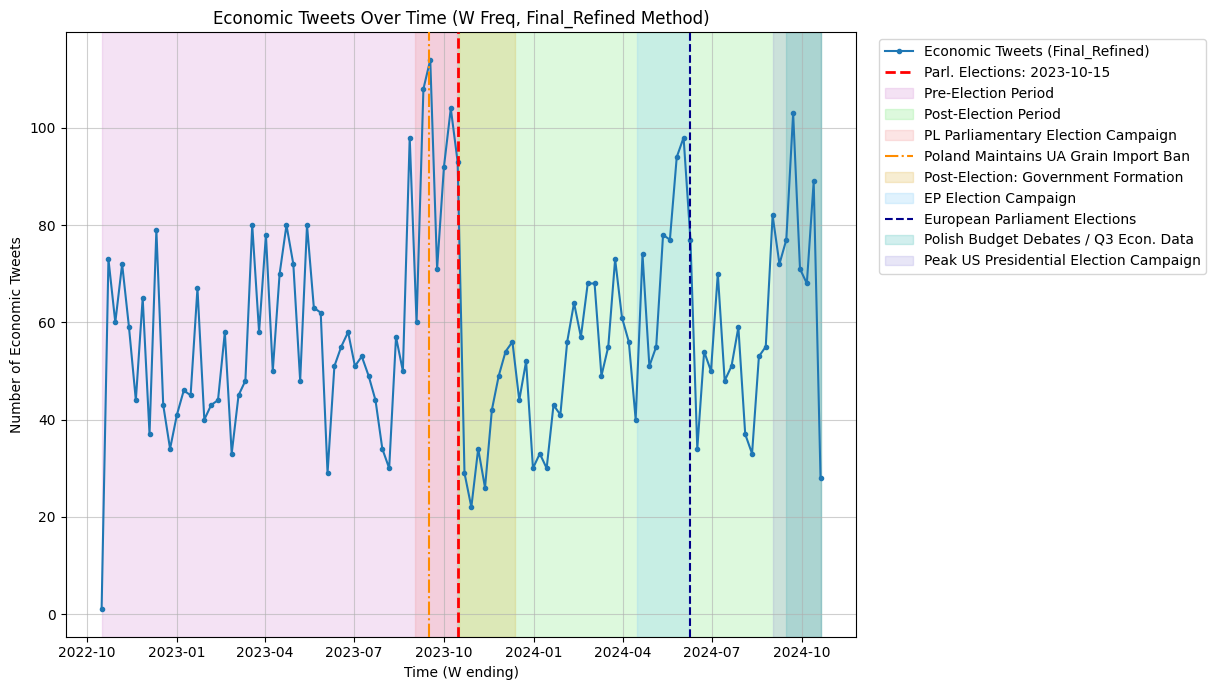


--- Time Series Analysis Section Complete ---
--------------------------------------------------


In [65]:
# ==============================================================================
# SECTION 10.B: TIME SERIES ANALYSIS & VISUALIZATION CALLING BLOCK
# ==============================================================================
# To generate different plots:
# 1. Copy part of block starting from words"- HERE" into a new cell.
# 2. Change the parameters in the function - example shown later.

print("\n" + "="*60)
print("--- 10.B: Generating Time Series Plots ---")
print("="*60)

# --- Configuration for THIS specific plot run ---
# VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
# VVVVVVVVVVVVVVVV CHANGE THESE PARAMETERS FOR DIFFERENT PLOTS VVVVVVVVVVVVVVVVV
# VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV

method_to_analyze = 'Final_Refined' # Options: 'Union', 'Gateway', 'Final_Refined'
time_series_freq = 'W'             # Options: 'W' (Weekly), 'M' (Monthly), 'D' (Daily)
date_col_ts = 'created_at'          # !!! Actual date column name !!!

# --- Define CUSTOM Annotations (these are optional, controlled by show_other_custom_annotations) ---
annotations_list = [
    {'start_date': '2023-09-01', 'end_date': '2023-10-14', 'label': 'PL Parliamentary Election Campaign', 'color': 'lightcoral', 'alpha': 0.2, 'add_lines': False},
    {'date': '2023-09-16', 'label': 'Poland Maintains UA Grain Import Ban', 'color': '#FF8C00', 'linestyle': '-.', 'linewidth': 1.5 },
    {'start_date': '2023-10-16', 'end_date': '2023-12-13', 'label': 'Post-Election: Government Formation', 'color': '#DAA520', 'alpha': 0.2, 'add_lines': False },
    {'start_date': '2024-04-15', 'end_date': '2024-06-08', 'label': 'EP Election Campaign', 'color': 'lightskyblue', 'alpha': 0.25, 'add_lines': False },
    {'date': '2024-06-09', 'label': 'European Parliament Elections', 'color': 'darkblue', 'linestyle': '--', 'linewidth': 1.5 },
    {'start_date': '2024-09-15', 'end_date': '2024-10-31', 'label': 'Polish Budget Debates / Q3 Econ. Data', 'color': 'lightseagreen', 'alpha': 0.2, 'add_lines': False },
    {'start_date': '2024-09-01', 'end_date': '2024-11-04', 'label': 'Peak US Presidential Election Campaign', 'color': 'slateblue', 'alpha': 0.15, 'add_lines': False},
    # Add more or remove as needed
]

# --- Toggles for standard and custom annotations ---
main_election_date_str = '2023-10-15' # Main Polish election line, set to None to hide
show_pre_post_main_election_shading = True # Toggle for light purple/green shading around main_election_date_str
show_other_custom_annotations = True       # Toggle for the annotations_list above

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^ END OF PARAMETERS TO CHANGE FOR DIFFERENT PLOTS ^^^^^^^^^^^^^^^
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

print("\nSelected plot configuration:")
print(f"  Method: {method_to_analyze}, Frequency: {time_series_freq}")
print(f"  Main Election line for: {main_election_date_str}, Pre/Post Shading: {show_pre_post_main_election_shading}")
print(f"  Show other custom annotations: {show_other_custom_annotations}")
if show_other_custom_annotations and annotations_list: print(f"  Number of custom annotations: {len(annotations_list)}")
else: print(f"  Custom annotations_list is empty or toggled off.")
print("-" * 50)

# --- Determine columns based on chosen method ---
flag_col = None; token_col_ts = None
if method_to_analyze == 'Union': flag_col = 'union_flag'; token_col_ts = 'union_tokens'
elif method_to_analyze == 'Gateway': flag_col = 'gateway_flag'; token_col_ts = 'gateway_tokens'
elif method_to_analyze == 'Final_Refined': flag_col = 'has_econ_term_FILTERED'; token_col_ts = 'matched_keywords_FILTERED'
else: print(f"ERROR: Unknown method '{method_to_analyze}'.")

# --- Generate Annotated Plot for Tweet Counts - HERE ---
if 'plot_annotated_timeseries' in locals() and flag_col and flag_col in df_clean_translated.columns:
    if date_col_ts not in df_clean_translated.columns: print(f"ERROR: Date column '{date_col_ts}' not found.")
    else:
         plot_annotated_timeseries(
             df=df_clean_translated, flag_col=flag_col, method_name=method_to_analyze,
             annotations=annotations_list, show_custom_annotations=show_other_custom_annotations,
             election_date_str=main_election_date_str, show_election_shading=show_pre_post_main_election_shading,
             freq=time_series_freq, date_col=date_col_ts)
elif not ('plot_annotated_timeseries' in locals()): print("ERROR: 'plot_annotated_timeseries' function not defined.")
else: print(f"Skipping annotated plot: Flag column '{flag_col}' missing or method invalid.")

# --- Optional: Generate Top Token Plot ---
# print("\n--- Optional: Plotting Top Token Trends ---")
# if 'plot_top_token_timeseries' in locals() and token_col_ts and token_col_ts in df_clean_translated.columns:
#     if date_col_ts not in df_clean_translated.columns: print(f"ERROR: Date column '{date_col_ts}' not found.")
#     else:
#          plot_top_token_timeseries(
#               df=df_clean_translated, token_col=token_col_ts, method_name=method_to_analyze,
#               top_n=10, freq=time_series_freq, date_col=date_col_ts,
#               annotations=annotations_list, show_custom_annotations=show_other_custom_annotations,
#               election_date_str=main_election_date_str, show_election_shading=show_pre_post_main_election_shading)
# # ... (error messages for missing function or columns)

print("\n--- Time Series Analysis Section Complete ---")
print("-" * 50)


Generating top 10 token time series plot for: Final_Refined Method
Custom annotations: SHOWN.
Election shading: SHOWN.
Top 10 tokens for Final_Refined: ['fund', 'energy', 'budget', 'investment', 'taxes', 'development', 'market', 'entrepreneurs', 'economy', 'finance']
Processing custom annotations for top token plot...


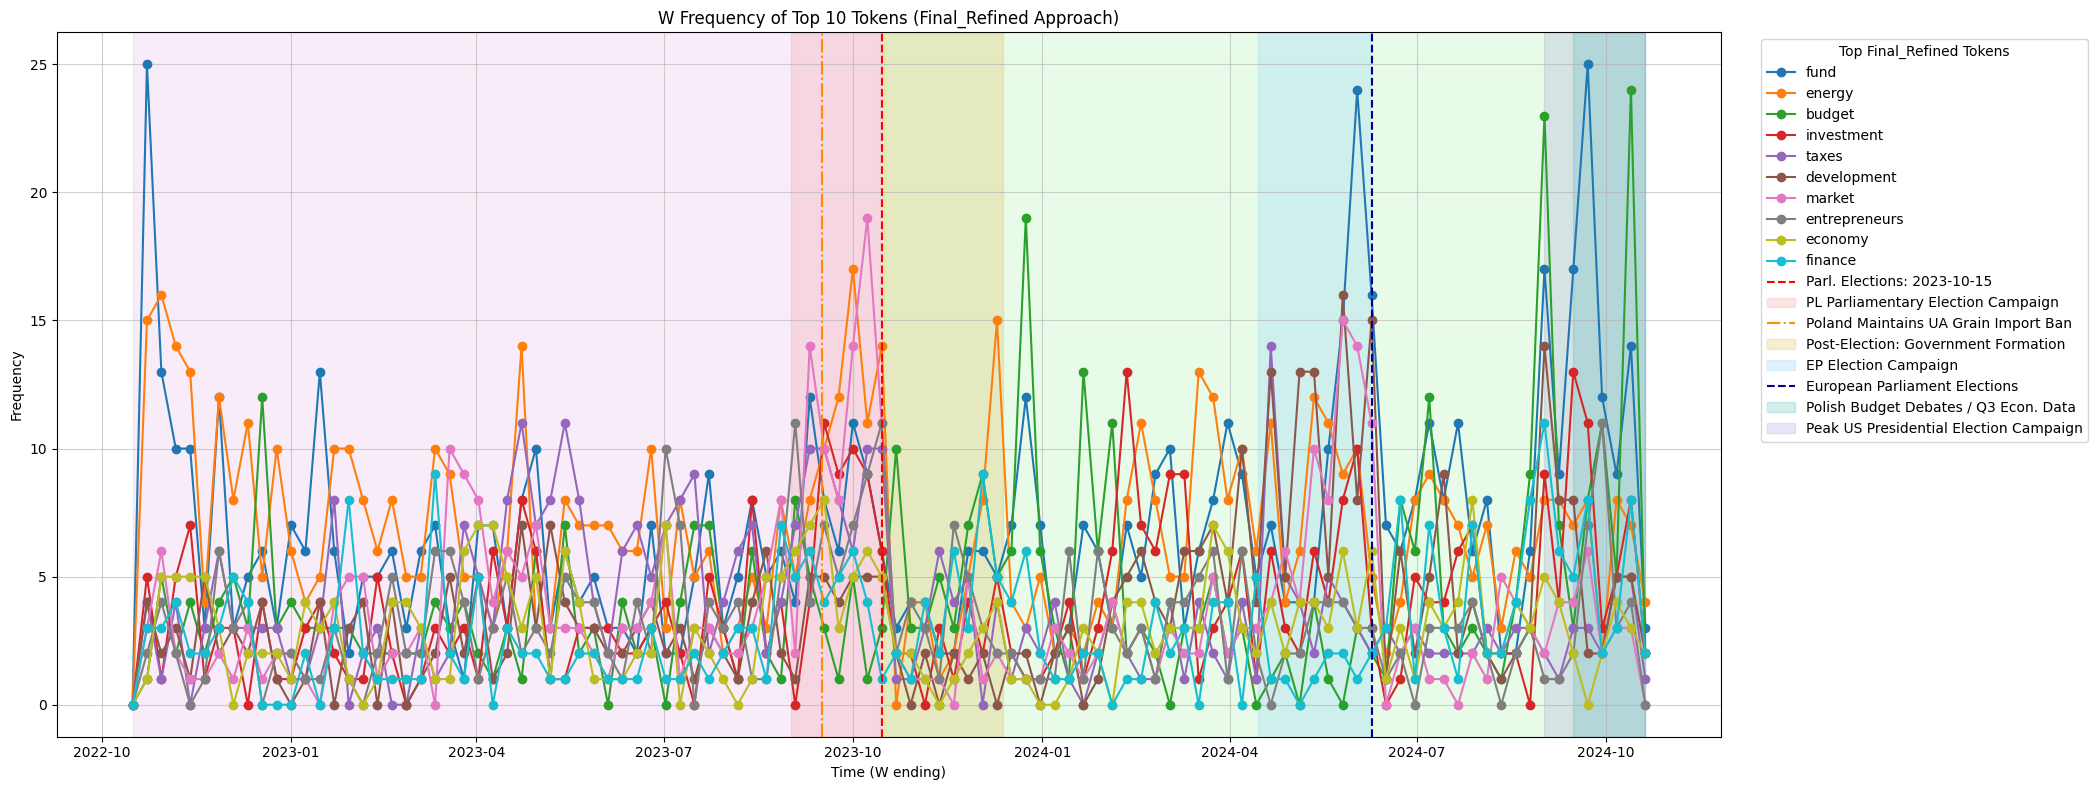

In [66]:
# --- Optional: Generate Top Token Plot ---
# print("\n--- Optional: Plotting Top Token Trends ---")
if 'plot_top_token_timeseries' in locals() and token_col_ts and token_col_ts in df_clean_translated.columns:
    if date_col_ts not in df_clean_translated.columns: print(f"ERROR: Date column '{date_col_ts}' not found.")
    else:
         plot_top_token_timeseries(
            df=df_clean_translated, 
            token_col=token_col_ts, 
            method_name=method_to_analyze,
            top_n=10, freq=time_series_freq, 
            date_col=date_col_ts,
            annotations=annotations_list, 
            show_custom_annotations=show_other_custom_annotations,
            election_date_str=main_election_date_str, 
            show_election_shading=show_pre_post_main_election_shading,
            figsize=(24, 8))


Generating annotated COUNT time series for: Final_Refined Method
Custom annotations: SHOWN.
Election shading: SHOWN.
Processing custom annotations for count plot...


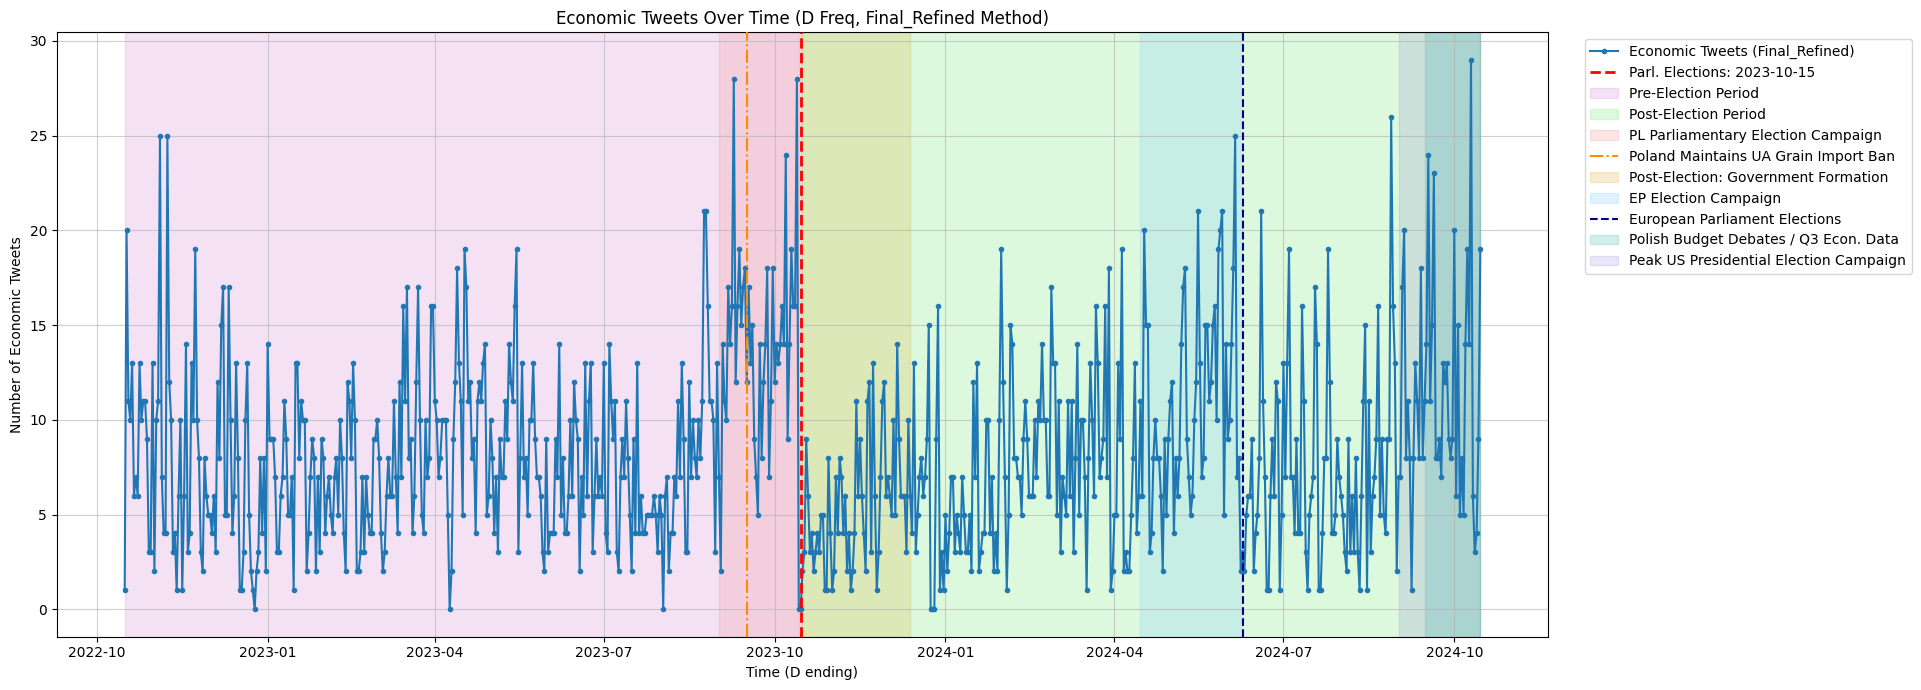

In [67]:
# --- Generate Annotated Plot for Tweet Counts ---
if 'plot_annotated_timeseries' in locals() and flag_col and flag_col in df_clean_translated.columns:
    if date_col_ts not in df_clean_translated.columns: print(f"ERROR: Date column '{date_col_ts}' not found.")
    else:
         plot_annotated_timeseries(
             df=df_clean_translated, 
             flag_col=flag_col, 
             method_name=method_to_analyze,
             annotations=annotations_list, 
             show_custom_annotations=show_other_custom_annotations,
             election_date_str=main_election_date_str, 
             show_election_shading=show_pre_post_main_election_shading,
             freq="D", 
             date_col=date_col_ts,
             figsize=(22, 7) # Optional: Adjust size for daily frequency
             )
elif not ('plot_annotated_timeseries' in locals()): print("ERROR: 'plot_annotated_timeseries' function not defined.")
else: print(f"Skipping annotated plot: Flag column '{flag_col}' missing or method invalid.")



Generating annotated COUNT time series for: Final_Refined Method
Custom annotations: HIDDEN or not provided.
Election shading: HIDDEN or election date not provided.


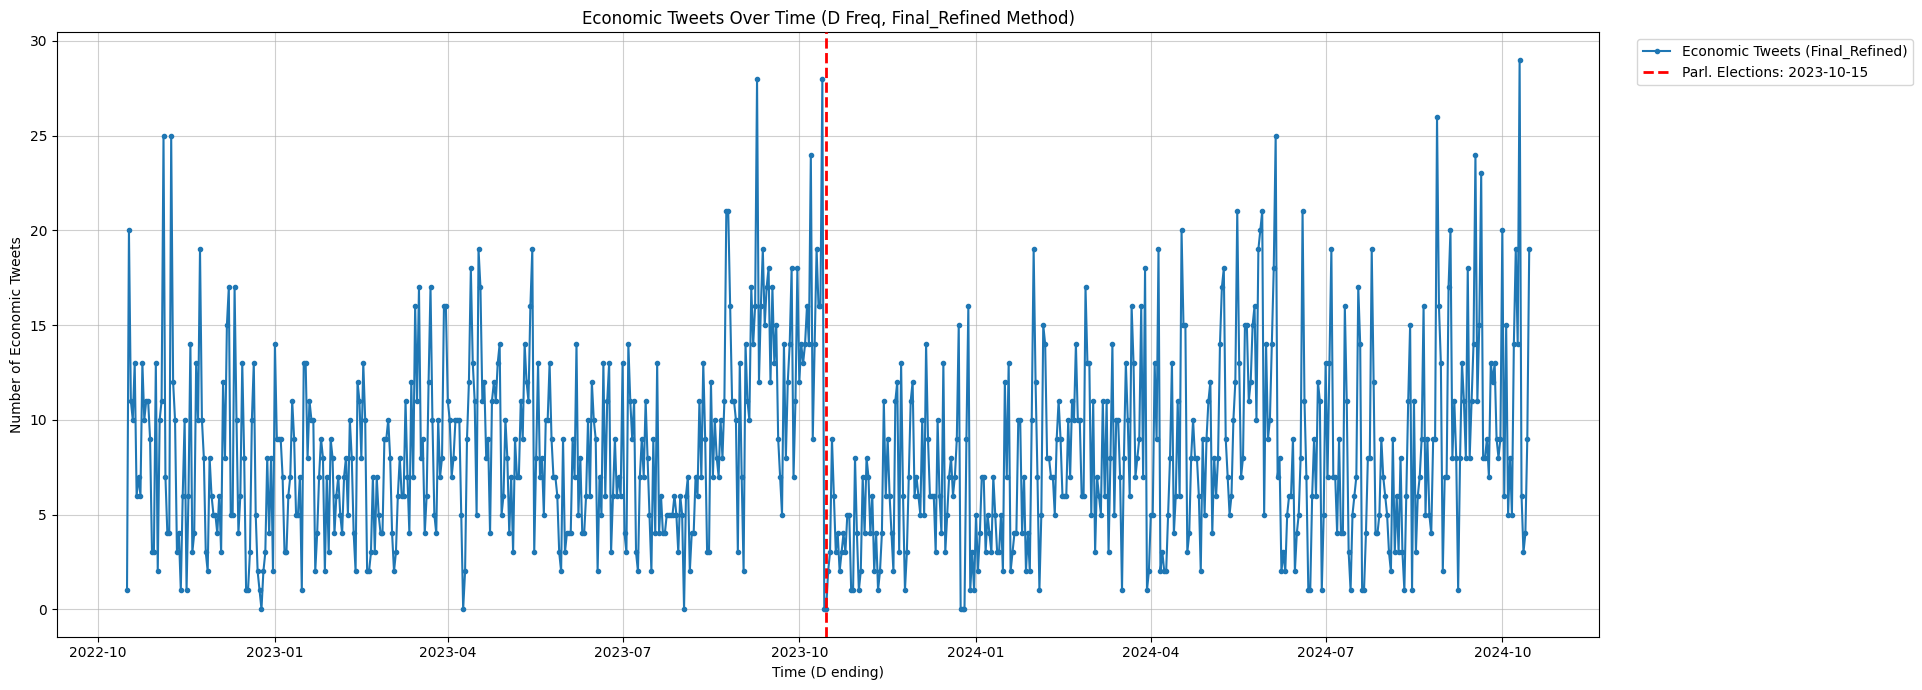

In [68]:
# --- Generate Annotated Plot for Tweet Counts ---
if 'plot_annotated_timeseries' in locals() and flag_col and flag_col in df_clean_translated.columns:
    if date_col_ts not in df_clean_translated.columns: print(f"ERROR: Date column '{date_col_ts}' not found.")
    else:
         plot_annotated_timeseries(
             df=df_clean_translated, 
             flag_col=flag_col, 
             method_name=method_to_analyze,
             annotations=annotations_list, 
             show_custom_annotations= False,
             election_date_str=main_election_date_str, 
             show_election_shading= False,
             freq="D", 
             date_col=date_col_ts,
             figsize=(22, 7) # Optional: Adjust size for daily frequency
             )
elif not ('plot_annotated_timeseries' in locals()): print("ERROR: 'plot_annotated_timeseries' function not defined.")
else: print(f"Skipping annotated plot: Flag column '{flag_col}' missing or method invalid.")



--- 10.C: Time Series Peak Analysis ---
Analyzing peaks for method: 'Final_Refined' using flag 'has_econ_term_FILTERED'
Applying a 12-period (W) rolling average...

Peak analysis (smoothed data): Max smoothed val: 75.92
  Periods with smoothed values >= 68.33 (90% of max):


created_at
2023-09-03    71.833333
2023-09-10    75.916667
2023-09-17    75.500000
2023-09-24    74.833333
2023-10-01    72.916667
2023-10-08    70.916667
2024-05-05    69.500000
2024-09-29    69.800000
2024-10-06    71.666667
2024-10-13    73.750000
2024-10-20    72.571429
Name: has_econ_term_FILTERED, dtype: float64

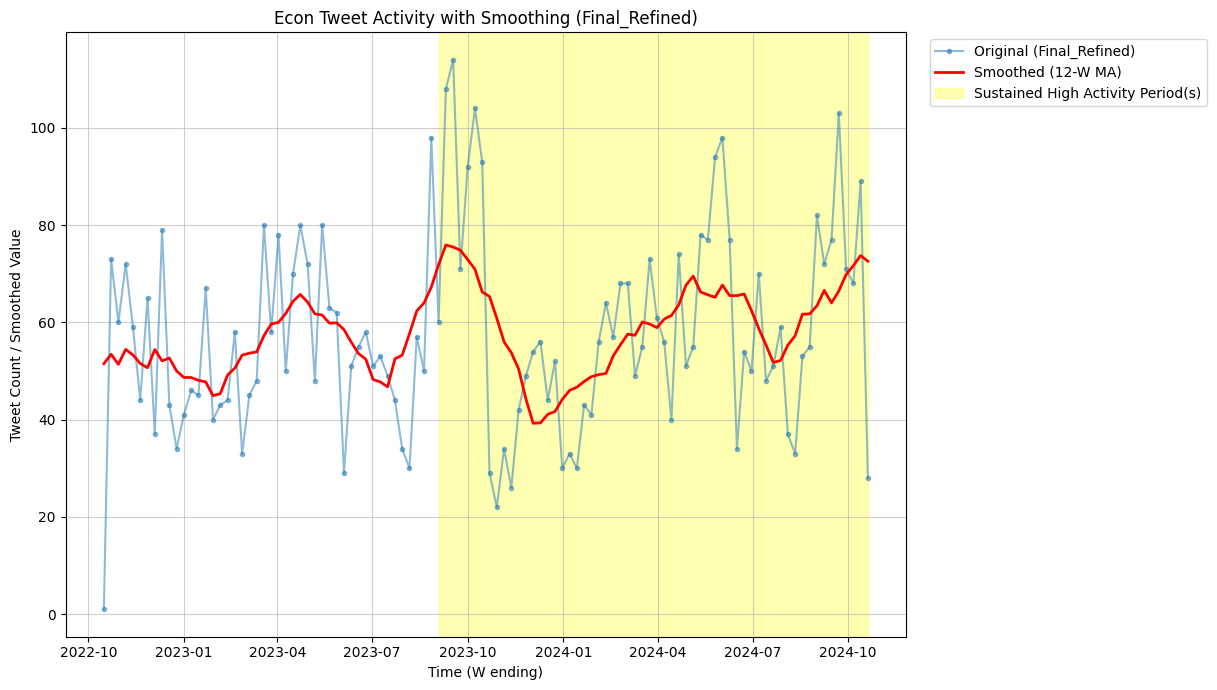


--- Time Series Peak Analysis Complete ---
--------------------------------------------------


In [69]:
# ==============================================================================
# SECTION 10.C: TIME SERIES PEAK ANALYSIS
# ==============================================================================

print("\n" + "="*60)
print("--- 10.C: Time Series Peak Analysis ---")
print("="*60)

run_peak_analysis = False
if 'df_clean_translated' not in globals() or df_clean_translated.empty:
    print("ERROR: 'df_clean_translated' DataFrame not found. Skipping peak analysis.")
elif flag_col is None or flag_col not in df_clean_translated.columns:
    print(f"ERROR: Flag column for method '{method_to_analyze}' ('{flag_col}') not defined or not found. Skipping peak analysis.")
elif date_col_ts not in df_clean_translated.columns:
    print(f"ERROR: Date column '{date_col_ts}' not found. Skipping peak analysis.")
else:
    print(f"Analyzing peaks for method: '{method_to_analyze}' using flag '{flag_col}'")
    df_peak_analysis = df_clean_translated.copy()
    try:
        df_peak_analysis[date_col_ts] = pd.to_datetime(df_peak_analysis[date_col_ts], errors='coerce')
        df_peak_analysis.dropna(subset=[date_col_ts], inplace=True)
        if not df_peak_analysis.empty:
            df_peak_analysis = df_peak_analysis.set_index(date_col_ts).sort_index() # Set index, no drop=False
            if df_peak_analysis.index.tz is not None:
                df_peak_analysis.index = df_peak_analysis.index.tz_convert('UTC').tz_localize(None)
            ts_counts_for_peaks = df_peak_analysis[flag_col].resample(time_series_freq).sum()
            if not ts_counts_for_peaks.empty: run_peak_analysis = True
            else: print("No data after resampling for peak analysis.")
        else: print("No valid date data for peak analysis.")
    except Exception as e: print(f"Error preparing data for peak analysis: {e}")

if run_peak_analysis:
    # --- Smoothing and Peak Detection ---
    if time_series_freq == 'W': smoothing_window = 12
    elif time_series_freq == 'M': smoothing_window = 3
    elif time_series_freq == 'D': smoothing_window = 90
    else: smoothing_window = 12; print(f"Warning: Using default smoothing window for freq '{time_series_freq}'")
    print(f"Applying a {smoothing_window}-period ({time_series_freq}) rolling average...")
    ts_smoothed = ts_counts_for_peaks.rolling(window=smoothing_window, center=True, min_periods=smoothing_window//2).mean().dropna()
    if ts_smoothed.empty: print("Smoothed time series empty.")
    else:
        max_smoothed_value = ts_smoothed.max(); peak_threshold = max_smoothed_value * 0.90
        peak_periods_smoothed = ts_smoothed[ts_smoothed >= peak_threshold]
        print(f"\nPeak analysis (smoothed data): Max smoothed val: {max_smoothed_value:.2f}")
        print(f"  Periods with smoothed values >= {peak_threshold:.2f} (90% of max):")
        if not peak_periods_smoothed.empty:
            try: display(peak_periods_smoothed)
            except NameError: print(peak_periods_smoothed.to_string())
            # --- Visualization of Smoothed Data and Peaks ---
            fig, ax = plt.subplots(figsize=(14, 7))
            ax.plot(ts_counts_for_peaks.index, ts_counts_for_peaks.values, marker='.', linestyle='-', label=f'Original ({method_to_analyze})', alpha=0.5, zorder=5)
            ax.plot(ts_smoothed.index, ts_smoothed.values, linestyle='-', label=f'Smoothed ({smoothing_window}-{time_series_freq} MA)', color='red', lw=2, zorder=10)
            if not peak_periods_smoothed.empty:
                peak_start = peak_periods_smoothed.index.min(); peak_end = peak_periods_smoothed.index.max()
                ax.axvspan(peak_start, peak_end, color='yellow', alpha=0.3, label='Sustained High Activity Period(s)', zorder=1)
            ax.set_title(f'Econ Tweet Activity with Smoothing ({method_to_analyze})'); ax.set_xlabel(f'Time ({time_series_freq} ending)'); ax.set_ylabel('Tweet Count / Smoothed Value')
            ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1)); ax.grid(True, alpha=0.6); plt.tight_layout(rect=[0, 0, 0.88, 1]); plt.show()
        else: print("  No significant peak periods identified in smoothed data.")
else: print("Skipping peak analysis due to earlier errors or no data.")
print("\n--- Time Series Peak Analysis Complete ---")
print("-" * 50)

## SENTIMENT OF ECONOMIC TWEETS USING BERT 

In [73]:
# Option 1: Asks for confirmation (Safer)
# %reset

# Option 2: Forces deletion without confirmation (Use with care!)
%reset -f

# After resetting, it's good practice to run garbage collection
import gc
gc.collect()

print("Namespace reset and garbage collection attempted.")

Namespace reset and garbage collection attempted.


In [76]:
import pandas as pd
import numpy as np
import gc # For garbage collection
import os # For file path operations

# ==============================================================================
# SECTION 11: LOAD OR CREATE/RECREATE df_sentiment_input (with Toggle)
# ==============================================================================
# This section ensures `df_sentiment_input` is available.
# A toggle `force_recreate_sentiment_input_from_full` controls the behavior:
# - If False: Tries to load `df_sentiment_input.parquet`. If fails, proceeds to create it.
# - If True:  Skips loading `df_sentiment_input.parquet` and recreates it from
#             `df_clean_translated` (which is loaded/normalized/checkpointed).

print("\n" + "="*60)
print("--- Section 11: Load or Create/Recreate df_sentiment_input ---")
print("="*60)

# --- Configuration ---
# !!! --- USER TOGGLE --- !!!
# Set to True to force reprocessing of df_clean_translated and recreation of df_sentiment_input
# Set to False to try loading df_sentiment_input.parquet first.
force_recreate_sentiment_input_from_full = False # <<<--- EDIT THIS TOGGLE AS NEEDED

output_dir = 'data/05_final'
full_df_checkpoint_filename = 'df_processed_full_FINAL.parquet'
sentiment_input_filename = 'df_sentiment_input.parquet'

full_output_path = os.path.join(output_dir, full_df_checkpoint_filename)
sentiment_output_path = os.path.join(output_dir, sentiment_input_filename)

df_sentiment_input = None # Initialize

os.makedirs(output_dir, exist_ok=True)
print(f"Output directory for saved files: '{output_dir}'")
print(f"Force recreation of sentiment input from full data: {force_recreate_sentiment_input_from_full}")

# --- Helper function for list normalization (defined once) ---
def normalize_list_column(series_to_normalize):
    """ Ensures each element is a Python list of strings, handles np.ndarray and NaN. """
    def convert_element(x):
        if isinstance(x, np.ndarray): return [str(item) for item in x.tolist()]
        elif isinstance(x, list): return [str(item) for item in x]
        return []
    if not series_to_normalize.empty and series_to_normalize.dropna().empty and not all(isinstance(el, list) for el in series_to_normalize.dropna()):
        return series_to_normalize
    return series_to_normalize.apply(convert_element)

list_cols_for_sentiment_input_normalization = ['matched_keywords_FILTERED', 'extracted_terms_FILTERED']
token_cols_to_normalize_main_df = [
    'matched_exact_econ_words_naive', 'matched_exact_econ_words_regex',
    'matched_exact_econ_words_flashtext', 'matched_exact_econ_words_ac',
    'matched_keywords_ORIG', 'extracted_terms_FILTERED',
    'matched_keywords_FILTERED', 'union_tokens', 'gateway_tokens']

# --- Main Logic ---
if not force_recreate_sentiment_input_from_full and os.path.exists(sentiment_output_path):
    print(f"\n--- 11.A: Attempting to Load Pre-existing 'df_sentiment_input' ---")
    print(f"Found existing '{sentiment_output_path}'.")
    try:
        df_sentiment_input = pd.read_parquet(sentiment_output_path)
        print(f"Successfully loaded 'df_sentiment_input' with shape: {df_sentiment_input.shape}")
        print("\nRe-normalizing list column formats in loaded df_sentiment_input...")
        for col in list_cols_for_sentiment_input_normalization:
            if col in df_sentiment_input.columns:
                print(f"  - Normalizing column: {col}")
                df_sentiment_input[col] = normalize_list_column(df_sentiment_input[col])
        print("List re-normalization complete for loaded df_sentiment_input.")
    except Exception as e:
        print(f"ERROR loading '{sentiment_output_path}': {e}. Will proceed to recreate it.")
        df_sentiment_input = pd.DataFrame() # Ensure it's empty to trigger recreation
else:
    if force_recreate_sentiment_input_from_full:
        print("\nINFO: `force_recreate_sentiment_input_from_full` is True. Will recreate `df_sentiment_input`.")
    else: # File didn't exist
        print(f"INFO: File '{sentiment_output_path}' not found. Will create 'df_sentiment_input'.")
    df_sentiment_input = pd.DataFrame() # Ensure it's marked as empty to trigger creation path

# If df_sentiment_input is still empty (either forced, or load failed, or file not found)
if df_sentiment_input.empty:
    print("\n--- 11.B: Creating/Recreating 'df_sentiment_input' from Source ---")
    df_source_for_sentiment = None
    df_clean_translated_was_loaded_this_run = False

    # Step 1: Ensure df_clean_translated is loaded and normalized
    if 'df_clean_translated' in locals() and isinstance(df_clean_translated, pd.DataFrame) and not df_clean_translated.empty:
        print("Using 'df_clean_translated' from current memory as source.")
        df_source_for_sentiment = df_clean_translated # Use direct reference if already good
        # Assume if it's in memory and we are here, it might need normalization if this is the first time through this path
        print("\nNormalizing token columns in in-memory df_clean_translated...")
        for col in token_cols_to_normalize_main_df:
            if col in df_source_for_sentiment.columns:
                df_source_for_sentiment[col] = normalize_list_column(df_source_for_sentiment[col])
        print("Normalization of in-memory df_clean_translated for checkpointing complete.")
    elif os.path.exists(full_output_path):
        print(f"Loading full processed DataFrame from checkpoint: {full_output_path}")
        try:
            df_source_for_sentiment = pd.read_parquet(full_output_path)
            print(f"Successfully loaded '{full_output_path}' with shape: {df_source_for_sentiment.shape}")
            df_clean_translated_was_loaded_this_run = True # Flag it
            print("\nNormalizing token columns in loaded full DataFrame...")
            for col in token_cols_to_normalize_main_df:
                if col in df_source_for_sentiment.columns:
                     df_source_for_sentiment[col] = normalize_list_column(df_source_for_sentiment[col])
            print("Normalization of loaded full DataFrame complete.")
        except Exception as e: print(f"ERROR loading '{full_output_path}': {e}")
    else:
        print(f"ERROR: 'df_clean_translated' not in memory AND Full checkpoint '{full_output_path}' not found. Cannot create 'df_sentiment_input'.")

    # Step 2: If we have a source, save/update its checkpoint, then create df_sentiment_input
    if df_source_for_sentiment is not None and not df_source_for_sentiment.empty:
        print(f"\nSaving/Updating full normalized checkpoint: {full_output_path}")
        try:
            df_to_save_full = df_source_for_sentiment.copy() # Save the source we are using
            if df_to_save_full.index.name is not None or isinstance(df_to_save_full.index, pd.DatetimeIndex):
                 df_to_save_full.reset_index(drop=False, inplace=True)
            df_to_save_full.to_parquet(full_output_path, index=False)
            print("Save/Update of full DataFrame checkpoint successful.")
            del df_to_save_full
        except Exception as e: print(f"ERROR saving full DataFrame checkpoint: {e}")
        gc.collect()

        # Create df_sentiment_input from df_source_for_sentiment
        print("\nCreating 'df_sentiment_input' by filtering and selecting columns...")
        final_flag_col = 'has_econ_term_FILTERED'
        tweet_id_col_sentiment = 'id'
        text_col_sentiment = 'text_clean_en_demojized'
        essential_columns = [tweet_id_col_sentiment, text_col_sentiment]
        optional_columns_for_sentiment = [
             'created_at', 'party', 'username',
             'matched_keywords_FILTERED', 'extracted_terms_FILTERED']
        required_cols_check = [final_flag_col] + essential_columns
        missing_cols_check = [col for col in required_cols_check if col not in df_source_for_sentiment.columns]

        if missing_cols_check:
            print(f"ERROR: Essential cols missing from source: {missing_cols_check}")
            df_sentiment_input = pd.DataFrame()
        else:
            df_sentiment_input = df_source_for_sentiment[df_source_for_sentiment[final_flag_col] == True].copy()
            print(f"Filtered to {len(df_sentiment_input)} tweets flagged by '{final_flag_col}'.")
            if not df_sentiment_input.empty:
                columns_to_keep = essential_columns[:]
                kept_optional_cols = []
                for col in optional_columns_for_sentiment:
                    if col in df_sentiment_input.columns:
                        if col not in columns_to_keep: columns_to_keep.append(col); kept_optional_cols.append(col)
                if kept_optional_cols: print(f"  + Including optional columns: {kept_optional_cols}")
                final_columns_present = [col for col in columns_to_keep if col in df_sentiment_input.columns]
                if len(final_columns_present) < len(essential_columns):
                     print("ERROR: Not all essential columns present."); df_sentiment_input = pd.DataFrame()
                else:
                     df_sentiment_input = df_sentiment_input[final_columns_present].copy()
                     print(f"\nSelected final columns: {final_columns_present}")
                     print("\nNormalizing list column formats in newly created df_sentiment_input...")
                     for col in list_cols_for_sentiment_input_normalization:
                         if col in df_sentiment_input.columns:
                             df_sentiment_input[col] = normalize_list_column(df_sentiment_input[col])
                     print("List normalization complete for df_sentiment_input.")
                     print(f"Shape of 'df_sentiment_input': {df_sentiment_input.shape}")
                     print("\nSample of newly created 'df_sentiment_input':")
                     try: display(df_sentiment_input.head())
                     except NameError: print(df_sentiment_input.head().to_string())
                     print(f"\nSaving newly created 'df_sentiment_input' to: {sentiment_output_path}")
                     if not df_sentiment_input.empty:
                         try: df_sentiment_input.to_parquet(sentiment_output_path, index=False); print("Save successful.")
                         except Exception as e: print(f"ERROR saving 'df_sentiment_input': {e}")
                     else: print("Skipping save: 'df_sentiment_input' is empty.")
            else: print("No tweets met criteria for 'df_sentiment_input'.")
    else:
        print("ERROR: No source data available to create 'df_sentiment_input'.")
        df_sentiment_input = pd.DataFrame() # Ensure it's empty

# Final status message
print("\n--- Section 11 Complete ---")
if 'df_sentiment_input' in locals() and not df_sentiment_input.empty:
    print(f"   'df_sentiment_input' is ready in memory with {len(df_sentiment_input)} rows.")
    print(f"   It has also been saved to/loaded from '{sentiment_output_path}'.")
else:
    print(f"   WARNING: 'df_sentiment_input' is empty or not properly created/loaded.")
    print(f"            Check for errors in previous steps or file paths.")
print("-" * 50)


--- Section 11: Load or Create/Recreate df_sentiment_input ---
Output directory for saved files: 'data/05_final'
Force recreation of sentiment input from full data: False

--- 11.A: Attempting to Load Pre-existing 'df_sentiment_input' ---
Found existing 'data/05_final\df_sentiment_input.parquet'.
Successfully loaded 'df_sentiment_input' with shape: (6089, 8)

Re-normalizing list column formats in loaded df_sentiment_input...
  - Normalizing column: matched_keywords_FILTERED
  - Normalizing column: extracted_terms_FILTERED
List re-normalization complete for loaded df_sentiment_input.

--- Section 11 Complete ---
   'df_sentiment_input' is ready in memory with 6089 rows.
   It has also been saved to/loaded from 'data/05_final\df_sentiment_input.parquet'.
--------------------------------------------------


In [77]:
df_sentiment_input

id                            text_clean_en_demojized  \
0     1846161400328028160   :cross_mark: We are a year after the election...   
1     1845725230272000256  Poland is soon to launch 49 EU-funded Foreigne...   
2     1844415548211245312  Listening to the statement of Deputy Minister ...   
3     1843984045073428992  Local government investments are crucial for r...   
4     1843740048350691584  We talked about the trends and challenges of t...   
...                   ...                                                ...   
6084  1622276457975222272  Dear Minister of Coal and Straw, if you had li...   
6085  1621767127660220416  In the majesty of the law and stealing from Po...   
6086  1618902451620573184  9th Beef Sector Forum - we met among producers...   
6087  1612071495026483200     The difference is that PKN Orlen has a 49.9...   
6088  1701960909369868544  This is one of the largest road investments  \...   

                    created_at         party         username  \
0    2024-10-15 12:09:12+00:00  Konfederacja   bartlomiejpejo   
1    2024-10-14 07:16:01+00:00  Konfederacja   bartlomiejpejo   
2    2024-10-10 16:31:48+00:00  Konfederacja   bartlomiejpejo   
3    2024-10-09 11:57:10+00:00  Konfederacja   bartlomiejpejo   
4    2024-10-08 19:47:37+00:00  Konfederacja   bartlomiejpejo   
...                        ...           ...              ...   
6084 2023-02-05 16:50:22+00:00           PSL  StefanKrajewski   
6085 2023-02-04 07:06:28+00:00           PSL  StefanKrajewski   
6086 2023-01-27 09:23:16+00:00           PSL  StefanKrajewski   
6087 2023-01-08 12:59:29+00:00           PSL  StefanKrajewski   
6088 2023-09-13 14:07:56+00:00           PSL      StruzikAdam   

            matched_keywords_FILTERED         extracted_terms_FILTERED  \
0                    [crisis, demand]                [crisis, demands]   
1                              [fund]                         [funded]   
2                              [fund]                          [funds]   
3                        [investment]                    [investments]   
4                            [market]                         [market]   
...                               ...                              ...   
6084                 [market, import]               [imported, market]   
6085  [energy, state-owned companies]  [energy, state-owned companies]   
6086                         [sector]                         [Sector]   
6087                       [treasury]                       [Treasury]   
6088                     [investment]                    [investments]   

                                          text_clean_en  
0      ❌ We are a year after the elections, and Pola...  
1     Poland is soon to launch 49 EU-funded Foreigne...  
2     Listening to the statement of Deputy Minister ...  
3     Local government investments are crucial for r...  
4     We talked about the trends and challenges of t...  
...                                                 ...  
6084  Dear Minister of Coal and Straw, if you had li...  
6085  In the majesty of the law and stealing from Po...  
6086  9th Beef Sector Forum - we met among producers...  
6087     The difference is that PKN Orlen has a 49.9...  
6088  This is one of the largest road investments   ...  

[6089 rows x 8 columns]

In [78]:
df_sentiment_input.columns

Index(['id', 'text_clean_en_demojized', 'created_at', 'party', 'username',
       'matched_keywords_FILTERED', 'extracted_terms_FILTERED',
       'text_clean_en'],
      dtype='object')

In [79]:
#!pip install transformers torch pandas pyarrow

In [80]:
df_sentiment_input

id                            text_clean_en_demojized  \
0     1846161400328028160   :cross_mark: We are a year after the election...   
1     1845725230272000256  Poland is soon to launch 49 EU-funded Foreigne...   
2     1844415548211245312  Listening to the statement of Deputy Minister ...   
3     1843984045073428992  Local government investments are crucial for r...   
4     1843740048350691584  We talked about the trends and challenges of t...   
...                   ...                                                ...   
6084  1622276457975222272  Dear Minister of Coal and Straw, if you had li...   
6085  1621767127660220416  In the majesty of the law and stealing from Po...   
6086  1618902451620573184  9th Beef Sector Forum - we met among producers...   
6087  1612071495026483200     The difference is that PKN Orlen has a 49.9...   
6088  1701960909369868544  This is one of the largest road investments  \...   

                    created_at         party         username  \
0    2024-10-15 12:09:12+00:00  Konfederacja   bartlomiejpejo   
1    2024-10-14 07:16:01+00:00  Konfederacja   bartlomiejpejo   
2    2024-10-10 16:31:48+00:00  Konfederacja   bartlomiejpejo   
3    2024-10-09 11:57:10+00:00  Konfederacja   bartlomiejpejo   
4    2024-10-08 19:47:37+00:00  Konfederacja   bartlomiejpejo   
...                        ...           ...              ...   
6084 2023-02-05 16:50:22+00:00           PSL  StefanKrajewski   
6085 2023-02-04 07:06:28+00:00           PSL  StefanKrajewski   
6086 2023-01-27 09:23:16+00:00           PSL  StefanKrajewski   
6087 2023-01-08 12:59:29+00:00           PSL  StefanKrajewski   
6088 2023-09-13 14:07:56+00:00           PSL      StruzikAdam   

            matched_keywords_FILTERED         extracted_terms_FILTERED  \
0                    [crisis, demand]                [crisis, demands]   
1                              [fund]                         [funded]   
2                              [fund]                          [funds]   
3                        [investment]                    [investments]   
4                            [market]                         [market]   
...                               ...                              ...   
6084                 [market, import]               [imported, market]   
6085  [energy, state-owned companies]  [energy, state-owned companies]   
6086                         [sector]                         [Sector]   
6087                       [treasury]                       [Treasury]   
6088                     [investment]                    [investments]   

                                          text_clean_en  
0      ❌ We are a year after the elections, and Pola...  
1     Poland is soon to launch 49 EU-funded Foreigne...  
2     Listening to the statement of Deputy Minister ...  
3     Local government investments are crucial for r...  
4     We talked about the trends and challenges of t...  
...                                                 ...  
6084  Dear Minister of Coal and Straw, if you had li...  
6085  In the majesty of the law and stealing from Po...  
6086  9th Beef Sector Forum - we met among producers...  
6087     The difference is that PKN Orlen has a 49.9...  
6088  This is one of the largest road investments   ...  

[6089 rows x 8 columns]

In [81]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.7.0+cu126
CUDA available: True
CUDA version: 12.6
Number of GPUs: 1
Current GPU name: NVIDIA GeForce RTX 2060


In [83]:
#pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

In [ ]:
# ==============================================================================
# SECTION 12: SENTIMENT ANALYSIS - SETUP, APPLICATION & VISUALIZATION
# ==============================================================================
# This section sets up the sentiment analysis model, applies it to the
# filtered economic tweets, and visualizes the results.

print("\n" + "="*60)
print("--- Section 12: Sentiment Analysis: Setup, Application & Visualization ---")
print("="*60)

# --- Imports for this section ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.auto import tqdm # For progress bar
import gc # For garbage collection
import os # For file path operations
# Import transformers libraries
try:
    from transformers import pipeline
    import torch
    transformers_available = True
except ImportError:
    print("ERROR: 'transformers' or 'torch' library not found.")
    print("Please install them: pip install transformers torch")
    print("Sentiment analysis section will be skipped.")
    transformers_available = False

# --- Check for prerequisite DataFrame ---
run_sentiment_analysis_section = False # Flag to control execution
if 'df_sentiment_input' not in locals() or df_sentiment_input.empty:
    print("\nERROR: 'df_sentiment_input' DataFrame not found or is empty.")
    print("       Ensure Section 11 (PREPARE DATA FOR SENTIMENT ANALYSIS) was run successfully.")
elif not transformers_available:
    print("\nSkipping Sentiment Analysis: Required libraries missing.")
else:
    print(f"\nFound 'df_sentiment_input' with {len(df_sentiment_input)} tweets to analyze.")
    run_sentiment_analysis_section = True

# Initialize pipeline variable
sentiment_pipeline = None

# --- 12.A: Setup Sentiment Analysis Pipeline ---
if run_sentiment_analysis_section:
    print("\n--- 12.A: Setting up Sentiment Analysis Environment ---")
    try:
        # Check for GPU availability
        if torch.cuda.is_available():
            try:
                device_num = 0; print(f"CUDA (GPU) available. Attempting to use device: {torch.cuda.get_device_name(device_num)}");
                _ = torch.tensor([1.0]).to(device_num); print(f"Successfully accessed GPU device {device_num}.")
            except Exception as gpu_error: print(f"WARNING: GPU init failed: {gpu_error}. Falling back to CPU."); device_num = -1
        else: device_num = -1; print("CUDA (GPU) not available. Using CPU (device=-1).")

        # --- Load Model ---
        model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest" # Using specified model
        print(f"\nLoading pipeline with model: '{model_name}'...")
        sentiment_pipeline = pipeline("sentiment-analysis", model=model_name, device=device_num)
        print("Sentiment analysis pipeline loaded successfully.")
        # Display label mapping
        print("\nModel Label Mapping (Expected):")
        try:
            id2label = sentiment_pipeline.model.config.id2label
            for label_id, label_name in id2label.items(): print(f" - ID {label_id}: {label_name}") # Should be Negative, Neutral, Positive
        except: print(" - Could not retrieve mapping. Expect 'Negative', 'Neutral', 'Positive'.")
    except Exception as e:
        print(f"An error occurred during pipeline setup: {e}")
        sentiment_pipeline = None # Ensure it's None on error
    print("-" * 50)
else:
     print("\nSkipping Sentiment Analysis Setup: Prerequisite libraries or data missing.")


# --- 12.B: Apply Sentiment Pipeline ---
if run_sentiment_analysis_section and sentiment_pipeline is not None:
    print("\n--- 12.B: Applying Sentiment Analysis ---")
    text_col_sentiment = 'text_clean_en' # Use demojized text # text_clean_en_demojized

    if text_col_sentiment not in df_sentiment_input.columns:
        print(f"ERROR: Text column '{text_col_sentiment}' not found in df_sentiment_input.")
        # Stop this section if text column missing
        run_sentiment_analysis_section = False
    else:
        texts_to_analyze = df_sentiment_input[text_col_sentiment].fillna('').tolist()
        print(f"Analyzing sentiment for {len(texts_to_analyze)} tweets using column '{text_col_sentiment}'...")
        results = []
        batch_size = 64 # Adjust based on memory/CPU/GPU speed

        for i in tqdm(range(0, len(texts_to_analyze), batch_size), desc="Analyzing Sentiment"):
             batch_texts = texts_to_analyze[i:i+batch_size]
             try:
                  batch_results = sentiment_pipeline(batch_texts, truncation=True, padding=True, max_length=512)
                  results.extend(batch_results)
             except Exception as e:
                  print(f"\nError processing batch starting at index {i}: {e}")
                  results.extend([{'label': 'ERROR', 'score': 0.0}] * len(batch_texts))

        print(f"\nPipeline processing finished. Received {len(results)} results.")
        if len(results) == len(df_sentiment_input):
            print("Adding sentiment results to the DataFrame...")
            try:
                # Ensure labels are capitalized consistently as per model output
                df_sentiment_input['sentiment_label'] = [
                    res['label'].capitalize() if isinstance(res.get('label'), str) and res.get('label').lower() in ['positive', 'negative', 'neutral']
                    else ('ERROR' if isinstance(res.get('label'), str) and res.get('label') == 'ERROR' else 'Other') # Handle ERROR or unexpected
                    for res in results
                ]
                df_sentiment_input['sentiment_score'] = [res.get('score', 0.0) for res in results]
                print("Sentiment labels and scores added successfully.")

                # --- Run Diagnostic Check Here ---
                print("\n--- DIAGNOSTIC: Checking df_sentiment_input after adding results ---")
                print("\nDataFrame Info:")
                df_sentiment_input.info(verbose=False, memory_usage='deep')
                sentiment_label_col_diag = 'sentiment_label'
                if sentiment_label_col_diag in df_sentiment_input.columns:
                    print(f"\nValue Counts for '{sentiment_label_col_diag}':")
                    print(df_sentiment_input[sentiment_label_col_diag].value_counts(dropna=False))
                    print("\nSample Data including Sentiment Results:")
                    cols_to_show_check = [text_col_sentiment, 'sentiment_label', 'sentiment_score']
                    if 'id' in df_sentiment_input.columns: cols_to_show_check.insert(0,'id')
                    try: display(df_sentiment_input[cols_to_show_check].head())
                    except NameError: print(df_sentiment_input[cols_to_show_check].head().to_string())
                else: print(f"ERROR DIAGNOSTIC: Column '{sentiment_label_col_diag}' NOT found after trying to add it!")
                # --- End Diagnostic Check ---

            except Exception as e:
                 print(f"ERROR assigning sentiment results to DataFrame columns: {e}")
                 run_sentiment_analysis_section = False # Prevent viz if assignment failed
        else:
            print(f"ERROR: Length mismatch! Results ({len(results)}) != Input ({len(df_sentiment_input)}). Cannot add columns.")
            run_sentiment_analysis_section = False # Prevent viz if results mismatch
    print("\n--- Sentiment Analysis Application Complete ---")
    print("-" * 50)
else:
     if run_sentiment_analysis_section and sentiment_pipeline is None:
         print("\nSkipping Sentiment Analysis Application: Pipeline not loaded correctly.")
     # run_sentiment_analysis_section being False handled by outer if


--- Section 12: Sentiment Analysis: Setup, Application & Visualization ---

Found 'df_sentiment_input' with 6089 tweets to analyze.

--- 12.A: Setting up Sentiment Analysis Environment ---
CUDA (GPU) available. Attempting to use device: NVIDIA GeForce RTX 2060
Successfully accessed GPU device 0.

Loading pipeline with model: 'cardiffnlp/twitter-roberta-base-sentiment-latest'...


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use 0


Sentiment analysis pipeline loaded successfully.

Model Label Mapping (Expected):
 - ID 0: negative
 - ID 1: neutral
 - ID 2: positive
--------------------------------------------------

--- 12.B: Applying Sentiment Analysis ---
Analyzing sentiment for 6089 tweets using column 'text_clean_en'...


Analyzing Sentiment:   0%|          | 0/191 [00:00<?, ?it/s]


--- 12.C: Visualizing Sentiment Analysis Results ---
Visualizing sentiment for 6089 tweets...

--- 12.C.1: Overall Sentiment Distribution ---


C:\Users\macie\AppData\Local\Temp\ipykernel_26644\3633891247.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.index, y=counts.values, palette=plot_palette, order=counts.index)


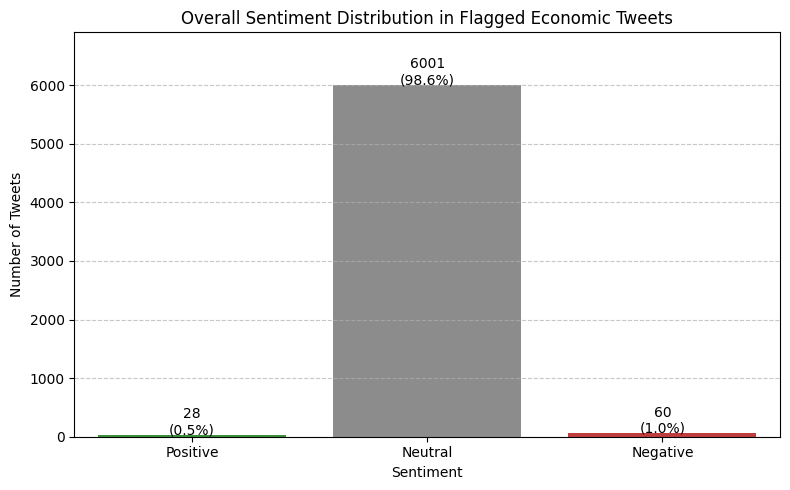

------------------------------

--- 12.C.2: Sentiment Distribution Over Time ---
Plotting sentiment trends (W frequency)...


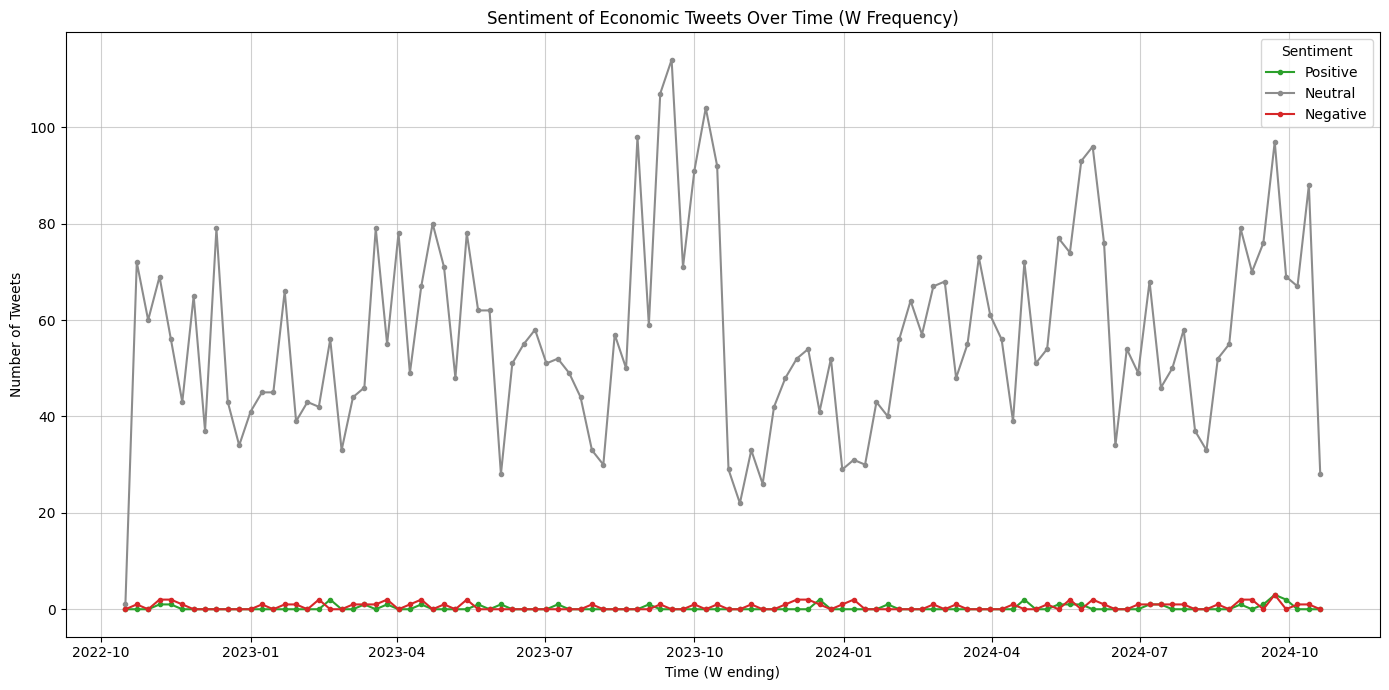

------------------------------

--- 12.C.3: Sentiment Distribution by Party ---
Skipping plot: 'party_colors' dict not defined (should be from Section 7).
------------------------------

--- 12.C.4: Sentiment Score Distribution ---


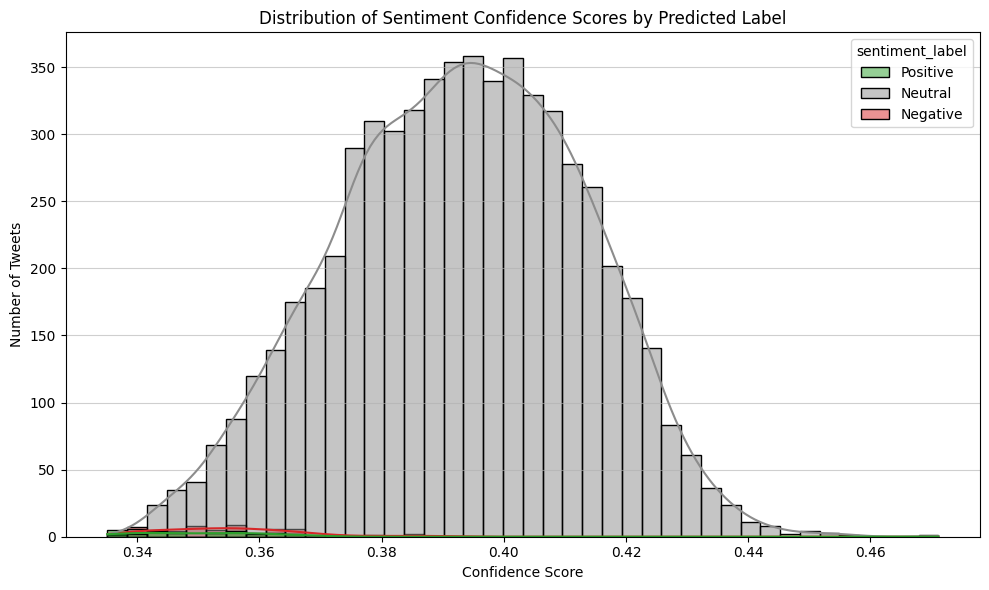

------------------------------

--- Section 12: Sentiment Analysis & Visualization Complete ---


In [87]:
# ==============================================================================
# SECTION 12.C: SENTIMENT ANALYSIS VISUALIZATION
# ==============================================================================
# This section visualizes the sentiment results added to df_sentiment_input

# Proceed only if setup and application were successful
if run_sentiment_analysis_section: # This flag is now the main controller
    print("\n--- 12.C: Visualizing Sentiment Analysis Results ---")

    # Config & Checks
    sentiment_label_col = 'sentiment_label'; sentiment_score_col = 'sentiment_score'
    date_col_viz = 'created_at'; party_col_viz = 'party' # Assumes these exist if kept in Sec 11
    # Ensure your sentiment_colors and sentiment_order match the (capitalized) output
    sentiment_colors = {'Positive': '#2ca02c', 'Neutral': '#8c8c8c', 'Negative': '#d62728', 'ERROR': '#1f1f1f', 'Other': '#ff7f0e'}
    sentiment_order = ['Positive', 'Neutral', 'Negative'] # Only plot these primary ones in order

    if sentiment_label_col not in df_sentiment_input.columns:
        print(f"ERROR: Sentiment label column '{sentiment_label_col}' not found. Cannot create visualizations.")
    else:
        print(f"Visualizing sentiment for {len(df_sentiment_input)} tweets...")

        # Create a DataFrame for visualization, excluding rows where label is 'ERROR' or 'Other' for cleaner plots
        df_viz = df_sentiment_input[df_sentiment_input[sentiment_label_col].isin(sentiment_order)].copy()
        if 'ERROR' in df_sentiment_input[sentiment_label_col].unique() or 'Other' in df_sentiment_input[sentiment_label_col].unique():
             print(f"Note: Excluding 'ERROR'/'Other' labels from main visualizations. Total valid for viz: {len(df_viz)}")


        # --- Plot 1: Overall Distribution ---
        print("\n--- 12.C.1: Overall Sentiment Distribution ---")
        if df_viz.empty:
            print("No valid (Positive/Neutral/Negative) sentiment labels found to plot overall distribution.")
        else:
            plt.figure(figsize=(8, 5))
            counts = df_viz[sentiment_label_col].value_counts().reindex(sentiment_order, fill_value=0)
            percentages = df_viz[sentiment_label_col].value_counts(normalize=True).mul(100).reindex(sentiment_order, fill_value=0)
            plot_palette = [sentiment_colors.get(label, 'black') for label in counts.index]
            ax = sns.barplot(x=counts.index, y=counts.values, palette=plot_palette, order=counts.index)
            plt.title('Overall Sentiment Distribution in Flagged Economic Tweets'); plt.xlabel('Sentiment'); plt.ylabel('Number of Tweets')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            for i, (p, count) in enumerate(zip(ax.patches, counts.values)):
                 if count > 0:
                     percentage = percentages.iloc[i]; ax.annotate(f"{count}\n({percentage:.1f}%)", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)
            plt.ylim(0, counts.max() * 1.15 if not counts.empty and counts.max() > 0 else 10); plt.tight_layout(); plt.show()
        print("-" * 30)

        # --- Plot 2: Sentiment Over Time ---
        print("\n--- 12.C.2: Sentiment Distribution Over Time ---")
        if date_col_viz not in df_viz.columns: print(f"Skipping plot: Date column '{date_col_viz}' not found in viz data.")
        else:
            try:
                df_time = df_viz.copy() # Use df_viz which has valid sentiment labels
                df_time[date_col_viz] = pd.to_datetime(df_time[date_col_viz], errors='coerce')
                df_time.dropna(subset=[date_col_viz], inplace=True)
                df_time = df_time.set_index(date_col_viz).sort_index()
                if df_time.index.tz is not None: df_time.index = df_time.index.tz_convert('UTC').tz_localize(None)
                time_freq = 'W'
                sentiment_over_time = df_time.groupby([pd.Grouper(freq=time_freq), sentiment_label_col]).size().unstack(fill_value=0)
                for label in sentiment_order:
                    if label not in sentiment_over_time.columns: sentiment_over_time[label] = 0
                sentiment_over_time = sentiment_over_time[sentiment_order]
                if sentiment_over_time.empty or sentiment_over_time.sum().sum() == 0: print(f"No valid sentiment data after resampling at '{time_freq}' frequency.")
                else:
                    print(f"Plotting sentiment trends ({time_freq} frequency)...")
                    plt.figure(figsize=(14, 7))
                    for label in sentiment_order: plt.plot(sentiment_over_time.index, sentiment_over_time[label], label=label, color=sentiment_colors.get(label, 'black'), marker='.', linestyle='-')
                    plt.title(f'Sentiment of Economic Tweets Over Time ({time_freq} Frequency)'); plt.xlabel(f'Time ({time_freq} ending)'); plt.ylabel('Number of Tweets')
                    plt.legend(title='Sentiment'); plt.grid(True, alpha=0.6); plt.tight_layout(); plt.show()
            except Exception as e: print(f"An error occurred during sentiment over time analysis: {e}")
        print("-" * 30)

        # --- Plot 3: Sentiment Breakdown by Party ---
        print("\n--- 12.C.3: Sentiment Distribution by Party ---")
        if party_col_viz not in df_viz.columns: print(f"Skipping plot: Party column '{party_col_viz}' not found in viz data.")
        elif 'party_colors' not in locals(): print(f"Skipping plot: 'party_colors' dict not defined (should be from Section 7).")
        else:
            try:
                party_sentiment_counts = df_viz.groupby([party_col_viz, sentiment_label_col]).size().unstack(fill_value=0)
                for label in sentiment_order:
                     if label not in party_sentiment_counts.columns: party_sentiment_counts[label] = 0
                party_sentiment_counts = party_sentiment_counts[sentiment_order]
                if party_sentiment_counts.empty or party_sentiment_counts.sum().sum() == 0: print("No valid sentiment data available for breakdown by party.")
                else:
                    party_sentiment_perc = party_sentiment_counts.apply(lambda x: x / x.sum() * 100, axis=1).fillna(0)
                    print("\nPlotting sentiment breakdown by party (Stacked Percentage)...")
                    party_sentiment_perc = party_sentiment_perc.sort_index()
                    ax = party_sentiment_perc.plot(kind='bar', stacked=True, figsize=(12, 7), color=[sentiment_colors.get(col, 'black') for col in party_sentiment_perc.columns])
                    plt.title('Sentiment Distribution within Economic Tweets by Party'); plt.xlabel("Party"); plt.ylabel("Percentage of Party's Economic Tweets (%)")
                    plt.xticks(rotation=45, ha='right'); plt.legend(title='Sentiment', loc='upper left', bbox_to_anchor=(1.02, 1)); plt.grid(axis='y', alpha=0.6); plt.ylim(0, 100)
                    plt.tight_layout(rect=[0, 0, 0.88, 1]); plt.show()
            except Exception as e: print(f"An error occurred during sentiment by party analysis: {e}")
        print("-" * 30)

        # --- Plot 4: Sentiment Score Distribution ---
        print("\n--- 12.C.4: Sentiment Score Distribution ---")
        if sentiment_score_col not in df_viz.columns: print(f"Skipping plot: Score column '{sentiment_score_col}' not found.")
        else:
            df_scores_viz = df_viz[df_viz[sentiment_score_col].notna()] # Use already filtered df_viz
            if df_scores_viz.empty: print("No valid scores found to plot distribution.")
            else:
                 try:
                     plt.figure(figsize=(10, 6))
                     sns.histplot(data=df_scores_viz, x=sentiment_score_col, hue=sentiment_label_col, kde=True, palette=sentiment_colors, hue_order=sentiment_order)
                     plt.title('Distribution of Sentiment Confidence Scores by Predicted Label'); plt.xlabel('Confidence Score'); plt.ylabel('Number of Tweets')
                     plt.grid(axis='y', alpha=0.6); plt.tight_layout(); plt.show()
                 except Exception as e: print(f"An error occurred during score distribution plotting: {e}")
        print("-" * 30)
else:
     print("\nSkipping Sentiment Analysis Visualizations: Errors in setup or application, or no data.")

if run_sentiment_analysis_section: # Check if section ran to print final completion
     print("\n" + "="*60)
     print("--- Section 12: Sentiment Analysis & Visualization Complete ---")
     print("="*60)
# ==============================================================================
# DataFrame `df_sentiment_input` now contains sentiment labels and scores.
# ==============================================================================

In [14]:
# ==============================================================================
# DIAGNOSTIC CHECK (Run immediately after Section 14.B applies sentiment)
# ==============================================================================
print("\n--- DIAGNOSTIC: Checking df_sentiment_input after analysis ---")

if 'df_sentiment_input' in locals() and not df_sentiment_input.empty:
    print("\nDataFrame Info:")
    df_sentiment_input.info() # Check columns exist and data types

    sentiment_label_col = 'sentiment_label' # Make sure this matches the column name used

    if sentiment_label_col in df_sentiment_input.columns:
        print(f"\nValue Counts for '{sentiment_label_col}':")
        # Show counts of each unique label found
        print(df_sentiment_input[sentiment_label_col].value_counts(dropna=False))

        print(f"\nIs '{sentiment_label_col}' column all NaN?")
        print(df_sentiment_input[sentiment_label_col].isna().all())

        print("\nSample Data including Sentiment Results:")
        cols_to_show_check = ['text_clean_en', 'sentiment_label', 'sentiment_score']
        if 'id' in df_sentiment_input.columns: cols_to_show_check.insert(0,'id')
        try:
            display(df_sentiment_input[cols_to_show_check].head(10)) # Show first 10 rows
            display(df_sentiment_input[cols_to_show_check].tail(10)) # Show last 10 rows
        except NameError:
            print(df_sentiment_input[cols_to_show_check].head(10).to_string())
            print("...")
            print(df_sentiment_input[cols_to_show_check].tail(10).to_string())
    else:
        print(f"\nERROR: Column '{sentiment_label_col}' was NOT found in df_sentiment_input after analysis!")

else:
    print("\nERROR: 'df_sentiment_input' not found or is empty before visualization.")

print("-" * 50)
# ==============================================================================


--- DIAGNOSTIC: Checking df_sentiment_input after analysis ---

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6089 entries, 0 to 6088
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   id                         6089 non-null   object             
 1   text_clean_en_demojized    6089 non-null   object             
 2   created_at                 6089 non-null   datetime64[ns, UTC]
 3   party                      6089 non-null   object             
 4   username                   6089 non-null   object             
 5   matched_keywords_FILTERED  6089 non-null   object             
 6   extracted_terms_FILTERED   6089 non-null   object             
 7   sentiment_label            6089 non-null   object             
 8   sentiment_score            6089 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(7)
memory usag

KeyError: "['text_clean_en'] not in index"